In [1]:
%matplotlib inline
from glob import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import spacy
import time
import gensim
import sqlite3
import re

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
spacy_nlp = spacy.load('en')

print('gensim version: %s' % gensim.__version__)
glove_model = gensim.models.KeyedVectors.load_word2vec_format('glove/glove.6B.50d.txt')

db = sqlite3.connect("../Results/JobDesc2Resume.db")
crsr = db.cursor()

gensim version: 3.6.0


,College Name,Companies worked at,Degree,Designation,Email Address,Graduation Year,Location,Name,Skills,UNKNOWN,Years of Experience,annotation,content,extras,length
0,Kendriya Vidyalaya Woodbine modern school B.v...,Accenture Accenture,NaN,B.E in Information science and engineering\n ...,Indeed: indeed.com/r/Abhishek-Jha/10e7a8cb732...,2017\n,Bengaluru,Abhishek Jha,"\n• Programming language: C, C++, Java\n• Ora...",NaN,NaN,"[{'label': ['Skills'], 'points': [{'start': 12...",Abhishek Jha\nApplication Development Associat...,None,1622
1,Shivaji University Kolhapur CDAC ACTS,NaN,Bachelor of Engg in Information Technology PG...,NaN,indeed.com/r/Afreen-Jamadar/8baf379b705e37c6 ...,2016 2017\n,Sangli,Afreen Jamadar,"Database (Less than 1 year), HTML (Less than ...",NaN,NaN,"[{'label': ['Email Address'], 'points': [{'sta...",Afreen Jamadar\nActive member of IIIT Committe...,None,1240
2,Anurag College of Engineering (Jntuh),Infosys Limited Infosys Limited,Electrical and Electronics Engineering\n,Senior Systems Engineer Senior Systems Engineer,indeed.com/r/Akhil-Yadav-Polemaina/\nf6931801...,NaN,Hyderabad Hyderabad Hyderabad,Akhil Yadav Polemaina,Teradata Mainframe Teradata Mainframe Teradat...,NaN,NaN,"[{'label': ['Skills'], 'points': [{'start': 37...","Akhil Yadav Polemaina\nHyderabad, Telangana - ...",None,4264


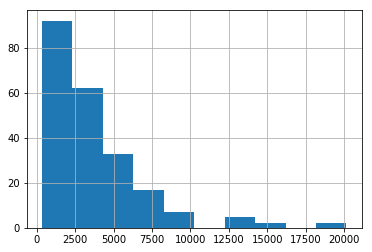

In [3]:
from collections import defaultdict
base_json = '../Dataset/Entity Recognition in Resumes.json'
def pop_annot(raw_line):
    in_line = defaultdict(list, **raw_line)
    if 'annotation' in in_line:
        labels = in_line['annotation']
        for c_lab in labels:
            if len(c_lab['label'])>0:
                in_line[c_lab['label'][0]] = ''.join(in_line[c_lab['label'][0]])
                for point in c_lab['points']:
                    text=point['text']
                    in_line[c_lab['label'][0]] += ' ' + text
    return in_line
with open(base_json, 'r', encoding='utf8') as f:
    # data is jsonl and so we parse it line-by-line
    resume_data = [json.loads(f_line) for f_line in f.readlines()]
    resume_df = pd.DataFrame([pop_annot(line) for line in resume_data])
resume_df['length'] = resume_df['content'].map(len)
resume_df['length'].hist()
resume_df.head(3)

In [4]:
resume_content = pd.DataFrame(resume_df['content'])
print(resume_content.head())
resume_content.describe()

                                             content
0  Abhishek Jha\nApplication Development Associat...
1  Afreen Jamadar\nActive member of IIIT Committe...
2  Akhil Yadav Polemaina\nHyderabad, Telangana - ...
3  Alok Khandai\nOperational Analyst (SQL DBA) En...
4  Ananya Chavan\nlecturer - oracle tutorials\n\n...


,content
count,220
unique,219
top,Sameer Kujur\nOrrisha - Email me on Indeed: in...
freq,2


In [5]:
job_postings = pd.read_csv('../Dataset/job_postings.csv')
print(job_postings.head())

job_postings=job_postings.drop_duplicates()

jobdescs = job_postings['Description']
print(jobdescs.describe())

                                            Title  \
0                                  data scientist   
1  octri office of research impact data scientist   
2                                  data scientist   
3       data scientist - nationwide opportunities   
4                     data analyst/data scientist   

                                         Description  \
0  COMPANY PROFILE\n\nOshkosh Corporation is a le...   
1  Description\n\n\n\nJob Title OCTRI Office of R...   
2  JOB DESCRIPTION\nWe are looking for a Data Sci...   
3  A Bachelor or Masters Degree in a highly quant...   
4  Job SummaryCascade Data Labs is a boutique con...   

                              Company            Location  
0                 Oshkosh Corporation       United States  
1  Oregon Health & Science University        Portland, OR  
2                           M Science        Portland, OR  
3            Amazon Web Services, Inc        Portland, OR  
4                   Cascade Data Labs  Portl

In [6]:
jd_start = 1
jd_end = 100
jobdesc_short = jobdescs[jd_start-1:jd_end]
print(jobdesc_short.head())
print(jobdesc_short.describe())
pd.DataFrame(jobdesc_short).to_sql("Job_Descriptions", db, if_exists="replace")

res_start = 1
res_end = 220
resumes_short = resume_content[res_start-1:res_end]
print(resumes_short.head())
print(resumes_short.describe())
pd.DataFrame(resumes_short).to_sql("Resumes", db, if_exists="replace")

0    COMPANY PROFILE\n\nOshkosh Corporation is a le...
1    Description\n\n\n\nJob Title OCTRI Office of R...
2    JOB DESCRIPTION\nWe are looking for a Data Sci...
3    A Bachelor or Masters Degree in a highly quant...
4    Job SummaryCascade Data Labs is a boutique con...
Name: Description, dtype: object
count                                                   100
unique                                                  100
top       The Earle A. Chiles Research Institute (EACRI)...
freq                                                      1
Name: Description, dtype: object
                                             content
0  Abhishek Jha\nApplication Development Associat...
1  Afreen Jamadar\nActive member of IIIT Committe...
2  Akhil Yadav Polemaina\nHyderabad, Telangana - ...
3  Alok Khandai\nOperational Analyst (SQL DBA) En...
4  Ananya Chavan\nlecturer - oracle tutorials\n\n...
                                                  content
count                                      

In [7]:
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\<)|(\>)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)|(\_)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

In [8]:
jobdesc_short = preprocess_reviews(jobdesc_short)

jobdescs_tokens = []
for jobdesc in jobdesc_short:
    jobdesc = jobdesc.replace('\n', '')
    jobdescs_tokens.append([token.text.lower() for token in spacy_nlp(jobdesc) if not token.is_stop])

print(jobdescs_tokens[0])

['company', 'profileoshkosh', 'corporation', 'leading', 'manufacturer', 'marketer', 'access', 'equipment', 'specialty', 'vehicles', 'truck', 'bodies', 'primary', 'markets', 'defense', 'concrete', 'placement', 'refuse', 'hauling', 'access', 'equipment', 'fire', '&', 'emergency', 'founded', '1917', 'oshkosh', 'corporation', 'manufacturing', 'operations', 'states', 'australia', 'belgium', 'brazil', 'canada', 'china', 'france', 'mexico', 'netherlands', 'romania', 'company', 'currently', 'employs', 'approximately', '12100', 'people', 'worldwideoshkosh', 'corporation', 'fortune', '350', 'multi', 'billion', 'dollar', 'company', 'oshkosh', 'corporation', 'designs', 'builds', 'worlds', 'toughest', 'specialty', 'trucks', 'truck', 'bodies', 'access', 'equipment', 'working', 'shoulder', 'shoulder', 'people', 'use', 'themthis', 'role', 'located', 'oshkosh', 'wi', 'satelite', 'office', 'evanston', 'il', 'outside', 'chicago', 'offer', 'comprehensive', 'relocation', 'package', 'qualified', 'candidates

In [9]:
resumes_short = preprocess_reviews(resumes_short['content'])

resumes_tokens = []
for resume in resumes_short:
    resume = resume.replace('\n', '')
    resumes_tokens.append([token.text.lower() for token in spacy_nlp(resume) if not token.is_stop])
    
print(resumes_tokens[0])

['abhishek', 'jhaapplication', 'development', 'associate', '  ', 'accenturebengaluru', 'karnataka', '  ', 'email', 'indeedcom', 'r', 'abhishek', 'jha', '10e7a8cb732bc43a•', 'work', 'organization', 'provides', 'opportunity', 'improve', 'skillsand', 'knowledge', 'individual', 'companys', 'growth', 'best', 'possible', 'wayswilling', 'relocate', 'bangalore', 'karnatakawork', 'experienceapplication', 'development', 'associateaccenture', ' ', 'november', '2017', 'presentrole', 'currently', 'working', 'chat', 'bot', 'developing', 'backend', 'oracle', 'peoplesoft', 'queriesfor', 'bot', 'triggered', 'based', 'given', 'input', 'training', 'bot', 'different', 'possibleutterances', 'positive', 'negative', 'given', 'asinput', 'usereducationbe', 'information', 'science', 'engineeringbvb', 'college', 'engineering', 'technology', '   ', 'hubli', 'karnatakaaugust', '2013', 'june', '201712th', 'mathematicswoodbine', 'modern', 'schoolapril', '2011', 'march', '201310thkendriya', 'vidyalayaapril', '2001', 

In [10]:
sql_cmd = """DROP TABLE Comparisons;"""
crsr.execute(sql_cmd)

sql_cmd = """CREATE TABLE Comparisons ( \
    num1 INTEGER, \
    num2 INTEGER, \
    jd_len INTEGER, \
    res_len INTEGER, \
    distance FLOAT, \
    elapsed_time FLOAT, \
    cum_time FLOAT);"""
crsr.execute(sql_cmd)

In [ ]:
comparisons_map = np.empty([jd_end, res_end])
comparisons_list = []

start_time = time.time()
last_time = start_time

for num1, jobdesc_token in enumerate(jobdescs_tokens):
    for num2, resume_token in enumerate(resumes_tokens):
        print('-' * 50)
        print('Comparing JD', num1, '(length', len(jobdesc_token), ') to Res', num2, '(length', len(resume_token), ')')
        distance = glove_model.wmdistance(jobdesc_token, resume_token)

        elapsed_time = time.time() - last_time             
        last_time = time.time()            
        cum_time = last_time-start_time
            
        print('Distance = %.4f' % distance, ". Comparison Time = ", elapsed_time, ". Cumulative Time = ", cum_time)
        comparisons_map[num1][num2]=distance

        comparisons = [num1,num2,distance,elapsed_time,cum_time]
        comparisons_list.append(comparisons)

        crsr.execute("INSERT INTO Comparisons VALUES(?,?,?,?,?,?,?)",
        (num1,num2,len(jobdesc_token),len(resume_token),distance,elapsed_time,cum_time))
        db.commit()
    
elapsed_time = time.time() - start_time

--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 0 (length 150 )
Distance = 4.3244 . Comparison Time =  2.3192968368530273 . Cumulative Time =  2.3192968368530273
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 1 (length 125 )
Distance = 4.5424 . Comparison Time =  1.5152816772460938 . Cumulative Time =  3.834578514099121
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 2 (length 433 )
Distance = 3.8506 . Comparison Time =  4.932802677154541 . Cumulative Time =  8.767381191253662
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 3 (length 840 )
Distance = 3.9363 . Comparison Time =  9.303017616271973 . Cumulative Time =  18.070398807525635
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 4 (length 306 )
Distance = 4.4296 . Comparison Time =  4.569652795791626 . Cumulative Time =  22.64005160331726
-

Distance = 4.1308 . Comparison Time =  6.841955184936523 . Cumulative Time =  215.50113940238953
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 41 (length 442 )
Distance = 3.9644 . Comparison Time =  7.179112434387207 . Cumulative Time =  222.68025183677673
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 42 (length 611 )
Distance = 4.1263 . Comparison Time =  8.066949367523193 . Cumulative Time =  230.74720120429993
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 43 (length 741 )
Distance = 3.9007 . Comparison Time =  13.763471364974976 . Cumulative Time =  244.5106725692749
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 44 (length 317 )
Distance = 4.2672 . Comparison Time =  5.201557397842407 . Cumulative Time =  249.7122299671173
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 45 (length 25

Comparing JD 0 (length 401 ) to Res 81 (length 544 )
Distance = 4.0767 . Comparison Time =  8.219367027282715 . Cumulative Time =  511.9860656261444
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 82 (length 214 )
Distance = 4.1599 . Comparison Time =  3.7844831943511963 . Cumulative Time =  515.7705488204956
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 83 (length 262 )
Distance = 4.3726 . Comparison Time =  3.822711944580078 . Cumulative Time =  519.5932607650757
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 84 (length 213 )
Distance = 4.7277 . Comparison Time =  2.947730779647827 . Cumulative Time =  522.5409915447235
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 85 (length 449 )
Distance = 3.8985 . Comparison Time =  8.034751415252686 . Cumulative Time =  530.5757429599762
--------------------------------------------------

--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 122 (length 71 )
Distance = 5.7593 . Comparison Time =  0.5307214260101318 . Cumulative Time =  813.5290110111237
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 123 (length 47 )
Distance = 5.1442 . Comparison Time =  0.5718889236450195 . Cumulative Time =  814.1008999347687
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 124 (length 291 )
Distance = 3.8568 . Comparison Time =  4.982356309890747 . Cumulative Time =  819.0832562446594
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 125 (length 56 )
Distance = 5.7530 . Comparison Time =  0.40126514434814453 . Cumulative Time =  819.4845213890076
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 126 (length 266 )
Distance = 4.0480 . Comparison Time =  3.0618131160736084 . Cumulative Time =  822.5463345

Distance = 3.7981 . Comparison Time =  12.79780387878418 . Cumulative Time =  1001.900340795517
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 163 (length 213 )
Distance = 4.1317 . Comparison Time =  3.9888365268707275 . Cumulative Time =  1005.8891773223877
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 164 (length 483 )
Distance = 4.1518 . Comparison Time =  7.818951845169067 . Cumulative Time =  1013.7081291675568
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 165 (length 810 )
Distance = 3.7946 . Comparison Time =  19.599954843521118 . Cumulative Time =  1033.3080840110779
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 166 (length 1218 )
Distance = 3.7814 . Comparison Time =  22.840324640274048 . Cumulative Time =  1056.148408651352
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 167 (l

--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 203 (length 156 )
Distance = 4.5191 . Comparison Time =  2.1685144901275635 . Cumulative Time =  1242.2994513511658
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 204 (length 131 )
Distance = 4.4644 . Comparison Time =  1.5792665481567383 . Cumulative Time =  1243.8787178993225
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 205 (length 794 )
Distance = 3.8030 . Comparison Time =  13.260250568389893 . Cumulative Time =  1257.1389684677124
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 206 (length 118 )
Distance = 4.8288 . Comparison Time =  1.508338212966919 . Cumulative Time =  1258.6473066806793
--------------------------------------------------
Comparing JD 0 (length 401 ) to Res 207 (length 639 )
Distance = 3.8563 . Comparison Time =  11.536010026931763 . Cumulative Time =  1270.

Distance = 3.8931 . Comparison Time =  14.272732734680176 . Cumulative Time =  1531.1425647735596
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 24 (length 220 )
Distance = 4.4872 . Comparison Time =  4.320704221725464 . Cumulative Time =  1535.463268995285
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 25 (length 158 )
Distance = 4.4387 . Comparison Time =  1.8823232650756836 . Cumulative Time =  1537.3455922603607
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 26 (length 550 )
Distance = 3.7863 . Comparison Time =  18.826555967330933 . Cumulative Time =  1556.1721482276917
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 27 (length 270 )
Distance = 3.9469 . Comparison Time =  5.418872117996216 . Cumulative Time =  1561.5910203456879
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 28 (length

--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 64 (length 467 )
Distance = 3.9663 . Comparison Time =  8.407353162765503 . Cumulative Time =  1867.286227464676
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 65 (length 412 )
Distance = 4.1959 . Comparison Time =  9.446997165679932 . Cumulative Time =  1876.7332246303558
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 66 (length 232 )
Distance = 4.4301 . Comparison Time =  4.882698059082031 . Cumulative Time =  1881.6159226894379
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 67 (length 286 )
Distance = 3.9199 . Comparison Time =  9.670671463012695 . Cumulative Time =  1891.2865941524506
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 68 (length 343 )
Distance = 4.5111 . Comparison Time =  9.466285943984985 . Cumulative Time =  1900.7528800964

Distance = 5.9216 . Comparison Time =  0.5421288013458252 . Cumulative Time =  2363.248749256134
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 105 (length 91 )
Distance = 4.8393 . Comparison Time =  1.6204323768615723 . Cumulative Time =  2364.8691816329956
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 106 (length 95 )
Distance = 4.5843 . Comparison Time =  0.9925298690795898 . Cumulative Time =  2365.861711502075
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 107 (length 131 )
Distance = 4.6275 . Comparison Time =  1.9572176933288574 . Cumulative Time =  2367.818929195404
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 108 (length 353 )
Distance = 3.9010 . Comparison Time =  7.483687162399292 . Cumulative Time =  2375.3026163578033
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 109 (leng

--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 145 (length 73 )
Distance = 5.2550 . Comparison Time =  0.631333589553833 . Cumulative Time =  2632.426482439041
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 146 (length 63 )
Distance = 4.9860 . Comparison Time =  1.3476321697235107 . Cumulative Time =  2633.7741146087646
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 147 (length 171 )
Distance = 4.7127 . Comparison Time =  2.1213953495025635 . Cumulative Time =  2635.895509958267
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 148 (length 104 )
Distance = 4.6474 . Comparison Time =  1.025233268737793 . Cumulative Time =  2636.920743227005
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 149 (length 41 )
Distance = 5.7245 . Comparison Time =  0.47913646697998047 . Cumulative Time =  2637.399879

Distance = 3.9850 . Comparison Time =  10.001990795135498 . Cumulative Time =  2962.4536571502686
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 186 (length 117 )
Distance = 5.3158 . Comparison Time =  1.6457290649414062 . Cumulative Time =  2964.09938621521
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 187 (length 358 )
Distance = 4.0563 . Comparison Time =  4.87277889251709 . Cumulative Time =  2968.972165107727
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 188 (length 138 )
Distance = 4.4310 . Comparison Time =  2.128833770751953 . Cumulative Time =  2971.100998878479
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 189 (length 348 )
Distance = 3.7437 . Comparison Time =  8.512397527694702 . Cumulative Time =  2979.6133964061737
--------------------------------------------------
Comparing JD 1 (length 628 ) to Res 190 (length

--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 6 (length 593 )
Distance = 4.0721 . Comparison Time =  3.2527737617492676 . Cumulative Time =  3232.198185443878
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 7 (length 210 )
Distance = 4.4137 . Comparison Time =  0.6636466979980469 . Cumulative Time =  3232.861832141876
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 8 (length 163 )
Distance = 4.3528 . Comparison Time =  0.41515183448791504 . Cumulative Time =  3233.276983976364
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 9 (length 538 )
Distance = 4.0658 . Comparison Time =  1.908113956451416 . Cumulative Time =  3235.1850979328156
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 10 (length 67 )
Distance = 5.1015 . Comparison Time =  0.21526455879211426 . Cumulative Time =  3235.40036249160

Distance = 4.5390 . Comparison Time =  0.5788319110870361 . Cumulative Time =  3291.096040248871
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 47 (length 98 )
Distance = 4.8969 . Comparison Time =  0.22816014289855957 . Cumulative Time =  3291.3242003917694
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 48 (length 343 )
Distance = 4.2609 . Comparison Time =  1.468658685684204 . Cumulative Time =  3292.7928590774536
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 49 (length 343 )
Distance = 4.0960 . Comparison Time =  1.1918880939483643 . Cumulative Time =  3293.984747171402
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 50 (length 303 )
Distance = 4.4896 . Comparison Time =  1.2846407890319824 . Cumulative Time =  3295.269387960434
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 51 (length 

--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 87 (length 220 )
Distance = 4.5128 . Comparison Time =  0.6825296878814697 . Cumulative Time =  3367.27947807312
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 88 (length 528 )
Distance = 4.0884 . Comparison Time =  1.8495538234710693 . Cumulative Time =  3369.129031896591
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 89 (length 1585 )
Distance = 3.9768 . Comparison Time =  12.429450035095215 . Cumulative Time =  3381.5584819316864
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 90 (length 246 )
Distance = 4.4947 . Comparison Time =  1.60257887840271 . Cumulative Time =  3383.161060810089
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 91 (length 628 )
Distance = 4.1455 . Comparison Time =  2.0489776134490967 . Cumulative Time =  3385.210038423

Distance = 5.6368 . Comparison Time =  0.13391995429992676 . Cumulative Time =  3446.6292130947113
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 128 (length 116 )
Distance = 4.7317 . Comparison Time =  0.3199193477630615 . Cumulative Time =  3446.9491324424744
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 129 (length 73 )
Distance = 5.0225 . Comparison Time =  0.2108020782470703 . Cumulative Time =  3447.1599345207214
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 130 (length 330 )
Distance = 3.9011 . Comparison Time =  1.2133033275604248 . Cumulative Time =  3448.373237848282
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 131 (length 205 )
Distance = 4.7724 . Comparison Time =  0.5316791534423828 . Cumulative Time =  3448.9049170017242
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 132 

--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 168 (length 160 )
Distance = 5.1104 . Comparison Time =  0.3541445732116699 . Cumulative Time =  3507.631765127182
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 169 (length 589 )
Distance = 4.3866 . Comparison Time =  3.063300371170044 . Cumulative Time =  3510.695065498352
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 170 (length 254 )
Distance = 4.1944 . Comparison Time =  0.8521277904510498 . Cumulative Time =  3511.547193288803
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 171 (length 376 )
Distance = 3.8297 . Comparison Time =  0.9890265464782715 . Cumulative Time =  3512.5362198352814
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 172 (length 36 )
Distance = 5.6138 . Comparison Time =  0.1334230899810791 . Cumulative Time =  3512.6696

Comparing JD 2 (length 177 ) to Res 208 (length 164 )
Distance = 4.6331 . Comparison Time =  0.5852782726287842 . Cumulative Time =  3563.111490726471
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 209 (length 105 )
Distance = 4.3956 . Comparison Time =  0.332319974899292 . Cumulative Time =  3563.4438107013702
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 210 (length 69 )
Distance = 5.3114 . Comparison Time =  0.1775681972503662 . Cumulative Time =  3563.6213788986206
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 211 (length 245 )
Distance = 4.3552 . Comparison Time =  0.591233491897583 . Cumulative Time =  3564.212612390518
--------------------------------------------------
Comparing JD 2 (length 177 ) to Res 212 (length 103 )
Distance = 4.4500 . Comparison Time =  0.3734893798828125 . Cumulative Time =  3564.586101770401
------------------------------------------

--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 29 (length 899 )
Distance = 3.9815 . Comparison Time =  10.066447734832764 . Cumulative Time =  3718.070241212845
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 30 (length 350 )
Distance = 4.0937 . Comparison Time =  4.30726957321167 . Cumulative Time =  3722.3775107860565
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 31 (length 429 )
Distance = 3.9241 . Comparison Time =  4.386793851852417 . Cumulative Time =  3726.764304637909
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 32 (length 225 )
Distance = 4.0638 . Comparison Time =  2.5271222591400146 . Cumulative Time =  3729.291426897049
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 33 (length 178 )
Distance = 4.4330 . Comparison Time =  1.7578527927398682 . Cumulative Time =  3731.0492796897

Distance = 4.2786 . Comparison Time =  3.971477746963501 . Cumulative Time =  3886.3588976860046
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 70 (length 1231 )
Distance = 3.6671 . Comparison Time =  20.251052618026733 . Cumulative Time =  3906.6099503040314
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 71 (length 508 )
Distance = 3.7259 . Comparison Time =  4.751684665679932 . Cumulative Time =  3911.3616349697113
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 72 (length 32 )
Distance = 5.9807 . Comparison Time =  0.22816085815429688 . Cumulative Time =  3911.5897958278656
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 73 (length 624 )
Distance = 3.8098 . Comparison Time =  8.416276693344116 . Cumulative Time =  3920.0060725212097
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 74 (lengt

Comparing JD 3 (length 481 ) to Res 110 (length 32 )
Distance = 5.9807 . Comparison Time =  0.28272175788879395 . Cumulative Time =  4149.493687391281
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 111 (length 503 )
Distance = 3.9387 . Comparison Time =  8.501103162765503 . Cumulative Time =  4157.994790554047
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 112 (length 416 )
Distance = 4.1862 . Comparison Time =  6.340949058532715 . Cumulative Time =  4164.335739612579
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 113 (length 89 )
Distance = 4.9806 . Comparison Time =  1.3074586391448975 . Cumulative Time =  4165.643198251724
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 114 (length 2122 )
Distance = 3.6670 . Comparison Time =  33.197672843933105 . Cumulative Time =  4198.840871095657
-------------------------------------------

Distance = 5.9392 . Comparison Time =  0.2861909866333008 . Cumulative Time =  4294.477194309235
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 151 (length 235 )
Distance = 4.1768 . Comparison Time =  2.386258125305176 . Cumulative Time =  4296.86345243454
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 152 (length 275 )
Distance = 4.0001 . Comparison Time =  2.949302911758423 . Cumulative Time =  4299.812755346298
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 153 (length 454 )
Distance = 4.0165 . Comparison Time =  7.203413009643555 . Cumulative Time =  4307.016168355942
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 154 (length 913 )
Distance = 3.9894 . Comparison Time =  15.50674557685852 . Cumulative Time =  4322.5229139328
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 155 (length 156

--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 191 (length 303 )
Distance = 4.0698 . Comparison Time =  3.9348065853118896 . Cumulative Time =  4488.716454029083
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 192 (length 243 )
Distance = 4.0987 . Comparison Time =  3.0657808780670166 . Cumulative Time =  4491.78223490715
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 193 (length 482 )
Distance = 4.4968 . Comparison Time =  2.2176527976989746 . Cumulative Time =  4493.999887704849
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 194 (length 68 )
Distance = 4.8326 . Comparison Time =  0.6264476776123047 . Cumulative Time =  4494.626335382462
--------------------------------------------------
Comparing JD 3 (length 481 ) to Res 195 (length 1525 )
Distance = 3.8186 . Comparison Time =  30.101881504058838 . Cumulative Time =  4524.7282

Distance = 4.0681 . Comparison Time =  1.2970407009124756 . Cumulative Time =  4645.4523820877075
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 12 (length 149 )
Distance = 4.3120 . Comparison Time =  0.6750574111938477 . Cumulative Time =  4646.127439498901
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 13 (length 188 )
Distance = 4.1962 . Comparison Time =  0.778223991394043 . Cumulative Time =  4646.905663490295
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 14 (length 160 )
Distance = 4.2033 . Comparison Time =  0.6849777698516846 . Cumulative Time =  4647.590641260147
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 15 (length 203 )
Distance = 4.3220 . Comparison Time =  0.9096639156341553 . Cumulative Time =  4648.500305175781
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 16 (length 1

Comparing JD 4 (length 231 ) to Res 52 (length 257 )
Distance = 3.9702 . Comparison Time =  1.0470595359802246 . Cumulative Time =  4735.947072267532
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 53 (length 144 )
Distance = 4.4233 . Comparison Time =  0.4588644504547119 . Cumulative Time =  4736.405936717987
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 54 (length 1334 )
Distance = 3.9979 . Comparison Time =  4.9123876094818115 . Cumulative Time =  4741.318324327469
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 55 (length 384 )
Distance = 4.1180 . Comparison Time =  1.551985740661621 . Cumulative Time =  4742.8703100681305
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 56 (length 403 )
Distance = 4.2242 . Comparison Time =  2.358978271484375 . Cumulative Time =  4745.229288339615
----------------------------------------------

--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 93 (length 788 )
Distance = 3.8933 . Comparison Time =  5.446580171585083 . Cumulative Time =  4883.095798492432
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 94 (length 402 )
Distance = 3.9881 . Comparison Time =  2.4958746433258057 . Cumulative Time =  4885.591673135757
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 95 (length 299 )
Distance = 4.3256 . Comparison Time =  1.8168504238128662 . Cumulative Time =  4887.40852355957
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 96 (length 34 )
Distance = 5.7820 . Comparison Time =  0.1616966724395752 . Cumulative Time =  4887.57022023201
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 97 (length 93 )
Distance = 4.8596 . Comparison Time =  0.42110347747802734 . Cumulative Time =  4887.991323709488

Distance = 4.5187 . Comparison Time =  0.4508650302886963 . Cumulative Time =  4978.423982381821
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 134 (length 69 )
Distance = 5.8516 . Comparison Time =  0.19046401977539062 . Cumulative Time =  4978.614446401596
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 135 (length 90 )
Distance = 5.7416 . Comparison Time =  0.8962750434875488 . Cumulative Time =  4979.510721445084
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 136 (length 44 )
Distance = 5.8816 . Comparison Time =  0.17905402183532715 . Cumulative Time =  4979.689775466919
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 137 (length 703 )
Distance = 3.6386 . Comparison Time =  3.7011892795562744 . Cumulative Time =  4983.390964746475
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 138 (leng

--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 174 (length 136 )
Distance = 4.9641 . Comparison Time =  0.2618906497955322 . Cumulative Time =  5081.422292232513
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 175 (length 373 )
Distance = 4.3556 . Comparison Time =  1.8942229747772217 . Cumulative Time =  5083.316515207291
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 176 (length 710 )
Distance = 3.9448 . Comparison Time =  5.24577522277832 . Cumulative Time =  5088.562290430069
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 177 (length 309 )
Distance = 4.1309 . Comparison Time =  2.864441394805908 . Cumulative Time =  5091.426731824875
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 178 (length 432 )
Distance = 4.1333 . Comparison Time =  2.4576833248138428 . Cumulative Time =  5093.884415

Distance = 4.1384 . Comparison Time =  4.1545374393463135 . Cumulative Time =  5173.230865955353
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 215 (length 72 )
Distance = 4.8253 . Comparison Time =  0.2167530059814453 . Cumulative Time =  5173.447618961334
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 216 (length 938 )
Distance = 4.2599 . Comparison Time =  8.350697040557861 . Cumulative Time =  5181.798316001892
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 217 (length 144 )
Distance = 4.3561 . Comparison Time =  0.5322084426879883 . Cumulative Time =  5182.33052444458
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 218 (length 976 )
Distance = 4.1065 . Comparison Time =  13.606611490249634 . Cumulative Time =  5195.93713593483
--------------------------------------------------
Comparing JD 4 (length 231 ) to Res 219 (length 

Comparing JD 5 (length 256 ) to Res 35 (length 161 )
Distance = 4.4544 . Comparison Time =  0.5763523578643799 . Cumulative Time =  5264.732075452805
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 36 (length 337 )
Distance = 3.7070 . Comparison Time =  1.49147367477417 . Cumulative Time =  5266.223549127579
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 37 (length 142 )
Distance = 4.5306 . Comparison Time =  0.4215998649597168 . Cumulative Time =  5266.645148992538
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 38 (length 734 )
Distance = 3.8028 . Comparison Time =  7.357739448547363 . Cumulative Time =  5274.002888441086
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 39 (length 368 )
Distance = 4.2016 . Comparison Time =  1.8877782821655273 . Cumulative Time =  5275.890666723251
-------------------------------------------------

--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 76 (length 810 )
Distance = 4.1828 . Comparison Time =  5.021012306213379 . Cumulative Time =  5354.451739311218
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 77 (length 610 )
Distance = 3.8045 . Comparison Time =  3.2042009830474854 . Cumulative Time =  5357.655940294266
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 78 (length 1277 )
Distance = 4.0934 . Comparison Time =  14.207538366317749 . Cumulative Time =  5371.8634786605835
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 79 (length 272 )
Distance = 4.1198 . Comparison Time =  1.982017993927002 . Cumulative Time =  5373.8454966545105
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 80 (length 403 )
Distance = 4.1953 . Comparison Time =  0.8844060897827148 . Cumulative Time =  5374.7299027

Distance = 4.3688 . Comparison Time =  0.6497604846954346 . Cumulative Time =  5474.474228620529
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 117 (length 33 )
Distance = 5.8849 . Comparison Time =  0.1354084014892578 . Cumulative Time =  5474.609637022018
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 118 (length 360 )
Distance = 3.9783 . Comparison Time =  1.848097801208496 . Cumulative Time =  5476.457734823227
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 119 (length 84 )
Distance = 5.5877 . Comparison Time =  0.26337623596191406 . Cumulative Time =  5476.721111059189
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 120 (length 908 )
Distance = 3.9064 . Comparison Time =  5.006170749664307 . Cumulative Time =  5481.727281808853
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 121 (length

--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 157 (length 185 )
Distance = 4.3286 . Comparison Time =  0.9453775882720947 . Cumulative Time =  5530.7213089466095
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 158 (length 651 )
Distance = 4.1494 . Comparison Time =  3.2428505420684814 . Cumulative Time =  5533.964159488678
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 159 (length 128 )
Distance = 4.4863 . Comparison Time =  0.45532870292663574 . Cumulative Time =  5534.419488191605
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 160 (length 461 )
Distance = 3.8171 . Comparison Time =  2.49190616607666 . Cumulative Time =  5536.911394357681
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 161 (length 124 )
Distance = 4.8109 . Comparison Time =  0.5074090957641602 . Cumulative Time =  5537.418

Distance = 4.6884 . Comparison Time =  0.5937130451202393 . Cumulative Time =  5637.211573839188
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 198 (length 101 )
Distance = 4.9863 . Comparison Time =  0.32388854026794434 . Cumulative Time =  5637.535462379456
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 199 (length 251 )
Distance = 4.2564 . Comparison Time =  0.9458720684051514 . Cumulative Time =  5638.481334447861
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 200 (length 38 )
Distance = 5.9702 . Comparison Time =  0.17657756805419922 . Cumulative Time =  5638.657912015915
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 201 (length 121 )
Distance = 4.7462 . Comparison Time =  0.3422422409057617 . Cumulative Time =  5639.000154256821
--------------------------------------------------
Comparing JD 5 (length 256 ) to Res 202 (le

--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 18 (length 232 )
Distance = 4.0930 . Comparison Time =  0.9870412349700928 . Cumulative Time =  5730.160607337952
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 19 (length 702 )
Distance = 3.9134 . Comparison Time =  2.350048303604126 . Cumulative Time =  5732.510655641556
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 20 (length 200 )
Distance = 4.8162 . Comparison Time =  0.4037444591522217 . Cumulative Time =  5732.914400100708
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 21 (length 529 )
Distance = 4.0308 . Comparison Time =  2.074772357940674 . Cumulative Time =  5734.989172458649
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 22 (length 252 )
Distance = 4.1630 . Comparison Time =  0.8149268627166748 . Cumulative Time =  5735.8040993213

Distance = 5.1452 . Comparison Time =  0.2891690731048584 . Cumulative Time =  5785.6106832027435
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 59 (length 421 )
Distance = 4.1304 . Comparison Time =  1.162128210067749 . Cumulative Time =  5786.772811412811
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 60 (length 449 )
Distance = 3.9893 . Comparison Time =  1.7350127696990967 . Cumulative Time =  5788.50782418251
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 61 (length 543 )
Distance = 3.8875 . Comparison Time =  2.4413416385650635 . Cumulative Time =  5790.949165821075
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 62 (length 318 )
Distance = 3.9778 . Comparison Time =  1.0495424270629883 . Cumulative Time =  5791.998708248138
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 63 (length 43

Comparing JD 6 (length 149 ) to Res 99 (length 545 )
Distance = 3.9461 . Comparison Time =  2.4874794483184814 . Cumulative Time =  5882.799353599548
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 100 (length 857 )
Distance = 4.1286 . Comparison Time =  3.1654105186462402 . Cumulative Time =  5885.964764118195
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 101 (length 1802 )
Distance = 3.9468 . Comparison Time =  6.664790868759155 . Cumulative Time =  5892.629554986954
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 102 (length 379 )
Distance = 4.1377 . Comparison Time =  2.160079002380371 . Cumulative Time =  5894.789633989334
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 103 (length 741 )
Distance = 4.2872 . Comparison Time =  1.5599524974822998 . Cumulative Time =  5896.349586486816
-------------------------------------------

Distance = 5.9555 . Comparison Time =  0.16169500350952148 . Cumulative Time =  5942.9523339271545
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 140 (length 185 )
Distance = 3.9833 . Comparison Time =  0.36704063415527344 . Cumulative Time =  5943.31937456131
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 141 (length 48 )
Distance = 6.1070 . Comparison Time =  0.11407971382141113 . Cumulative Time =  5943.433454275131
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 142 (length 509 )
Distance = 4.0884 . Comparison Time =  3.053874969482422 . Cumulative Time =  5946.487329244614
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 143 (length 49 )
Distance = 6.1221 . Comparison Time =  0.14086484909057617 . Cumulative Time =  5946.628194093704
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 144 (le

--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 180 (length 193 )
Distance = 4.6545 . Comparison Time =  0.5347249507904053 . Cumulative Time =  6006.43643450737
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 181 (length 174 )
Distance = 4.5056 . Comparison Time =  0.6269083023071289 . Cumulative Time =  6007.063342809677
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 182 (length 58 )
Distance = 6.0776 . Comparison Time =  0.17211198806762695 . Cumulative Time =  6007.235454797745
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 183 (length 240 )
Distance = 4.2286 . Comparison Time =  0.8184006214141846 . Cumulative Time =  6008.053855419159
--------------------------------------------------
Comparing JD 6 (length 149 ) to Res 184 (length 366 )
Distance = 4.1516 . Comparison Time =  1.2152016162872314 . Cumulative Time =  6009.2690

Distance = 4.3301 . Comparison Time =  1.0639207363128662 . Cumulative Time =  6068.363188505173
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 1 (length 125 )
Distance = 4.6332 . Comparison Time =  0.6591854095458984 . Cumulative Time =  6069.022373914719
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 2 (length 433 )
Distance = 3.9279 . Comparison Time =  3.307403087615967 . Cumulative Time =  6072.329777002335
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 3 (length 840 )
Distance = 4.0974 . Comparison Time =  6.901348829269409 . Cumulative Time =  6079.231125831604
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 4 (length 306 )
Distance = 4.4528 . Comparison Time =  3.115875482559204 . Cumulative Time =  6082.347001314163
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 5 (length 300 )
Dis

Comparing JD 7 (length 319 ) to Res 41 (length 442 )
Distance = 4.1165 . Comparison Time =  3.6114137172698975 . Cumulative Time =  6202.414970874786
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 42 (length 611 )
Distance = 4.1560 . Comparison Time =  3.628843307495117 . Cumulative Time =  6206.0438141822815
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 43 (length 741 )
Distance = 3.8695 . Comparison Time =  8.601212739944458 . Cumulative Time =  6214.645026922226
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 44 (length 317 )
Distance = 4.3356 . Comparison Time =  3.267155170440674 . Cumulative Time =  6217.912182092667
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 45 (length 251 )
Distance = 4.1715 . Comparison Time =  2.0951058864593506 . Cumulative Time =  6220.007287979126
------------------------------------------------

--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 82 (length 214 )
Distance = 4.0246 . Comparison Time =  1.5609135627746582 . Cumulative Time =  6381.797366142273
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 83 (length 262 )
Distance = 4.3205 . Comparison Time =  1.7662577629089355 . Cumulative Time =  6383.563623905182
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 84 (length 213 )
Distance = 4.7790 . Comparison Time =  1.444850206375122 . Cumulative Time =  6385.008474111557
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 85 (length 449 )
Distance = 3.8303 . Comparison Time =  3.808786630630493 . Cumulative Time =  6388.8172607421875
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 86 (length 470 )
Distance = 3.8208 . Comparison Time =  4.13419771194458 . Cumulative Time =  6392.95145845413

Distance = 5.7354 . Comparison Time =  0.21675324440002441 . Cumulative Time =  6563.5258667469025
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 123 (length 47 )
Distance = 5.0565 . Comparison Time =  0.3035542964935303 . Cumulative Time =  6563.829421043396
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 124 (length 291 )
Distance = 3.9098 . Comparison Time =  2.5945942401885986 . Cumulative Time =  6566.424015283585
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 125 (length 56 )
Distance = 5.7099 . Comparison Time =  0.26336145401000977 . Cumulative Time =  6566.687376737595
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 126 (length 266 )
Distance = 3.9998 . Comparison Time =  1.8704469203948975 . Cumulative Time =  6568.5578236579895
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 127 (l

--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 163 (length 213 )
Distance = 4.1439 . Comparison Time =  2.3153278827667236 . Cumulative Time =  6671.222712993622
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 164 (length 483 )
Distance = 4.2689 . Comparison Time =  3.8524365425109863 . Cumulative Time =  6675.075149536133
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 165 (length 810 )
Distance = 3.9864 . Comparison Time =  13.277963876724243 . Cumulative Time =  6688.353113412857
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 166 (length 1218 )
Distance = 3.7813 . Comparison Time =  15.901992082595825 . Cumulative Time =  6704.255105495453
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 167 (length 830 )
Distance = 4.0728 . Comparison Time =  10.038057804107666 . Cumulative Time =  6714.29

Distance = 4.4573 . Comparison Time =  1.128401279449463 . Cumulative Time =  6817.631096363068
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 204 (length 131 )
Distance = 4.4253 . Comparison Time =  1.034656047821045 . Cumulative Time =  6818.665752410889
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 205 (length 794 )
Distance = 3.9833 . Comparison Time =  11.70380687713623 . Cumulative Time =  6830.369559288025
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 206 (length 118 )
Distance = 4.7680 . Comparison Time =  0.6249620914459229 . Cumulative Time =  6830.994521379471
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 207 (length 639 )
Distance = 3.9712 . Comparison Time =  9.075357675552368 . Cumulative Time =  6840.069879055023
--------------------------------------------------
Comparing JD 7 (length 319 ) to Res 208 (length 

Comparing JD 8 (length 240 ) to Res 24 (length 220 )
Distance = 4.4668 . Comparison Time =  0.715233325958252 . Cumulative Time =  6927.34384727478
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 25 (length 158 )
Distance = 4.4057 . Comparison Time =  0.37696027755737305 . Cumulative Time =  6927.720807552338
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 26 (length 550 )
Distance = 3.7410 . Comparison Time =  3.404052734375 . Cumulative Time =  6931.124860286713
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 27 (length 270 )
Distance = 4.0086 . Comparison Time =  0.7772324085235596 . Cumulative Time =  6931.902092695236
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 28 (length 208 )
Distance = 4.4179 . Comparison Time =  0.6452951431274414 . Cumulative Time =  6932.547387838364
--------------------------------------------------


--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 65 (length 412 )
Distance = 4.2026 . Comparison Time =  1.3015055656433105 . Cumulative Time =  6987.351226568222
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 66 (length 232 )
Distance = 4.3821 . Comparison Time =  0.7692973613739014 . Cumulative Time =  6988.120523929596
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 67 (length 286 )
Distance = 3.8238 . Comparison Time =  1.226609230041504 . Cumulative Time =  6989.347133159637
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 68 (length 343 )
Distance = 4.5454 . Comparison Time =  1.3838424682617188 . Cumulative Time =  6990.730975627899
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 69 (length 292 )
Distance = 4.2331 . Comparison Time =  0.938927412033081 . Cumulative Time =  6991.6699030399

Distance = 4.8516 . Comparison Time =  0.21625709533691406 . Cumulative Time =  7086.8179223537445
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 106 (length 95 )
Distance = 4.6269 . Comparison Time =  0.23960089683532715 . Cumulative Time =  7087.05752325058
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 107 (length 131 )
Distance = 4.4778 . Comparison Time =  0.5247359275817871 . Cumulative Time =  7087.582259178162
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 108 (length 353 )
Distance = 4.0210 . Comparison Time =  1.2985284328460693 . Cumulative Time =  7088.880787611008
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 109 (length 119 )
Distance = 4.6884 . Comparison Time =  0.355633020401001 . Cumulative Time =  7089.236420631409
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 110 (len

--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 146 (length 63 )
Distance = 4.9721 . Comparison Time =  0.18897557258605957 . Cumulative Time =  7143.920347452164
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 147 (length 171 )
Distance = 4.5104 . Comparison Time =  0.546593427658081 . Cumulative Time =  7144.466940879822
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 148 (length 104 )
Distance = 4.5160 . Comparison Time =  0.2663533687591553 . Cumulative Time =  7144.733294248581
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 149 (length 41 )
Distance = 5.5094 . Comparison Time =  0.11358404159545898 . Cumulative Time =  7144.846878290176
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 150 (length 38 )
Distance = 5.9446 . Comparison Time =  0.12152242660522461 . Cumulative Time =  7144.9684

Distance = 5.2823 . Comparison Time =  0.2891700267791748 . Cumulative Time =  7208.804011106491
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 187 (length 358 )
Distance = 3.9891 . Comparison Time =  0.9329745769500732 . Cumulative Time =  7209.736985683441
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 188 (length 138 )
Distance = 4.4072 . Comparison Time =  0.3928334712982178 . Cumulative Time =  7210.129819154739
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 189 (length 348 )
Distance = 3.9063 . Comparison Time =  1.5812478065490723 . Cumulative Time =  7211.711066961288
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 190 (length 417 )
Distance = 3.9408 . Comparison Time =  1.5222291946411133 . Cumulative Time =  7213.23329615593
--------------------------------------------------
Comparing JD 8 (length 240 ) to Res 191 (leng

--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 7 (length 210 )
Distance = 4.3002 . Comparison Time =  0.41713643074035645 . Cumulative Time =  7274.862638473511
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 8 (length 163 )
Distance = 4.2429 . Comparison Time =  0.314467191696167 . Cumulative Time =  7275.177105665207
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 9 (length 538 )
Distance = 4.2126 . Comparison Time =  1.3793740272521973 . Cumulative Time =  7276.556479692459
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 10 (length 67 )
Distance = 5.1798 . Comparison Time =  0.1716165542602539 . Cumulative Time =  7276.728096246719
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 11 (length 239 )
Distance = 4.1569 . Comparison Time =  0.6462883949279785 . Cumulative Time =  7277.374384641647

Distance = 4.8679 . Comparison Time =  0.1626889705657959 . Cumulative Time =  7316.059396505356
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 48 (length 343 )
Distance = 4.2734 . Comparison Time =  1.1065759658813477 . Cumulative Time =  7317.165972471237
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 49 (length 343 )
Distance = 4.0013 . Comparison Time =  0.8134727478027344 . Cumulative Time =  7317.97944521904
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 50 (length 303 )
Distance = 4.5217 . Comparison Time =  0.5753300189971924 . Cumulative Time =  7318.554775238037
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 51 (length 380 )
Distance = 4.3363 . Comparison Time =  1.0837938785552979 . Cumulative Time =  7319.638569116592
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 52 (length 25

Comparing JD 9 (length 152 ) to Res 88 (length 528 )
Distance = 4.0006 . Comparison Time =  1.3253135681152344 . Cumulative Time =  7368.701201438904
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 89 (length 1585 )
Distance = 3.9403 . Comparison Time =  11.631779193878174 . Cumulative Time =  7380.332980632782
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 90 (length 246 )
Distance = 4.4907 . Comparison Time =  1.4795706272125244 . Cumulative Time =  7381.8125512599945
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 91 (length 628 )
Distance = 4.1912 . Comparison Time =  2.2830913066864014 . Cumulative Time =  7384.095642566681
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 92 (length 546 )
Distance = 4.2177 . Comparison Time =  1.6477115154266357 . Cumulative Time =  7385.7433540821075
-------------------------------------------

Distance = 4.7790 . Comparison Time =  0.3030574321746826 . Cumulative Time =  7437.010040521622
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 129 (length 73 )
Distance = 4.8914 . Comparison Time =  0.22716736793518066 . Cumulative Time =  7437.237207889557
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 130 (length 330 )
Distance = 4.1795 . Comparison Time =  1.0039036273956299 . Cumulative Time =  7438.2411115169525
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 131 (length 205 )
Distance = 4.7182 . Comparison Time =  0.34968113899230957 . Cumulative Time =  7438.590792655945
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 132 (length 853 )
Distance = 4.1855 . Comparison Time =  4.298909425735474 . Cumulative Time =  7442.88970208168
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 133 (len

--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 169 (length 589 )
Distance = 4.2887 . Comparison Time =  2.7448666095733643 . Cumulative Time =  7488.652459859848
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 170 (length 254 )
Distance = 4.2502 . Comparison Time =  0.9121448993682861 . Cumulative Time =  7489.564604759216
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 171 (length 376 )
Distance = 4.1055 . Comparison Time =  1.4661762714385986 . Cumulative Time =  7491.030781030655
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 172 (length 36 )
Distance = 5.6004 . Comparison Time =  0.12251138687133789 . Cumulative Time =  7491.153292417526
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 173 (length 292 )
Distance = 4.4860 . Comparison Time =  0.6031379699707031 . Cumulative Time =  7491.756

Distance = 4.2881 . Comparison Time =  0.37795233726501465 . Cumulative Time =  7534.266585588455
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 210 (length 69 )
Distance = 5.2951 . Comparison Time =  0.1745924949645996 . Cumulative Time =  7534.44117808342
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 211 (length 245 )
Distance = 4.3778 . Comparison Time =  0.4032478332519531 . Cumulative Time =  7534.844425916672
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 212 (length 103 )
Distance = 4.3269 . Comparison Time =  0.262880802154541 . Cumulative Time =  7535.107306718826
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 213 (length 210 )
Distance = 4.7941 . Comparison Time =  0.5803217887878418 . Cumulative Time =  7535.687628507614
--------------------------------------------------
Comparing JD 9 (length 152 ) to Res 214 (lengt

--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 30 (length 350 )
Distance = 4.1058 . Comparison Time =  1.662095069885254 . Cumulative Time =  7607.211313724518
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 31 (length 429 )
Distance = 4.0927 . Comparison Time =  1.9284496307373047 . Cumulative Time =  7609.139763355255
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 32 (length 225 )
Distance = 4.1095 . Comparison Time =  0.8174099922180176 . Cumulative Time =  7609.957173347473
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 33 (length 178 )
Distance = 4.5161 . Comparison Time =  0.7787203788757324 . Cumulative Time =  7610.735893726349
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 34 (length 187 )
Distance = 4.6142 . Comparison Time =  0.7236649990081787 . Cumulative Time =  7611.4595

Distance = 3.9079 . Comparison Time =  10.190587520599365 . Cumulative Time =  7681.342901468277
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 71 (length 508 )
Distance = 3.9503 . Comparison Time =  2.2954888343811035 . Cumulative Time =  7683.638390302658
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 72 (length 32 )
Distance = 5.9644 . Comparison Time =  0.11817002296447754 . Cumulative Time =  7683.756560325623
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 73 (length 624 )
Distance = 3.9205 . Comparison Time =  3.8554837703704834 . Cumulative Time =  7687.612044095993
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 74 (length 131 )
Distance = 4.9239 . Comparison Time =  0.5277450084686279 . Cumulative Time =  7688.139789104462
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 75 (len

--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 111 (length 503 )
Distance = 4.1195 . Comparison Time =  3.5845930576324463 . Cumulative Time =  7793.63481092453
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 112 (length 416 )
Distance = 4.2301 . Comparison Time =  1.9998743534088135 . Cumulative Time =  7795.634685277939
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 113 (length 89 )
Distance = 4.9229 . Comparison Time =  0.3382725715637207 . Cumulative Time =  7795.972957849503
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 114 (length 2122 )
Distance = 4.0644 . Comparison Time =  18.00820016860962 . Cumulative Time =  7813.981158018112
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 115 (length 321 )
Distance = 4.1310 . Comparison Time =  2.249399185180664 . Cumulative Time =  7816.2

Comparing JD 10 (length 230 ) to Res 151 (length 235 )
Distance = 4.1784 . Comparison Time =  1.196847677230835 . Cumulative Time =  7862.461556196213
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 152 (length 275 )
Distance = 3.8205 . Comparison Time =  0.9791049957275391 . Cumulative Time =  7863.44066119194
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 153 (length 454 )
Distance = 4.0563 . Comparison Time =  2.9958436489105225 . Cumulative Time =  7866.436504840851
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 154 (length 913 )
Distance = 4.1805 . Comparison Time =  15.11611032485962 . Cumulative Time =  7881.553110837936
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 155 (length 156 )
Distance = 4.3296 . Comparison Time =  0.7221770286560059 . Cumulative Time =  7882.275287866592
---------------------------------------

Distance = 4.2340 . Comparison Time =  1.7568354606628418 . Cumulative Time =  7970.789302349091
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 192 (length 243 )
Distance = 4.2533 . Comparison Time =  1.4190547466278076 . Cumulative Time =  7972.208357095718
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 193 (length 482 )
Distance = 4.7070 . Comparison Time =  0.9587688446044922 . Cumulative Time =  7973.167125940323
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 194 (length 68 )
Distance = 4.8682 . Comparison Time =  0.2499854564666748 . Cumulative Time =  7973.41711139679
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 195 (length 1525 )
Distance = 3.9208 . Comparison Time =  15.85452127456665 . Cumulative Time =  7989.271632671356
--------------------------------------------------
Comparing JD 10 (length 230 ) to Res 196 (

--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 12 (length 149 )
Distance = 4.1817 . Comparison Time =  3.648064374923706 . Cumulative Time =  8145.651437520981
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 13 (length 188 )
Distance = 4.3250 . Comparison Time =  4.43869423866272 . Cumulative Time =  8150.090131759644
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 14 (length 160 )
Distance = 4.0449 . Comparison Time =  3.356931209564209 . Cumulative Time =  8153.447062969208
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 15 (length 203 )
Distance = 4.3710 . Comparison Time =  4.888084173202515 . Cumulative Time =  8158.33514714241
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 16 (length 1205 )
Distance = 3.6653 . Comparison Time =  40.60420560836792 . Cumulative Time =  8198.939352750

Distance = 4.2142 . Comparison Time =  6.991232633590698 . Cumulative Time =  8564.578854560852
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 53 (length 144 )
Distance = 4.4721 . Comparison Time =  3.3756511211395264 . Cumulative Time =  8567.954505681992
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 54 (length 1334 )
Distance = 3.9073 . Comparison Time =  18.072136640548706 . Cumulative Time =  8586.02664232254
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 55 (length 384 )
Distance = 4.2554 . Comparison Time =  8.829624652862549 . Cumulative Time =  8594.856266975403
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 56 (length 403 )
Distance = 4.0793 . Comparison Time =  12.04525899887085 . Cumulative Time =  8606.901525974274
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 57 (length

--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 93 (length 788 )
Distance = 3.9544 . Comparison Time =  22.914904356002808 . Cumulative Time =  9148.699216604233
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 94 (length 402 )
Distance = 3.9827 . Comparison Time =  10.943493604660034 . Cumulative Time =  9159.642710208893
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 95 (length 299 )
Distance = 4.4465 . Comparison Time =  11.068949222564697 . Cumulative Time =  9170.711659431458
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 96 (length 34 )
Distance = 5.9872 . Comparison Time =  0.4156475067138672 . Cumulative Time =  9171.127306938171
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 97 (length 93 )
Distance = 5.0042 . Comparison Time =  2.078242301940918 . Cumulative Time =  9173.205549

Distance = 4.5296 . Comparison Time =  3.181879997253418 . Cumulative Time =  9520.391976356506
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 134 (length 69 )
Distance = 6.0877 . Comparison Time =  0.5669286251068115 . Cumulative Time =  9520.958904981613
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 135 (length 90 )
Distance = 5.9834 . Comparison Time =  1.0068800449371338 . Cumulative Time =  9521.96578502655
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 136 (length 44 )
Distance = 6.0145 . Comparison Time =  0.46326470375061035 . Cumulative Time =  9522.4290497303
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 137 (length 703 )
Distance = 3.6823 . Comparison Time =  16.020814657211304 . Cumulative Time =  9538.449864387512
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 138 (leng

--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 174 (length 136 )
Distance = 5.1948 . Comparison Time =  1.109057903289795 . Cumulative Time =  9880.332522153854
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 175 (length 373 )
Distance = 4.3962 . Comparison Time =  8.422698020935059 . Cumulative Time =  9888.75522017479
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 176 (length 710 )
Distance = 3.8764 . Comparison Time =  25.998788356781006 . Cumulative Time =  9914.75400853157
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 177 (length 309 )
Distance = 3.9918 . Comparison Time =  10.175143241882324 . Cumulative Time =  9924.929151773453
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 178 (length 432 )
Distance = 4.1381 . Comparison Time =  12.88084864616394 . Cumulative Time =  9937.810

Comparing JD 11 (length 748 ) to Res 214 (length 725 )
Distance = 4.1235 . Comparison Time =  19.26466464996338 . Cumulative Time =  10218.540225505829
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 215 (length 72 )
Distance = 4.9621 . Comparison Time =  1.8778247833251953 . Cumulative Time =  10220.418050289154
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 216 (length 938 )
Distance = 4.2757 . Comparison Time =  28.65929889678955 . Cumulative Time =  10249.077349185944
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 217 (length 144 )
Distance = 4.6754 . Comparison Time =  2.464627742767334 . Cumulative Time =  10251.541976928711
--------------------------------------------------
Comparing JD 11 (length 748 ) to Res 218 (length 976 )
Distance = 3.7744 . Comparison Time =  37.635443925857544 . Cumulative Time =  10289.177420854568
-----------------------------------

Distance = 4.8315 . Comparison Time =  0.7013468742370605 . Cumulative Time =  10346.455875396729
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 35 (length 161 )
Distance = 4.4850 . Comparison Time =  0.4176325798034668 . Cumulative Time =  10346.873507976532
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 36 (length 337 )
Distance = 4.1110 . Comparison Time =  1.2781915664672852 . Cumulative Time =  10348.151699543
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 37 (length 142 )
Distance = 4.6757 . Comparison Time =  0.40076732635498047 . Cumulative Time =  10348.552466869354
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 38 (length 734 )
Distance = 4.1730 . Comparison Time =  4.528021574020386 . Cumulative Time =  10353.080488443375
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 39 (l

--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 75 (length 645 )
Distance = 4.4058 . Comparison Time =  3.2031710147857666 . Cumulative Time =  10414.369693994522
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 76 (length 810 )
Distance = 4.3697 . Comparison Time =  4.03049898147583 . Cumulative Time =  10418.400192975998
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 77 (length 610 )
Distance = 3.9920 . Comparison Time =  2.616468667984009 . Cumulative Time =  10421.016661643982
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 78 (length 1277 )
Distance = 4.1915 . Comparison Time =  10.608495950698853 . Cumulative Time =  10431.62515759468
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 79 (length 272 )
Distance = 4.1695 . Comparison Time =  1.5842232704162598 . Cumulative Time =  10433.2

Comparing JD 12 (length 184 ) to Res 115 (length 321 )
Distance = 4.2156 . Comparison Time =  1.9522535800933838 . Cumulative Time =  10517.844373226166
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 116 (length 136 )
Distance = 4.3979 . Comparison Time =  0.4245767593383789 . Cumulative Time =  10518.268949985504
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 117 (length 33 )
Distance = 6.0279 . Comparison Time =  0.09126400947570801 . Cumulative Time =  10518.36021399498
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 118 (length 360 )
Distance = 4.2318 . Comparison Time =  1.6859066486358643 . Cumulative Time =  10520.046120643616
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 119 (length 84 )
Distance = 5.6400 . Comparison Time =  0.19988751411437988 . Cumulative Time =  10520.24600815773
---------------------------------

Comparing JD 12 (length 184 ) to Res 155 (length 156 )
Distance = 4.6057 . Comparison Time =  0.7861592769622803 . Cumulative Time =  10559.80272102356
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 156 (length 599 )
Distance = 3.8224 . Comparison Time =  3.28253173828125 . Cumulative Time =  10563.08525276184
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 157 (length 185 )
Distance = 4.3755 . Comparison Time =  0.7560203075408936 . Cumulative Time =  10563.841273069382
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 158 (length 651 )
Distance = 4.3852 . Comparison Time =  2.6774795055389404 . Cumulative Time =  10566.51875257492
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 159 (length 128 )
Distance = 4.4002 . Comparison Time =  0.35460710525512695 . Cumulative Time =  10566.873359680176
-----------------------------------

Comparing JD 12 (length 184 ) to Res 195 (length 1525 )
Distance = 4.1230 . Comparison Time =  13.19673490524292 . Cumulative Time =  10633.484896659851
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 196 (length 749 )
Distance = 3.8891 . Comparison Time =  4.119820833206177 . Cumulative Time =  10637.604717493057
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 197 (length 130 )
Distance = 4.9502 . Comparison Time =  0.43598270416259766 . Cumulative Time =  10638.04070019722
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 198 (length 101 )
Distance = 5.0086 . Comparison Time =  0.28668808937072754 . Cumulative Time =  10638.32738828659
--------------------------------------------------
Comparing JD 12 (length 184 ) to Res 199 (length 251 )
Distance = 4.5682 . Comparison Time =  0.8436973094940186 . Cumulative Time =  10639.171085596085
--------------------------------

Distance = 4.4910 . Comparison Time =  0.371502161026001 . Cumulative Time =  10677.003453969955
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 16 (length 1205 )
Distance = 4.4210 . Comparison Time =  3.855450391769409 . Cumulative Time =  10680.858904361725
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 17 (length 449 )
Distance = 4.5044 . Comparison Time =  0.8417134284973145 . Cumulative Time =  10681.700617790222
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 18 (length 232 )
Distance = 4.3517 . Comparison Time =  0.3972954750061035 . Cumulative Time =  10682.097913265228
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 19 (length 702 )
Distance = 4.3648 . Comparison Time =  1.2781939506530762 . Cumulative Time =  10683.376107215881
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 20 

Distance = 4.5286 . Comparison Time =  0.5609750747680664 . Cumulative Time =  10707.657596111298
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 56 (length 403 )
Distance = 4.4492 . Comparison Time =  0.666130781173706 . Cumulative Time =  10708.323726892471
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 57 (length 480 )
Distance = 4.5818 . Comparison Time =  1.1427829265594482 . Cumulative Time =  10709.46650981903
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 58 (length 117 )
Distance = 5.2005 . Comparison Time =  0.17310428619384766 . Cumulative Time =  10709.639614105225
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 59 (length 421 )
Distance = 4.4626 . Comparison Time =  0.6691060066223145 . Cumulative Time =  10710.308720111847
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 60 

Distance = 4.4122 . Comparison Time =  0.5401449203491211 . Cumulative Time =  10751.649549722672
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 96 (length 34 )
Distance = 5.9705 . Comparison Time =  0.09176087379455566 . Cumulative Time =  10751.741310596466
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 97 (length 93 )
Distance = 5.0403 . Comparison Time =  0.1666557788848877 . Cumulative Time =  10751.907966375351
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 98 (length 670 )
Distance = 4.6121 . Comparison Time =  1.106156349182129 . Cumulative Time =  10753.014122724533
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 99 (length 545 )
Distance = 4.3979 . Comparison Time =  1.386322021484375 . Cumulative Time =  10754.400444746017
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 100 (

Distance = 6.0292 . Comparison Time =  0.1105649471282959 . Cumulative Time =  10783.246839284897
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 136 (length 44 )
Distance = 5.9440 . Comparison Time =  0.0962226390838623 . Cumulative Time =  10783.34306192398
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 137 (length 703 )
Distance = 4.3657 . Comparison Time =  1.2910892963409424 . Cumulative Time =  10784.634151220322
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 138 (length 450 )
Distance = 4.2597 . Comparison Time =  0.91115403175354 . Cumulative Time =  10785.545305252075
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 139 (length 64 )
Distance = 5.8547 . Comparison Time =  0.09622335433959961 . Cumulative Time =  10785.641528606415
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 14

Distance = 4.6878 . Comparison Time =  0.6864659786224365 . Cumulative Time =  10812.092046260834
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 176 (length 710 )
Distance = 4.5558 . Comparison Time =  1.753361463546753 . Cumulative Time =  10813.84540772438
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 177 (length 309 )
Distance = 4.2877 . Comparison Time =  0.6433143615722656 . Cumulative Time =  10814.488722085953
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 178 (length 432 )
Distance = 4.5243 . Comparison Time =  0.7355663776397705 . Cumulative Time =  10815.224288463593
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 179 (length 112 )
Distance = 4.9758 . Comparison Time =  0.15921616554260254 . Cumulative Time =  10815.383504629135
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res

Distance = 5.1612 . Comparison Time =  0.14681506156921387 . Cumulative Time =  10838.597516775131
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 216 (length 938 )
Distance = 4.6554 . Comparison Time =  2.1134586334228516 . Cumulative Time =  10840.710975408554
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 217 (length 144 )
Distance = 4.7292 . Comparison Time =  0.21823978424072266 . Cumulative Time =  10840.929215192795
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 218 (length 976 )
Distance = 4.3898 . Comparison Time =  3.349987030029297 . Cumulative Time =  10844.279202222824
--------------------------------------------------
Comparing JD 13 (length 108 ) to Res 219 (length 193 )
Distance = 4.5736 . Comparison Time =  0.2951200008392334 . Cumulative Time =  10844.574322223663
--------------------------------------------------
Comparing JD 14 (length 479 ) to R

--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 36 (length 337 )
Distance = 3.9312 . Comparison Time =  4.81319260597229 . Cumulative Time =  11051.807160139084
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 37 (length 142 )
Distance = 4.5541 . Comparison Time =  1.3679699897766113 . Cumulative Time =  11053.17513012886
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 38 (length 734 )
Distance = 3.8995 . Comparison Time =  18.903496742248535 . Cumulative Time =  11072.078626871109
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 39 (length 368 )
Distance = 4.2027 . Comparison Time =  3.559335470199585 . Cumulative Time =  11075.637962341309
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 40 (length 505 )
Distance = 4.2033 . Comparison Time =  8.488127946853638 . Cumulative Time =  11084.126

Distance = 4.2254 . Comparison Time =  14.9292311668396 . Cumulative Time =  11332.912526845932
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 77 (length 610 )
Distance = 3.9294 . Comparison Time =  13.07288122177124 . Cumulative Time =  11345.985408067703
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 78 (length 1277 )
Distance = 3.9886 . Comparison Time =  41.40633964538574 . Cumulative Time =  11387.391747713089
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 79 (length 272 )
Distance = 4.1103 . Comparison Time =  3.534543037414551 . Cumulative Time =  11390.926290750504
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 80 (length 403 )
Distance = 4.4186 . Comparison Time =  3.0082473754882812 . Cumulative Time =  11393.934538125992
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 81 (le

Distance = 4.2536 . Comparison Time =  3.4561328887939453 . Cumulative Time =  11759.723620891571
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 117 (length 33 )
Distance = 5.9849 . Comparison Time =  0.5664312839508057 . Cumulative Time =  11760.290052175522
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 118 (length 360 )
Distance = 4.0485 . Comparison Time =  7.914710998535156 . Cumulative Time =  11768.204763174057
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 119 (length 84 )
Distance = 5.4312 . Comparison Time =  0.746448278427124 . Cumulative Time =  11768.951211452484
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 120 (length 908 )
Distance = 3.9459 . Comparison Time =  16.023433685302734 . Cumulative Time =  11784.974645137787
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 12

Distance = 3.6507 . Comparison Time =  17.92896795272827 . Cumulative Time =  11969.834455490112
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 157 (length 185 )
Distance = 4.1014 . Comparison Time =  4.134656190872192 . Cumulative Time =  11973.969111680984
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 158 (length 651 )
Distance = 4.1719 . Comparison Time =  15.035262823104858 . Cumulative Time =  11989.00437450409
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 159 (length 128 )
Distance = 4.4454 . Comparison Time =  2.9105310440063477 . Cumulative Time =  11991.914905548096
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 160 (length 461 )
Distance = 3.7322 . Comparison Time =  9.57082748413086 . Cumulative Time =  12001.485733032227
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 161

Distance = 3.7427 . Comparison Time =  18.934462308883667 . Cumulative Time =  12337.32690000534
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 197 (length 130 )
Distance = 4.8326 . Comparison Time =  2.7691733837127686 . Cumulative Time =  12340.096073389053
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 198 (length 101 )
Distance = 4.9125 . Comparison Time =  0.9999344348907471 . Cumulative Time =  12341.096007823944
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 199 (length 251 )
Distance = 4.3985 . Comparison Time =  3.6232833862304688 . Cumulative Time =  12344.719291210175
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 200 (length 38 )
Distance = 5.9720 . Comparison Time =  0.5867698192596436 . Cumulative Time =  12345.306061029434
--------------------------------------------------
Comparing JD 14 (length 479 ) to Res 

Distance = 3.9614 . Comparison Time =  24.46079993247986 . Cumulative Time =  12571.409504652023
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 17 (length 449 )
Distance = 4.1688 . Comparison Time =  8.761849164962769 . Cumulative Time =  12580.171353816986
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 18 (length 232 )
Distance = 3.9386 . Comparison Time =  3.7195420265197754 . Cumulative Time =  12583.890895843506
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 19 (length 702 )
Distance = 3.9302 . Comparison Time =  9.844085693359375 . Cumulative Time =  12593.734981536865
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 20 (length 200 )
Distance = 4.7412 . Comparison Time =  2.3103725910186768 . Cumulative Time =  12596.045354127884
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 21 (l

--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 57 (length 480 )
Distance = 4.1585 . Comparison Time =  7.959237098693848 . Cumulative Time =  12793.903708457947
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 58 (length 117 )
Distance = 5.0567 . Comparison Time =  1.7454257011413574 . Cumulative Time =  12795.649134159088
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 59 (length 421 )
Distance = 4.1693 . Comparison Time =  4.081586837768555 . Cumulative Time =  12799.730720996857
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 60 (length 449 )
Distance = 3.7907 . Comparison Time =  6.99169659614563 . Cumulative Time =  12806.722417593002
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 61 (length 543 )
Distance = 3.9112 . Comparison Time =  9.552474975585938 . Cumulative Time =  12816.274

Distance = 4.8029 . Comparison Time =  1.8500821590423584 . Cumulative Time =  13112.854012727737
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 98 (length 670 )
Distance = 4.1505 . Comparison Time =  10.82326054573059 . Cumulative Time =  13123.677273273468
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 99 (length 545 )
Distance = 3.9658 . Comparison Time =  11.683874368667603 . Cumulative Time =  13135.361147642136
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 100 (length 857 )
Distance = 4.1616 . Comparison Time =  12.009193181991577 . Cumulative Time =  13147.370340824127
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 101 (length 1802 )
Distance = 3.7688 . Comparison Time =  15.299201011657715 . Cumulative Time =  13162.669541835785
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 

Distance = 3.9290 . Comparison Time =  10.019209146499634 . Cumulative Time =  13318.351547718048
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 138 (length 450 )
Distance = 3.8335 . Comparison Time =  7.812542915344238 . Cumulative Time =  13326.164090633392
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 139 (length 64 )
Distance = 5.8271 . Comparison Time =  0.49748826026916504 . Cumulative Time =  13326.661578893661
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 140 (length 185 )
Distance = 4.2037 . Comparison Time =  3.1496026515960693 . Cumulative Time =  13329.811181545258
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 141 (length 48 )
Distance = 5.9908 . Comparison Time =  0.3675370216369629 . Cumulative Time =  13330.178718566895
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 

Distance = 3.9399 . Comparison Time =  4.624709367752075 . Cumulative Time =  13516.935739278793
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 178 (length 432 )
Distance = 4.1781 . Comparison Time =  5.7709641456604 . Cumulative Time =  13522.706703424454
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 179 (length 112 )
Distance = 4.7906 . Comparison Time =  1.0465621948242188 . Cumulative Time =  13523.753265619278
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 180 (length 193 )
Distance = 4.4959 . Comparison Time =  1.7682404518127441 . Cumulative Time =  13525.52150607109
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 181 (length 174 )
Distance = 4.3808 . Comparison Time =  1.734513521194458 . Cumulative Time =  13527.256019592285
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 182 

Distance = 4.4211 . Comparison Time =  2.455700635910034 . Cumulative Time =  13678.634006500244
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 218 (length 976 )
Distance = 3.9090 . Comparison Time =  22.17830777168274 . Cumulative Time =  13700.812314271927
--------------------------------------------------
Comparing JD 15 (length 371 ) to Res 219 (length 193 )
Distance = 4.3022 . Comparison Time =  3.1183555126190186 . Cumulative Time =  13703.930669784546
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 0 (length 150 )
Distance = 4.3380 . Comparison Time =  2.075012683868408 . Cumulative Time =  13706.005682468414
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 1 (length 125 )
Distance = 4.6258 . Comparison Time =  1.77518630027771 . Cumulative Time =  13707.780868768692
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 2 (leng

--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 38 (length 734 )
Distance = 3.8270 . Comparison Time =  16.67565369606018 . Cumulative Time =  13951.34596323967
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 39 (length 368 )
Distance = 4.1495 . Comparison Time =  4.073651075363159 . Cumulative Time =  13955.419614315033
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 40 (length 505 )
Distance = 4.0322 . Comparison Time =  9.54503345489502 . Cumulative Time =  13964.964647769928
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 41 (length 442 )
Distance = 3.9261 . Comparison Time =  9.31988263130188 . Cumulative Time =  13974.28453040123
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 42 (length 611 )
Distance = 4.0711 . Comparison Time =  7.725701093673706 . Cumulative Time =  13982.0102314

Distance = 3.9260 . Comparison Time =  36.515838861465454 . Cumulative Time =  14290.22196507454
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 79 (length 272 )
Distance = 4.0737 . Comparison Time =  5.458484888076782 . Cumulative Time =  14295.680449962616
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 80 (length 403 )
Distance = 4.2453 . Comparison Time =  3.7646849155426025 . Cumulative Time =  14299.445134878159
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 81 (length 544 )
Distance = 3.8420 . Comparison Time =  8.647273063659668 . Cumulative Time =  14308.092407941818
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 82 (length 214 )
Distance = 4.0159 . Comparison Time =  3.4377782344818115 . Cumulative Time =  14311.5301861763
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 83 (len

--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 119 (length 84 )
Distance = 5.5776 . Comparison Time =  0.6611566543579102 . Cumulative Time =  14626.660851240158
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 120 (length 908 )
Distance = 3.7783 . Comparison Time =  15.526336908340454 . Cumulative Time =  14642.187188148499
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 121 (length 319 )
Distance = 3.8333 . Comparison Time =  6.435110092163086 . Cumulative Time =  14648.622298240662
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 122 (length 71 )
Distance = 5.7269 . Comparison Time =  1.118481159210205 . Cumulative Time =  14649.740779399872
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 123 (length 47 )
Distance = 5.0420 . Comparison Time =  0.9314889907836914 . Cumulative Time =  1465

Comparing JD 16 (length 436 ) to Res 159 (length 128 )
Distance = 4.5335 . Comparison Time =  2.2553138732910156 . Cumulative Time =  14817.25322151184
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 160 (length 461 )
Distance = 3.7939 . Comparison Time =  8.456846475601196 . Cumulative Time =  14825.710067987442
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 161 (length 124 )
Distance = 4.8129 . Comparison Time =  1.8743844032287598 . Cumulative Time =  14827.58445239067
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 162 (length 668 )
Distance = 3.6302 . Comparison Time =  13.96595573425293 . Cumulative Time =  14841.550408124924
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 163 (length 213 )
Distance = 3.9787 . Comparison Time =  3.9496521949768066 . Cumulative Time =  14845.5000603199
-------------------------------------

Distance = 4.3776 . Comparison Time =  2.921442985534668 . Cumulative Time =  15106.65229511261
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 200 (length 38 )
Distance = 6.0521 . Comparison Time =  0.35951662063598633 . Cumulative Time =  15107.011811733246
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 201 (length 121 )
Distance = 4.9067 . Comparison Time =  1.4393951892852783 . Cumulative Time =  15108.451206922531
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 202 (length 168 )
Distance = 4.5149 . Comparison Time =  1.6789627075195312 . Cumulative Time =  15110.13016963005
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 203 (length 156 )
Distance = 4.4213 . Comparison Time =  1.9205126762390137 . Cumulative Time =  15112.05068230629
--------------------------------------------------
Comparing JD 16 (length 436 ) to Res 20

Distance = 3.9600 . Comparison Time =  10.951690435409546 . Cumulative Time =  15339.789915084839
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 20 (length 200 )
Distance = 4.9089 . Comparison Time =  2.517698049545288 . Cumulative Time =  15342.307613134384
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 21 (length 529 )
Distance = 3.8246 . Comparison Time =  8.04868197441101 . Cumulative Time =  15350.356295108795
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 22 (length 252 )
Distance = 4.3909 . Comparison Time =  4.860294342041016 . Cumulative Time =  15355.216589450836
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 23 (length 425 )
Distance = 4.0574 . Comparison Time =  11.205716848373413 . Cumulative Time =  15366.42230629921
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 24 (len

--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 60 (length 449 )
Distance = 3.9279 . Comparison Time =  9.489135026931763 . Cumulative Time =  15600.328294038773
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 61 (length 543 )
Distance = 3.8694 . Comparison Time =  12.37620496749878 . Cumulative Time =  15612.704499006271
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 62 (length 318 )
Distance = 3.8298 . Comparison Time =  4.868741035461426 . Cumulative Time =  15617.573240041733
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 63 (length 433 )
Distance = 3.8255 . Comparison Time =  8.426551342010498 . Cumulative Time =  15625.999791383743
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 64 (length 467 )
Distance = 4.1280 . Comparison Time =  10.686935186386108 . Cumulative Time =  15636.68

Comparing JD 17 (length 439 ) to Res 100 (length 857 )
Distance = 4.1004 . Comparison Time =  15.929097175598145 . Cumulative Time =  15999.684441328049
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 101 (length 1802 )
Distance = 3.7128 . Comparison Time =  20.726037740707397 . Cumulative Time =  16020.4109749794
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 102 (length 379 )
Distance = 4.1529 . Comparison Time =  9.367961645126343 . Cumulative Time =  16029.778936624527
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 103 (length 741 )
Distance = 4.2115 . Comparison Time =  8.425063133239746 . Cumulative Time =  16038.203999757767
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 104 (length 36 )
Distance = 6.0394 . Comparison Time =  0.39878368377685547 . Cumulative Time =  16038.602783441544
----------------------------------

Distance = 4.3354 . Comparison Time =  2.285571813583374 . Cumulative Time =  16233.326622247696
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 141 (length 48 )
Distance = 6.1731 . Comparison Time =  0.31743907928466797 . Cumulative Time =  16233.64406132698
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 142 (length 509 )
Distance = 3.9013 . Comparison Time =  11.663002490997314 . Cumulative Time =  16245.307063817978
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 143 (length 49 )
Distance = 6.2170 . Comparison Time =  0.3432326316833496 . Cumulative Time =  16245.650296449661
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 144 (length 296 )
Distance = 4.1949 . Comparison Time =  5.433189630508423 . Cumulative Time =  16251.08348608017
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 145

Distance = 4.6485 . Comparison Time =  2.375840425491333 . Cumulative Time =  16484.76492714882
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 181 (length 174 )
Distance = 4.5569 . Comparison Time =  2.172978162765503 . Cumulative Time =  16486.937905311584
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 182 (length 58 )
Distance = 6.0675 . Comparison Time =  0.4067199230194092 . Cumulative Time =  16487.344625234604
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 183 (length 240 )
Distance = 4.2276 . Comparison Time =  3.208627700805664 . Cumulative Time =  16490.55325293541
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 184 (length 366 )
Distance = 3.9766 . Comparison Time =  6.959423303604126 . Cumulative Time =  16497.512676239014
--------------------------------------------------
Comparing JD 17 (length 439 ) to Res 185 (

Distance = 4.2926 . Comparison Time =  2.0888381004333496 . Cumulative Time =  16720.186566114426
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 1 (length 125 )
Distance = 4.5581 . Comparison Time =  1.781137228012085 . Cumulative Time =  16721.967703342438
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 2 (length 433 )
Distance = 3.7274 . Comparison Time =  7.416697025299072 . Cumulative Time =  16729.384400367737
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 3 (length 840 )
Distance = 3.9222 . Comparison Time =  16.33456540107727 . Cumulative Time =  16745.718965768814
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 4 (length 306 )
Distance = 4.3129 . Comparison Time =  5.808166742324829 . Cumulative Time =  16751.52713251114
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 5 (length 3

--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 41 (length 442 )
Distance = 3.9011 . Comparison Time =  9.797498941421509 . Cumulative Time =  17018.503605127335
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 42 (length 611 )
Distance = 3.9337 . Comparison Time =  10.382845401763916 . Cumulative Time =  17028.8864505291
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 43 (length 741 )
Distance = 3.7860 . Comparison Time =  14.820071458816528 . Cumulative Time =  17043.706521987915
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 44 (length 317 )
Distance = 4.1606 . Comparison Time =  7.615160226821899 . Cumulative Time =  17051.321682214737
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 45 (length 251 )
Distance = 3.9740 . Comparison Time =  4.830019474029541 . Cumulative Time =  17056.151

Distance = 3.9701 . Comparison Time =  8.878905057907104 . Cumulative Time =  17388.248033761978
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 82 (length 214 )
Distance = 3.9831 . Comparison Time =  4.458052396774292 . Cumulative Time =  17392.706086158752
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 83 (length 262 )
Distance = 4.1648 . Comparison Time =  4.80922269821167 . Cumulative Time =  17397.515308856964
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 84 (length 213 )
Distance = 4.6311 . Comparison Time =  3.827669382095337 . Cumulative Time =  17401.34297823906
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 85 (length 449 )
Distance = 3.8161 . Comparison Time =  9.683416843414307 . Cumulative Time =  17411.026395082474
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 86 (lengt

Distance = 3.9015 . Comparison Time =  7.532792806625366 . Cumulative Time =  17746.920084953308
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 122 (length 71 )
Distance = 5.7005 . Comparison Time =  0.533663272857666 . Cumulative Time =  17747.453748226166
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 123 (length 47 )
Distance = 4.9773 . Comparison Time =  1.3580479621887207 . Cumulative Time =  17748.811796188354
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 124 (length 291 )
Distance = 3.6382 . Comparison Time =  5.954982280731201 . Cumulative Time =  17754.766778469086
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 125 (length 56 )
Distance = 5.6268 . Comparison Time =  0.572385311126709 . Cumulative Time =  17755.339163780212
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 126 (

Distance = 4.8093 . Comparison Time =  2.1695234775543213 . Cumulative Time =  17932.121949911118
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 162 (length 668 )
Distance = 3.6017 . Comparison Time =  13.749216556549072 . Cumulative Time =  17945.871166467667
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 163 (length 213 )
Distance = 4.1672 . Comparison Time =  4.323140382766724 . Cumulative Time =  17950.194306850433
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 164 (length 483 )
Distance = 4.1984 . Comparison Time =  11.148667812347412 . Cumulative Time =  17961.34297466278
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 165 (length 810 )
Distance = 3.8291 . Comparison Time =  21.975927591323853 . Cumulative Time =  17983.318902254105
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 

Distance = 4.8440 . Comparison Time =  1.6229143142700195 . Cumulative Time =  18238.383247852325
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 202 (length 168 )
Distance = 4.5977 . Comparison Time =  2.2701950073242188 . Cumulative Time =  18240.65344285965
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 203 (length 156 )
Distance = 4.4088 . Comparison Time =  2.1432154178619385 . Cumulative Time =  18242.79665827751
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 204 (length 131 )
Distance = 4.3290 . Comparison Time =  2.2086904048919678 . Cumulative Time =  18245.005348682404
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 205 (length 794 )
Distance = 3.7665 . Comparison Time =  19.64066195487976 . Cumulative Time =  18264.646010637283
--------------------------------------------------
Comparing JD 18 (length 419 ) to Res 2

--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 22 (length 252 )
Distance = 4.3181 . Comparison Time =  1.6596181392669678 . Cumulative Time =  18432.762151241302
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 23 (length 425 )
Distance = 4.0808 . Comparison Time =  3.5459377765655518 . Cumulative Time =  18436.308089017868
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 24 (length 220 )
Distance = 4.4892 . Comparison Time =  1.2429440021514893 . Cumulative Time =  18437.55103302002
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 25 (length 158 )
Distance = 4.3073 . Comparison Time =  0.5103850364685059 . Cumulative Time =  18438.061418056488
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 26 (length 550 )
Distance = 3.7387 . Comparison Time =  5.573557376861572 . Cumulative Time =  18443.

Distance = 3.5225 . Comparison Time =  1.8530571460723877 . Cumulative Time =  18529.855808973312
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 63 (length 433 )
Distance = 3.8792 . Comparison Time =  2.669970989227295 . Cumulative Time =  18532.52577996254
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 64 (length 467 )
Distance = 4.0757 . Comparison Time =  2.346081018447876 . Cumulative Time =  18534.871860980988
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 65 (length 412 )
Distance = 4.0532 . Comparison Time =  1.77915358543396 . Cumulative Time =  18536.65101456642
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 66 (length 232 )
Distance = 4.4555 . Comparison Time =  1.3387055397033691 . Cumulative Time =  18537.989720106125
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 67 (leng

--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 103 (length 741 )
Distance = 4.0922 . Comparison Time =  3.1163687705993652 . Cumulative Time =  18693.8976957798
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 104 (length 36 )
Distance = 5.8659 . Comparison Time =  0.22564697265625 . Cumulative Time =  18694.123342752457
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 105 (length 91 )
Distance = 4.6815 . Comparison Time =  0.28082275390625 . Cumulative Time =  18694.404165506363
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 106 (length 95 )
Distance = 4.5692 . Comparison Time =  0.44739532470703125 . Cumulative Time =  18694.85156083107
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 107 (length 131 )
Distance = 4.4439 . Comparison Time =  0.5570096969604492 . Cumulative Time =  18695.40

Comparing JD 19 (length 291 ) to Res 143 (length 49 )
Distance = 6.0304 . Comparison Time =  0.23212957382202148 . Cumulative Time =  18780.065045833588
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 144 (length 296 )
Distance = 4.0466 . Comparison Time =  2.4338736534118652 . Cumulative Time =  18782.498919487
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 145 (length 73 )
Distance = 5.1454 . Comparison Time =  0.6066088676452637 . Cumulative Time =  18783.105528354645
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 146 (length 63 )
Distance = 4.9814 . Comparison Time =  0.2941279411315918 . Cumulative Time =  18783.399656295776
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 147 (length 171 )
Distance = 4.5880 . Comparison Time =  1.3277931213378906 . Cumulative Time =  18784.727449417114
------------------------------------

Distance = 3.9550 . Comparison Time =  0.9761292934417725 . Cumulative Time =  18884.82150244713
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 184 (length 366 )
Distance = 3.9391 . Comparison Time =  2.5142264366149902 . Cumulative Time =  18887.335728883743
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 185 (length 410 )
Distance = 4.0183 . Comparison Time =  2.079730272293091 . Cumulative Time =  18889.415459156036
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 186 (length 117 )
Distance = 5.1546 . Comparison Time =  0.3814277648925781 . Cumulative Time =  18889.79688692093
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 187 (length 358 )
Distance = 3.9935 . Comparison Time =  1.8877732753753662 . Cumulative Time =  18891.684660196304
--------------------------------------------------
Comparing JD 19 (length 291 ) to Res 1

Distance = 4.2194 . Comparison Time =  3.4318277835845947 . Cumulative Time =  18985.27038550377
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 4 (length 306 )
Distance = 4.3918 . Comparison Time =  1.0659055709838867 . Cumulative Time =  18986.336291074753
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 5 (length 300 )
Distance = 4.3685 . Comparison Time =  1.3689613342285156 . Cumulative Time =  18987.70525240898
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 6 (length 593 )
Distance = 3.9209 . Comparison Time =  3.9437365531921387 . Cumulative Time =  18991.648988962173
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 7 (length 210 )
Distance = 4.4230 . Comparison Time =  0.8640305995941162 . Cumulative Time =  18992.513019561768
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 8 (lengt

--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 44 (length 317 )
Distance = 4.2737 . Comparison Time =  1.445842981338501 . Cumulative Time =  19059.505440711975
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 45 (length 251 )
Distance = 4.0837 . Comparison Time =  1.028705358505249 . Cumulative Time =  19060.53414607048
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 46 (length 235 )
Distance = 4.5658 . Comparison Time =  0.6765427589416504 . Cumulative Time =  19061.210688829422
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 47 (length 98 )
Distance = 4.5963 . Comparison Time =  0.2708168029785156 . Cumulative Time =  19061.4815056324
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 48 (length 343 )
Distance = 4.0613 . Comparison Time =  1.8084185123443604 . Cumulative Time =  19063.2899

Comparing JD 20 (length 185 ) to Res 84 (length 213 )
Distance = 4.6154 . Comparison Time =  0.927025318145752 . Cumulative Time =  19146.560964345932
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 85 (length 449 )
Distance = 3.9431 . Comparison Time =  2.32822585105896 . Cumulative Time =  19148.88919019699
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 86 (length 470 )
Distance = 3.9594 . Comparison Time =  2.257298231124878 . Cumulative Time =  19151.146488428116
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 87 (length 220 )
Distance = 4.3705 . Comparison Time =  1.0510249137878418 . Cumulative Time =  19152.197513341904
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 88 (length 528 )
Distance = 4.0015 . Comparison Time =  2.543490409851074 . Cumulative Time =  19154.741003751755
------------------------------------------

Distance = 3.9821 . Comparison Time =  1.2841453552246094 . Cumulative Time =  19246.783921718597
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 125 (length 56 )
Distance = 5.6241 . Comparison Time =  0.16070270538330078 . Cumulative Time =  19246.94462442398
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 126 (length 266 )
Distance = 4.0085 . Comparison Time =  0.9166104793548584 . Cumulative Time =  19247.861234903336
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 127 (length 49 )
Distance = 5.4044 . Comparison Time =  0.1354072093963623 . Cumulative Time =  19247.996642112732
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 128 (length 116 )
Distance = 4.7086 . Comparison Time =  0.34837865829467773 . Cumulative Time =  19248.345020771027
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res

Distance = 4.1993 . Comparison Time =  1.7885761260986328 . Cumulative Time =  19299.811552286148
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 165 (length 810 )
Distance = 3.9884 . Comparison Time =  7.408761024475098 . Cumulative Time =  19307.220313310623
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 166 (length 1218 )
Distance = 3.8280 . Comparison Time =  9.987463235855103 . Cumulative Time =  19317.20777654648
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 167 (length 830 )
Distance = 4.0287 . Comparison Time =  4.911397933959961 . Cumulative Time =  19322.11917448044
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 168 (length 160 )
Distance = 5.1113 . Comparison Time =  0.5431215763092041 . Cumulative Time =  19322.662296056747
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 16

Distance = 4.3928 . Comparison Time =  0.4989759922027588 . Cumulative Time =  19380.04409313202
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 205 (length 794 )
Distance = 3.9526 . Comparison Time =  5.452533721923828 . Cumulative Time =  19385.496626853943
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 206 (length 118 )
Distance = 4.7639 . Comparison Time =  0.32884860038757324 . Cumulative Time =  19385.82547545433
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 207 (length 639 )
Distance = 3.9841 . Comparison Time =  3.633202314376831 . Cumulative Time =  19389.458677768707
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 208 (length 164 )
Distance = 4.6744 . Comparison Time =  0.5768494606018066 . Cumulative Time =  19390.03552722931
--------------------------------------------------
Comparing JD 20 (length 185 ) to Res 20

--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 25 (length 158 )
Distance = 4.4225 . Comparison Time =  0.8382396697998047 . Cumulative Time =  19501.411257982254
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 26 (length 550 )
Distance = 3.6862 . Comparison Time =  8.30506420135498 . Cumulative Time =  19509.71632218361
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 27 (length 270 )
Distance = 3.9053 . Comparison Time =  2.7146105766296387 . Cumulative Time =  19512.43093276024
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 28 (length 208 )
Distance = 4.3908 . Comparison Time =  1.391282558441162 . Cumulative Time =  19513.82221531868
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 29 (length 899 )
Distance = 3.8887 . Comparison Time =  9.061431646347046 . Cumulative Time =  19522.88364

Distance = 4.2505 . Comparison Time =  2.283585786819458 . Cumulative Time =  19642.441440343857
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 66 (length 232 )
Distance = 4.4799 . Comparison Time =  1.6586272716522217 . Cumulative Time =  19644.10006761551
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 67 (length 286 )
Distance = 3.8335 . Comparison Time =  3.3872194290161133 . Cumulative Time =  19647.487287044525
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 68 (length 343 )
Distance = 4.5081 . Comparison Time =  3.31473708152771 . Cumulative Time =  19650.802024126053
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 69 (length 292 )
Distance = 4.0903 . Comparison Time =  2.2835872173309326 . Cumulative Time =  19653.085611343384
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 70 (le

--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 106 (length 95 )
Distance = 4.5117 . Comparison Time =  0.5024480819702148 . Cumulative Time =  19863.308587789536
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 107 (length 131 )
Distance = 4.5267 . Comparison Time =  0.7102735042572021 . Cumulative Time =  19864.018861293793
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 108 (length 353 )
Distance = 3.8787 . Comparison Time =  2.564819097518921 . Cumulative Time =  19866.58368039131
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 109 (length 119 )
Distance = 4.6586 . Comparison Time =  0.7593741416931152 . Cumulative Time =  19867.343054533005
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 110 (length 32 )
Distance = 5.8741 . Comparison Time =  0.1998898983001709 . Cumulative Time =  198

Comparing JD 21 (length 267 ) to Res 146 (length 63 )
Distance = 5.0110 . Comparison Time =  0.3402585983276367 . Cumulative Time =  19990.22679233551
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 147 (length 171 )
Distance = 4.6789 . Comparison Time =  1.014319658279419 . Cumulative Time =  19991.24111199379
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 148 (length 104 )
Distance = 4.5162 . Comparison Time =  0.492032527923584 . Cumulative Time =  19991.733144521713
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 149 (length 41 )
Distance = 5.6214 . Comparison Time =  0.249983549118042 . Cumulative Time =  19991.98312807083
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 150 (length 38 )
Distance = 6.0051 . Comparison Time =  0.25940799713134766 . Cumulative Time =  19992.242536067963
---------------------------------------

Distance = 5.4163 . Comparison Time =  0.4736783504486084 . Cumulative Time =  20137.192370176315
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 187 (length 358 )
Distance = 4.0831 . Comparison Time =  2.081714391708374 . Cumulative Time =  20139.274084568024
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 188 (length 138 )
Distance = 4.5339 . Comparison Time =  0.8481597900390625 . Cumulative Time =  20140.122244358063
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 189 (length 348 )
Distance = 3.7388 . Comparison Time =  2.779090642929077 . Cumulative Time =  20142.901335000992
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 190 (length 417 )
Distance = 3.9768 . Comparison Time =  3.393139123916626 . Cumulative Time =  20146.29447412491
--------------------------------------------------
Comparing JD 21 (length 267 ) to Res 19

Distance = 3.6665 . Comparison Time =  17.270387411117554 . Cumulative Time =  20307.31567144394
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 7 (length 210 )
Distance = 4.4666 . Comparison Time =  3.7338945865631104 . Cumulative Time =  20311.049566030502
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 8 (length 163 )
Distance = 4.1513 . Comparison Time =  1.8815066814422607 . Cumulative Time =  20312.931072711945
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 9 (length 538 )
Distance = 3.9120 . Comparison Time =  8.877948760986328 . Cumulative Time =  20321.80902147293
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 10 (length 67 )
Distance = 5.0062 . Comparison Time =  0.5947046279907227 . Cumulative Time =  20322.40372610092
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 11 (length

--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 47 (length 98 )
Distance = 4.8533 . Comparison Time =  0.955298900604248 . Cumulative Time =  20586.136033058167
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 48 (length 343 )
Distance = 4.0228 . Comparison Time =  7.248087167739868 . Cumulative Time =  20593.384120225906
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 49 (length 343 )
Distance = 4.0413 . Comparison Time =  6.872087717056274 . Cumulative Time =  20600.256207942963
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 50 (length 303 )
Distance = 4.4078 . Comparison Time =  5.439634799957275 . Cumulative Time =  20605.69584274292
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 51 (length 380 )
Distance = 4.2043 . Comparison Time =  8.012391567230225 . Cumulative Time =  20613.70823

Distance = 4.2935 . Comparison Time =  4.780949354171753 . Cumulative Time =  20940.373999357224
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 88 (length 528 )
Distance = 3.8507 . Comparison Time =  9.09912657737732 . Cumulative Time =  20949.4731259346
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 89 (length 1585 )
Distance = 3.7097 . Comparison Time =  48.93226718902588 . Cumulative Time =  20998.405393123627
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 90 (length 246 )
Distance = 4.3198 . Comparison Time =  4.7214272022247314 . Cumulative Time =  21003.12682032585
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 91 (length 628 )
Distance = 3.9849 . Comparison Time =  12.051856994628906 . Cumulative Time =  21015.17867732048
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 92 (lengt

Distance = 5.5449 . Comparison Time =  0.4002721309661865 . Cumulative Time =  21288.467559576035
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 128 (length 116 )
Distance = 4.6604 . Comparison Time =  1.2628180980682373 . Cumulative Time =  21289.730377674103
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 129 (length 73 )
Distance = 4.8741 . Comparison Time =  0.8159205913543701 . Cumulative Time =  21290.546298265457
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 130 (length 330 )
Distance = 4.0420 . Comparison Time =  5.246196269989014 . Cumulative Time =  21295.792494535446
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 131 (length 205 )
Distance = 4.6047 . Comparison Time =  2.7523064613342285 . Cumulative Time =  21298.54480099678
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 1

Distance = 4.0164 . Comparison Time =  17.556089639663696 . Cumulative Time =  21561.659982442856
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 168 (length 160 )
Distance = 5.1209 . Comparison Time =  2.3530259132385254 . Cumulative Time =  21564.013008356094
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 169 (length 589 )
Distance = 4.0764 . Comparison Time =  15.904751300811768 . Cumulative Time =  21579.917759656906
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 170 (length 254 )
Distance = 4.1743 . Comparison Time =  4.493765354156494 . Cumulative Time =  21584.411525011063
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 171 (length 376 )
Distance = 3.9239 . Comparison Time =  6.64342999458313 . Cumulative Time =  21591.054955005646
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 1

Distance = 3.7948 . Comparison Time =  14.835019588470459 . Cumulative Time =  21815.550896406174
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 208 (length 164 )
Distance = 4.6907 . Comparison Time =  2.778595209121704 . Cumulative Time =  21818.329491615295
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 209 (length 105 )
Distance = 4.3318 . Comparison Time =  1.6229135990142822 . Cumulative Time =  21819.95240521431
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 210 (length 69 )
Distance = 5.2785 . Comparison Time =  0.4713106155395508 . Cumulative Time =  21820.42371582985
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 211 (length 245 )
Distance = 4.2952 . Comparison Time =  2.8852336406707764 . Cumulative Time =  21823.30894947052
--------------------------------------------------
Comparing JD 22 (length 463 ) to Res 212

--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 28 (length 208 )
Distance = 4.3832 . Comparison Time =  2.1164324283599854 . Cumulative Time =  22061.52545285225
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 29 (length 899 )
Distance = 4.0991 . Comparison Time =  13.136077404022217 . Cumulative Time =  22074.66153025627
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 30 (length 350 )
Distance = 3.9933 . Comparison Time =  7.196605443954468 . Cumulative Time =  22081.858135700226
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 31 (length 429 )
Distance = 3.8178 . Comparison Time =  5.579514026641846 . Cumulative Time =  22087.437649726868
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 32 (length 225 )
Distance = 3.9133 . Comparison Time =  3.4462082386016846 . Cumulative Time =  22090.88

Distance = 4.4975 . Comparison Time =  5.211475133895874 . Cumulative Time =  22290.997014522552
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 69 (length 292 )
Distance = 4.1570 . Comparison Time =  4.515093088150024 . Cumulative Time =  22295.512107610703
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 70 (length 1231 )
Distance = 3.7986 . Comparison Time =  24.93955159187317 . Cumulative Time =  22320.451659202576
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 71 (length 508 )
Distance = 3.8681 . Comparison Time =  6.507030248641968 . Cumulative Time =  22326.958689451218
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 72 (length 32 )
Distance = 5.9509 . Comparison Time =  0.31049633026123047 . Cumulative Time =  22327.26918578148
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 73 (le

--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 109 (length 119 )
Distance = 4.6069 . Comparison Time =  1.459233045578003 . Cumulative Time =  22639.17853832245
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 110 (length 32 )
Distance = 5.9509 . Comparison Time =  0.2668476104736328 . Cumulative Time =  22639.445385932922
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 111 (length 503 )
Distance = 3.9869 . Comparison Time =  10.64077877998352 . Cumulative Time =  22650.086164712906
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 112 (length 416 )
Distance = 4.2599 . Comparison Time =  7.088115692138672 . Cumulative Time =  22657.174280405045
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 113 (length 89 )
Distance = 4.9115 . Comparison Time =  1.8170249462127686 . Cumulative Time =  22658

Comparing JD 23 (length 359 ) to Res 149 (length 41 )
Distance = 5.7702 . Comparison Time =  0.2961108684539795 . Cumulative Time =  22819.015912771225
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 150 (length 38 )
Distance = 5.9358 . Comparison Time =  0.357616662979126 . Cumulative Time =  22819.373529434204
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 151 (length 235 )
Distance = 4.1902 . Comparison Time =  2.952726125717163 . Cumulative Time =  22822.32625555992
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 152 (length 275 )
Distance = 3.9423 . Comparison Time =  3.9826972484588623 . Cumulative Time =  22826.30895280838
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 153 (length 454 )
Distance = 3.8747 . Comparison Time =  8.941310167312622 . Cumulative Time =  22835.250262975693
--------------------------------------

Distance = 3.8278 . Comparison Time =  5.169316291809082 . Cumulative Time =  23056.004356622696
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 190 (length 417 )
Distance = 3.8923 . Comparison Time =  5.5105650424957275 . Cumulative Time =  23061.51492166519
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 191 (length 303 )
Distance = 4.1121 . Comparison Time =  4.728371858596802 . Cumulative Time =  23066.24329352379
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 192 (length 243 )
Distance = 4.2120 . Comparison Time =  3.939237356185913 . Cumulative Time =  23070.182530879974
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 193 (length 482 )
Distance = 4.7520 . Comparison Time =  2.9422733783721924 . Cumulative Time =  23073.124804258347
--------------------------------------------------
Comparing JD 23 (length 359 ) to Res 194

Distance = 3.8449 . Comparison Time =  13.178765535354614 . Cumulative Time =  23334.069839715958
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 10 (length 67 )
Distance = 5.0837 . Comparison Time =  1.8872826099395752 . Cumulative Time =  23335.957122325897
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 11 (length 239 )
Distance = 4.0454 . Comparison Time =  8.165158987045288 . Cumulative Time =  23344.122281312943
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 12 (length 149 )
Distance = 4.2163 . Comparison Time =  3.6718921661376953 . Cumulative Time =  23347.79417347908
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 13 (length 188 )
Distance = 4.3038 . Comparison Time =  4.253203392028809 . Cumulative Time =  23352.04737687111
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 14 (len

--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 50 (length 303 )
Distance = 4.4023 . Comparison Time =  9.094201803207397 . Cumulative Time =  23772.49939584732
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 51 (length 380 )
Distance = 4.0357 . Comparison Time =  13.374866247177124 . Cumulative Time =  23785.874262094498
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 52 (length 257 )
Distance = 4.1233 . Comparison Time =  7.38048791885376 . Cumulative Time =  23793.25475001335
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 53 (length 144 )
Distance = 4.5071 . Comparison Time =  3.3063390254974365 . Cumulative Time =  23796.56108903885
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 54 (length 1334 )
Distance = 3.8963 . Comparison Time =  22.309403657913208 . Cumulative Time =  23818.870

Distance = 4.2646 . Comparison Time =  8.651241302490234 . Cumulative Time =  24382.06974864006
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 91 (length 628 )
Distance = 3.8867 . Comparison Time =  18.160136938095093 . Cumulative Time =  24400.229885578156
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 92 (length 546 )
Distance = 3.8590 . Comparison Time =  15.840800762176514 . Cumulative Time =  24416.070686340332
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 93 (length 788 )
Distance = 3.8791 . Comparison Time =  23.779296159744263 . Cumulative Time =  24439.849982500076
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 94 (length 402 )
Distance = 4.0745 . Comparison Time =  13.983888149261475 . Cumulative Time =  24453.833870649338
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 95 (

Distance = 4.0167 . Comparison Time =  10.73245620727539 . Cumulative Time =  24810.350848197937
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 131 (length 205 )
Distance = 4.4392 . Comparison Time =  3.5136678218841553 . Cumulative Time =  24813.86451601982
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 132 (length 853 )
Distance = 3.7429 . Comparison Time =  35.7833354473114 . Cumulative Time =  24849.647851467133
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 133 (length 125 )
Distance = 4.7632 . Comparison Time =  3.1902732849121094 . Cumulative Time =  24852.838124752045
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 134 (length 69 )
Distance = 6.0777 . Comparison Time =  0.8422081470489502 . Cumulative Time =  24853.680332899094
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 135

Distance = 4.1870 . Comparison Time =  8.22322940826416 . Cumulative Time =  25238.761764526367
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 171 (length 376 )
Distance = 3.8579 . Comparison Time =  11.259286165237427 . Cumulative Time =  25250.021050691605
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 172 (length 36 )
Distance = 5.6000 . Comparison Time =  0.7137451171875 . Cumulative Time =  25250.734795808792
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 173 (length 292 )
Distance = 4.2374 . Comparison Time =  6.9728102684021 . Cumulative Time =  25257.707606077194
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 174 (length 136 )
Distance = 5.1614 . Comparison Time =  2.9670794010162354 . Cumulative Time =  25260.67468547821
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 175 (len

Distance = 5.2778 . Comparison Time =  1.4041781425476074 . Cumulative Time =  30502.660287618637
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 211 (length 245 )
Distance = 4.2726 . Comparison Time =  6.284820795059204 . Cumulative Time =  30508.945108413696
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 212 (length 103 )
Distance = 4.3202 . Comparison Time =  2.9596352577209473 . Cumulative Time =  30511.904743671417
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 213 (length 210 )
Distance = 4.7691 . Comparison Time =  9.634312391281128 . Cumulative Time =  30521.5390560627
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 214 (length 725 )
Distance = 4.0878 . Comparison Time =  36.4219434261322 . Cumulative Time =  30557.96099948883
--------------------------------------------------
Comparing JD 24 (length 709 ) to Res 215 (

--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 31 (length 429 )
Distance = 3.8531 . Comparison Time =  5.676725149154663 . Cumulative Time =  30815.781090259552
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 32 (length 225 )
Distance = 3.7278 . Comparison Time =  2.1516506671905518 . Cumulative Time =  30817.932740926743
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 33 (length 178 )
Distance = 4.4283 . Comparison Time =  1.4641926288604736 . Cumulative Time =  30819.396933555603
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 34 (length 187 )
Distance = 4.5075 . Comparison Time =  1.6606113910675049 . Cumulative Time =  30821.05754494667
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 35 (length 161 )
Distance = 4.5650 . Comparison Time =  1.283151626586914 . Cumulative Time =  30822.3

Distance = 3.7376 . Comparison Time =  3.9853644371032715 . Cumulative Time =  30997.163898468018
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 72 (length 32 )
Distance = 5.9323 . Comparison Time =  0.21228790283203125 . Cumulative Time =  30997.37618637085
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 73 (length 624 )
Distance = 3.8272 . Comparison Time =  8.37893557548523 . Cumulative Time =  31005.755121946335
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 74 (length 131 )
Distance = 4.8979 . Comparison Time =  1.6412672996520996 . Cumulative Time =  31007.396389245987
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 75 (length 645 )
Distance = 4.2601 . Comparison Time =  8.797127723693848 . Cumulative Time =  31016.19351696968
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 76 (len

--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 112 (length 416 )
Distance = 4.2982 . Comparison Time =  6.318548917770386 . Cumulative Time =  31244.892538547516
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 113 (length 89 )
Distance = 4.9157 . Comparison Time =  0.7593798637390137 . Cumulative Time =  31245.651918411255
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 114 (length 2122 )
Distance = 3.8391 . Comparison Time =  40.962799072265625 . Cumulative Time =  31286.61471748352
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 115 (length 321 )
Distance = 3.9749 . Comparison Time =  4.472965240478516 . Cumulative Time =  31291.087682724
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 116 (length 136 )
Distance = 4.2311 . Comparison Time =  0.9884960651397705 . Cumulative Time =  31292

Comparing JD 25 (length 322 ) to Res 152 (length 275 )
Distance = 4.0217 . Comparison Time =  2.8624215126037598 . Cumulative Time =  31381.002299308777
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 153 (length 454 )
Distance = 3.8614 . Comparison Time =  5.043859481811523 . Cumulative Time =  31386.04615879059
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 154 (length 913 )
Distance = 3.8086 . Comparison Time =  12.672849416732788 . Cumulative Time =  31398.71900820732
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 155 (length 156 )
Distance = 4.3684 . Comparison Time =  1.7811369895935059 . Cumulative Time =  31400.500145196915
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 156 (length 599 )
Distance = 3.7005 . Comparison Time =  6.1871116161346436 . Cumulative Time =  31406.68725681305
-----------------------------------

Distance = 4.1914 . Comparison Time =  2.5752382278442383 . Cumulative Time =  31562.56094455719
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 193 (length 482 )
Distance = 4.8375 . Comparison Time =  1.9696145057678223 . Cumulative Time =  31564.530559062958
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 194 (length 68 )
Distance = 4.8441 . Comparison Time =  0.4667365550994873 . Cumulative Time =  31564.997295618057
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 195 (length 1525 )
Distance = 3.8258 . Comparison Time =  25.976794004440308 . Cumulative Time =  31590.974089622498
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 196 (length 749 )
Distance = 3.6769 . Comparison Time =  9.0642569065094 . Cumulative Time =  31600.038346529007
--------------------------------------------------
Comparing JD 25 (length 322 ) to Res 19

Distance = 4.1225 . Comparison Time =  2.4765303134918213 . Cumulative Time =  31773.208777427673
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 13 (length 188 )
Distance = 4.1897 . Comparison Time =  2.999314546585083 . Cumulative Time =  31776.20809197426
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 14 (length 160 )
Distance = 4.2892 . Comparison Time =  2.3312058448791504 . Cumulative Time =  31778.539297819138
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 15 (length 203 )
Distance = 4.3070 . Comparison Time =  3.6411361694335938 . Cumulative Time =  31782.18043398857
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 16 (length 1205 )
Distance = 3.4983 . Comparison Time =  31.418758153915405 . Cumulative Time =  31813.599192142487
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 17 (

--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 53 (length 144 )
Distance = 4.3956 . Comparison Time =  2.667982578277588 . Cumulative Time =  32112.507367134094
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 54 (length 1334 )
Distance = 3.8180 . Comparison Time =  16.37010622024536 . Cumulative Time =  32128.87747335434
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 55 (length 384 )
Distance = 4.1224 . Comparison Time =  5.978789329528809 . Cumulative Time =  32134.85626268387
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 56 (length 403 )
Distance = 3.9674 . Comparison Time =  9.444912195205688 . Cumulative Time =  32144.301174879074
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 57 (length 480 )
Distance = 3.9476 . Comparison Time =  15.41966199874878 . Cumulative Time =  32159.7208

Distance = 3.8394 . Comparison Time =  22.524179697036743 . Cumulative Time =  32682.240330696106
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 94 (length 402 )
Distance = 3.9719 . Comparison Time =  12.062727689743042 . Cumulative Time =  32694.30305838585
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 95 (length 299 )
Distance = 4.3051 . Comparison Time =  10.896785497665405 . Cumulative Time =  32705.199843883514
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 96 (length 34 )
Distance = 6.0238 . Comparison Time =  0.5575041770935059 . Cumulative Time =  32705.757348060608
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 97 (length 93 )
Distance = 4.8682 . Comparison Time =  2.5975546836853027 . Cumulative Time =  32708.354902744293
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 98 (l

--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 134 (length 69 )
Distance = 6.0497 . Comparison Time =  0.6130578517913818 . Cumulative Time =  33079.977622032166
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 135 (length 90 )
Distance = 5.9063 . Comparison Time =  0.8203837871551514 . Cumulative Time =  33080.79800581932
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 136 (length 44 )
Distance = 5.9801 . Comparison Time =  0.48360157012939453 . Cumulative Time =  33081.28160738945
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 137 (length 703 )
Distance = 3.7001 . Comparison Time =  14.857342720031738 . Cumulative Time =  33096.13895010948
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 138 (length 450 )
Distance = 3.6416 . Comparison Time =  11.536194562911987 . Cumulative Time =  3310

Comparing JD 26 (length 612 ) to Res 174 (length 136 )
Distance = 5.1156 . Comparison Time =  1.1338562965393066 . Cumulative Time =  33434.42636847496
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 175 (length 373 )
Distance = 4.3413 . Comparison Time =  7.833383560180664 . Cumulative Time =  33442.25975203514
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 176 (length 710 )
Distance = 3.7220 . Comparison Time =  19.52151584625244 . Cumulative Time =  33461.78126788139
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 177 (length 309 )
Distance = 3.9894 . Comparison Time =  9.25840950012207 . Cumulative Time =  33471.039677381516
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 178 (length 432 )
Distance = 3.9879 . Comparison Time =  11.941707134246826 . Cumulative Time =  33482.98138451576
---------------------------------------

Distance = 3.9597 . Comparison Time =  16.46713161468506 . Cumulative Time =  33745.95709276199
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 215 (length 72 )
Distance = 4.9426 . Comparison Time =  2.555392026901245 . Cumulative Time =  33748.512484788895
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 216 (length 938 )
Distance = 4.1313 . Comparison Time =  31.223761320114136 . Cumulative Time =  33779.73624610901
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 217 (length 144 )
Distance = 4.5964 . Comparison Time =  4.092036008834839 . Cumulative Time =  33783.82828211784
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 218 (length 976 )
Distance = 3.7729 . Comparison Time =  48.84814810752869 . Cumulative Time =  33832.67643022537
--------------------------------------------------
Comparing JD 26 (length 612 ) to Res 219 (le

--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 35 (length 161 )
Distance = 4.5516 . Comparison Time =  2.278129816055298 . Cumulative Time =  34101.48635959625
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 36 (length 337 )
Distance = 3.8813 . Comparison Time =  7.338360071182251 . Cumulative Time =  34108.824719667435
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 37 (length 142 )
Distance = 4.5011 . Comparison Time =  2.467073917388916 . Cumulative Time =  34111.29179358482
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 38 (length 734 )
Distance = 3.8095 . Comparison Time =  23.220444202423096 . Cumulative Time =  34134.51223778725
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 39 (length 368 )
Distance = 4.1985 . Comparison Time =  4.364311933517456 . Cumulative Time =  34138.87654

Distance = 4.1497 . Comparison Time =  14.423800468444824 . Cumulative Time =  34461.01952934265
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 76 (length 810 )
Distance = 4.1466 . Comparison Time =  21.506078720092773 . Cumulative Time =  34482.525608062744
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 77 (length 610 )
Distance = 3.7126 . Comparison Time =  15.824719429016113 . Cumulative Time =  34498.35032749176
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 78 (length 1277 )
Distance = 3.9666 . Comparison Time =  57.83917570114136 . Cumulative Time =  34556.1895031929
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 79 (length 272 )
Distance = 4.0474 . Comparison Time =  6.208935022354126 . Cumulative Time =  34562.398438215256
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 80 (len

--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 116 (length 136 )
Distance = 4.4175 . Comparison Time =  3.1749002933502197 . Cumulative Time =  34968.773352622986
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 117 (length 33 )
Distance = 5.9663 . Comparison Time =  0.3412473201751709 . Cumulative Time =  34969.11459994316
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 118 (length 360 )
Distance = 3.8725 . Comparison Time =  7.8819427490234375 . Cumulative Time =  34976.996542692184
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 119 (length 84 )
Distance = 5.6091 . Comparison Time =  1.43070650100708 . Cumulative Time =  34978.42724919319
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 120 (length 908 )
Distance = 3.8315 . Comparison Time =  13.445274829864502 . Cumulative Time =  34991

Comparing JD 27 (length 505 ) to Res 156 (length 599 )
Distance = 3.5974 . Comparison Time =  10.168755292892456 . Cumulative Time =  35160.14711499214
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 157 (length 185 )
Distance = 4.2904 . Comparison Time =  3.0841329097747803 . Cumulative Time =  35163.23124790192
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 158 (length 651 )
Distance = 4.0445 . Comparison Time =  11.608917951583862 . Cumulative Time =  35174.8401658535
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 159 (length 128 )
Distance = 4.5134 . Comparison Time =  1.8381774425506592 . Cumulative Time =  35176.67834329605
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 160 (length 461 )
Distance = 3.7755 . Comparison Time =  8.60461711883545 . Cumulative Time =  35185.28296041489
---------------------------------------

Distance = 3.6457 . Comparison Time =  14.500181198120117 . Cumulative Time =  35469.42267203331
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 197 (length 130 )
Distance = 4.7567 . Comparison Time =  2.436387300491333 . Cumulative Time =  35471.8590593338
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 198 (length 101 )
Distance = 4.9642 . Comparison Time =  0.9632000923156738 . Cumulative Time =  35472.82225942612
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 199 (length 251 )
Distance = 4.3109 . Comparison Time =  3.0960347652435303 . Cumulative Time =  35475.91829419136
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 200 (length 38 )
Distance = 6.0684 . Comparison Time =  0.48756861686706543 . Cumulative Time =  35476.40586280823
--------------------------------------------------
Comparing JD 27 (length 505 ) to Res 201 (

--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 17 (length 449 )
Distance = 3.9874 . Comparison Time =  13.409588098526001 . Cumulative Time =  35771.70598721504
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 18 (length 232 )
Distance = 3.9356 . Comparison Time =  5.652955055236816 . Cumulative Time =  35777.35894227028
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 19 (length 702 )
Distance = 3.6222 . Comparison Time =  15.538695335388184 . Cumulative Time =  35792.89763760567
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 20 (length 200 )
Distance = 4.8176 . Comparison Time =  3.493825912475586 . Cumulative Time =  35796.39146351814
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 21 (length 529 )
Distance = 3.6997 . Comparison Time =  13.663929462432861 . Cumulative Time =  35810.0553

Distance = 4.0738 . Comparison Time =  16.21238613128662 . Cumulative Time =  36170.607308626175
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 58 (length 117 )
Distance = 5.0985 . Comparison Time =  2.1089937686920166 . Cumulative Time =  36172.71630239487
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 59 (length 421 )
Distance = 3.9573 . Comparison Time =  8.008071660995483 . Cumulative Time =  36180.72437405586
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 60 (length 449 )
Distance = 3.7931 . Comparison Time =  13.162149667739868 . Cumulative Time =  36193.8865237236
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 61 (length 543 )
Distance = 3.7141 . Comparison Time =  15.208727836608887 . Cumulative Time =  36209.09525156021
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 62 (lengt

--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 98 (length 670 )
Distance = 3.9918 . Comparison Time =  14.661605596542358 . Cumulative Time =  36748.03296613693
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 99 (length 545 )
Distance = 3.6629 . Comparison Time =  18.396976470947266 . Cumulative Time =  36766.42994260788
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 100 (length 857 )
Distance = 3.9667 . Comparison Time =  25.709768533706665 . Cumulative Time =  36792.139711141586
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 101 (length 1802 )
Distance = 3.3906 . Comparison Time =  36.78893804550171 . Cumulative Time =  36828.92864918709
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 102 (length 379 )
Distance = 3.9878 . Comparison Time =  15.319441080093384 . Cumulative Time =  3684

Comparing JD 28 (length 682 ) to Res 138 (length 450 )
Distance = 3.7292 . Comparison Time =  11.55379843711853 . Cumulative Time =  37158.995710134506
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 139 (length 64 )
Distance = 5.8804 . Comparison Time =  1.4541025161743164 . Cumulative Time =  37160.44981265068
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 140 (length 185 )
Distance = 4.0846 . Comparison Time =  4.187236309051514 . Cumulative Time =  37164.63704895973
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 141 (length 48 )
Distance = 6.1020 . Comparison Time =  0.5193116664886475 . Cumulative Time =  37165.15636062622
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 142 (length 509 )
Distance = 3.7111 . Comparison Time =  15.124533891677856 . Cumulative Time =  37180.2808945179
----------------------------------------

Distance = 4.0667 . Comparison Time =  15.092001914978027 . Cumulative Time =  37569.25966525078
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 179 (length 112 )
Distance = 4.7382 . Comparison Time =  2.5107531547546387 . Cumulative Time =  37571.77041840553
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 180 (length 193 )
Distance = 4.5434 . Comparison Time =  2.8763508796691895 . Cumulative Time =  37574.6467692852
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 181 (length 174 )
Distance = 4.4978 . Comparison Time =  2.9642744064331055 . Cumulative Time =  37577.611043691635
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 182 (length 58 )
Distance = 5.9979 . Comparison Time =  0.719202995300293 . Cumulative Time =  37578.330246686935
--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 183 

--------------------------------------------------
Comparing JD 28 (length 682 ) to Res 219 (length 193 )
Distance = 4.4149 . Comparison Time =  3.913510322570801 . Cumulative Time =  37958.09449386597
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 0 (length 150 )
Distance = 4.3269 . Comparison Time =  2.082176446914673 . Cumulative Time =  37960.17667031288
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 1 (length 125 )
Distance = 4.6032 . Comparison Time =  1.7201292514801025 . Cumulative Time =  37961.89679956436
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 2 (length 433 )
Distance = 3.8795 . Comparison Time =  8.33433198928833 . Cumulative Time =  37970.23113155365
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 3 (length 840 )
Distance = 4.1446 . Comparison Time =  12.777080774307251 . Cumulative Time =  37983.008212327

Distance = 4.3117 . Comparison Time =  4.225924730300903 . Cumulative Time =  38247.34994053841
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 40 (length 505 )
Distance = 4.1828 . Comparison Time =  12.619740009307861 . Cumulative Time =  38259.969680547714
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 41 (length 442 )
Distance = 4.0185 . Comparison Time =  9.32884931564331 . Cumulative Time =  38269.29852986336
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 42 (length 611 )
Distance = 4.1325 . Comparison Time =  11.352458715438843 . Cumulative Time =  38280.6509885788
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 43 (length 741 )
Distance = 3.8122 . Comparison Time =  17.31505584716797 . Cumulative Time =  38297.966044425964
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 44 (length

--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 80 (length 403 )
Distance = 4.4551 . Comparison Time =  4.6762919425964355 . Cumulative Time =  38721.94097208977
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 81 (length 544 )
Distance = 3.9930 . Comparison Time =  10.006349802017212 . Cumulative Time =  38731.947321891785
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 82 (length 214 )
Distance = 4.1516 . Comparison Time =  4.017218112945557 . Cumulative Time =  38735.96454000473
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 83 (length 262 )
Distance = 4.4459 . Comparison Time =  6.246663570404053 . Cumulative Time =  38742.211203575134
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 84 (length 213 )
Distance = 4.7710 . Comparison Time =  4.867748498916626 . Cumulative Time =  38747.078

Comparing JD 29 (length 434 ) to Res 120 (length 908 )
Distance = 4.0466 . Comparison Time =  19.89117169380188 . Cumulative Time =  39143.14859843254
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 121 (length 319 )
Distance = 3.8145 . Comparison Time =  8.331815958023071 . Cumulative Time =  39151.480414390564
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 122 (length 71 )
Distance = 5.7554 . Comparison Time =  0.5287368297576904 . Cumulative Time =  39152.00915122032
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 123 (length 47 )
Distance = 4.9661 . Comparison Time =  1.28910493850708 . Cumulative Time =  39153.29825615883
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 124 (length 291 )
Distance = 3.8639 . Comparison Time =  6.182645559310913 . Cumulative Time =  39159.48090171814
------------------------------------------

Distance = 3.7488 . Comparison Time =  9.019766569137573 . Cumulative Time =  39346.770704746246
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 161 (length 124 )
Distance = 4.7091 . Comparison Time =  2.2845776081085205 . Cumulative Time =  39349.055282354355
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 162 (length 668 )
Distance = 3.6831 . Comparison Time =  14.980247259140015 . Cumulative Time =  39364.035529613495
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 163 (length 213 )
Distance = 4.0998 . Comparison Time =  4.023058652877808 . Cumulative Time =  39368.05858826637
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 164 (length 483 )
Distance = 3.9629 . Comparison Time =  8.725215673446655 . Cumulative Time =  39376.78380393982
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 165

Distance = 6.0634 . Comparison Time =  0.42358875274658203 . Cumulative Time =  39650.21029448509
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 201 (length 121 )
Distance = 4.9921 . Comparison Time =  1.383838415145874 . Cumulative Time =  39651.59413290024
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 202 (length 168 )
Distance = 4.7009 . Comparison Time =  1.869922161102295 . Cumulative Time =  39653.46405506134
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 203 (length 156 )
Distance = 4.3745 . Comparison Time =  2.1025431156158447 . Cumulative Time =  39655.566598176956
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 204 (length 131 )
Distance = 4.4113 . Comparison Time =  1.8138737678527832 . Cumulative Time =  39657.38047194481
--------------------------------------------------
Comparing JD 29 (length 434 ) to Res 205

--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 21 (length 529 )
Distance = 4.0130 . Comparison Time =  1.3888006210327148 . Cumulative Time =  39795.38031888008
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 22 (length 252 )
Distance = 4.2301 . Comparison Time =  0.62099289894104 . Cumulative Time =  39796.00131177902
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 23 (length 425 )
Distance = 4.0976 . Comparison Time =  1.476137399673462 . Cumulative Time =  39797.477449178696
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 24 (length 220 )
Distance = 4.6614 . Comparison Time =  0.605118989944458 . Cumulative Time =  39798.08256816864
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 25 (length 158 )
Distance = 4.4680 . Comparison Time =  0.3223996162414551 . Cumulative Time =  39798.40546

Comparing JD 30 (length 120 ) to Res 61 (length 543 )
Distance = 3.9934 . Comparison Time =  1.6586251258850098 . Cumulative Time =  39833.38332629204
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 62 (length 318 )
Distance = 3.6493 . Comparison Time =  0.7335889339447021 . Cumulative Time =  39834.11691522598
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 63 (length 433 )
Distance = 3.9690 . Comparison Time =  1.1095492839813232 . Cumulative Time =  39835.226464509964
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 64 (length 467 )
Distance = 4.1813 . Comparison Time =  1.1669845581054688 . Cumulative Time =  39836.39344906807
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 65 (length 412 )
Distance = 4.3155 . Comparison Time =  0.901235818862915 . Cumulative Time =  39837.29468488693
-----------------------------------------

Distance = 3.9324 . Comparison Time =  4.834516286849976 . Cumulative Time =  39902.82378578186
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 102 (length 379 )
Distance = 4.2282 . Comparison Time =  1.147249460220337 . Cumulative Time =  39903.97103524208
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 103 (length 741 )
Distance = 4.3171 . Comparison Time =  1.1502618789672852 . Cumulative Time =  39905.12129712105
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 104 (length 36 )
Distance = 5.9206 . Comparison Time =  0.08086991310119629 . Cumulative Time =  39905.20216703415
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 105 (length 91 )
Distance = 4.9994 . Comparison Time =  0.18845677375793457 . Cumulative Time =  39905.39062380791
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 106 (

Distance = 6.1237 . Comparison Time =  0.10068964958190918 . Cumulative Time =  39942.79728746414
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 142 (length 509 )
Distance = 4.0222 . Comparison Time =  1.9552321434020996 . Cumulative Time =  39944.752519607544
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 143 (length 49 )
Distance = 6.1393 . Comparison Time =  0.09523200988769531 . Cumulative Time =  39944.84775161743
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 144 (length 296 )
Distance = 4.2562 . Comparison Time =  0.7221779823303223 . Cumulative Time =  39945.56992959976
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 145 (length 73 )
Distance = 5.2659 . Comparison Time =  0.18600130081176758 . Cumulative Time =  39945.755930900574
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 

Distance = 4.5731 . Comparison Time =  0.35364651679992676 . Cumulative Time =  39986.74413752556
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 182 (length 58 )
Distance = 6.0747 . Comparison Time =  0.10912060737609863 . Cumulative Time =  39986.853258132935
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 183 (length 240 )
Distance = 4.2780 . Comparison Time =  0.5049288272857666 . Cumulative Time =  39987.35818696022
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 184 (length 366 )
Distance = 4.1102 . Comparison Time =  0.9771614074707031 . Cumulative Time =  39988.33534836769
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 185 (length 410 )
Distance = 4.3409 . Comparison Time =  1.0326728820800781 . Cumulative Time =  39989.36802124977
--------------------------------------------------
Comparing JD 30 (length 120 ) to Res 1

Distance = 4.6985 . Comparison Time =  0.3824160099029541 . Cumulative Time =  40028.1726872921
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 2 (length 433 )
Distance = 3.9293 . Comparison Time =  1.281733512878418 . Cumulative Time =  40029.45442080498
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 3 (length 840 )
Distance = 4.2139 . Comparison Time =  2.9254183769226074 . Cumulative Time =  40032.3798391819
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 4 (length 306 )
Distance = 4.5334 . Comparison Time =  0.9424021244049072 . Cumulative Time =  40033.322241306305
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 5 (length 300 )
Distance = 4.3013 . Comparison Time =  1.1586551666259766 . Cumulative Time =  40034.48089647293
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 6 (length 593

--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 42 (length 611 )
Distance = 4.2308 . Comparison Time =  1.6035795211791992 . Cumulative Time =  40090.74415183067
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 43 (length 741 )
Distance = 4.0295 . Comparison Time =  4.2556750774383545 . Cumulative Time =  40094.99982690811
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 44 (length 317 )
Distance = 4.3704 . Comparison Time =  1.1814720630645752 . Cumulative Time =  40096.181298971176
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 45 (length 251 )
Distance = 4.2661 . Comparison Time =  0.9771203994750977 . Cumulative Time =  40097.15841937065
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 46 (length 235 )
Distance = 4.4867 . Comparison Time =  0.5555202960968018 . Cumulative Time =  40097.7

Distance = 4.0895 . Comparison Time =  0.6983692646026611 . Cumulative Time =  40165.85653090477
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 83 (length 262 )
Distance = 4.4461 . Comparison Time =  0.8794090747833252 . Cumulative Time =  40166.73593997955
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 84 (length 213 )
Distance = 4.7990 . Comparison Time =  0.6800177097320557 . Cumulative Time =  40167.415957689285
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 85 (length 449 )
Distance = 4.0522 . Comparison Time =  1.7255833148956299 . Cumulative Time =  40169.14154100418
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 86 (length 470 )
Distance = 4.0398 . Comparison Time =  1.7553839683532715 . Cumulative Time =  40170.896924972534
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 87 (l

Distance = 5.7864 . Comparison Time =  0.15078425407409668 . Cumulative Time =  40252.80627632141
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 123 (length 47 )
Distance = 5.1272 . Comparison Time =  0.22568058967590332 . Cumulative Time =  40253.03195691109
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 124 (length 291 )
Distance = 4.0261 . Comparison Time =  1.0634589195251465 . Cumulative Time =  40254.09541583061
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 125 (length 56 )
Distance = 5.6996 . Comparison Time =  0.1462857723236084 . Cumulative Time =  40254.241701602936
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 126 (length 266 )
Distance = 4.2076 . Comparison Time =  0.8491523265838623 . Cumulative Time =  40255.09085392952
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 12

Distance = 3.9284 . Comparison Time =  3.4258739948272705 . Cumulative Time =  40297.62591004372
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 163 (length 213 )
Distance = 4.1434 . Comparison Time =  0.673569917678833 . Cumulative Time =  40298.299479961395
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 164 (length 483 )
Distance = 4.3743 . Comparison Time =  1.6209290027618408 . Cumulative Time =  40299.92040896416
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 165 (length 810 )
Distance = 4.1188 . Comparison Time =  6.295734643936157 . Cumulative Time =  40306.21614360809
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 166 (length 1218 )
Distance = 3.9390 . Comparison Time =  8.751505374908447 . Cumulative Time =  40314.967648983
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 167 (l

Distance = 4.7245 . Comparison Time =  0.39283084869384766 . Cumulative Time =  40367.81059575081
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 203 (length 156 )
Distance = 4.6432 . Comparison Time =  0.43945932388305664 . Cumulative Time =  40368.25005507469
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 204 (length 131 )
Distance = 4.5998 . Comparison Time =  0.5168297290802002 . Cumulative Time =  40368.76688480377
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 205 (length 794 )
Distance = 4.0277 . Comparison Time =  4.7242162227630615 . Cumulative Time =  40373.491101026535
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res 206 (length 118 )
Distance = 4.7305 . Comparison Time =  0.22865939140319824 . Cumulative Time =  40373.71976041794
--------------------------------------------------
Comparing JD 31 (length 149 ) to Res

--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 23 (length 425 )
Distance = 3.9571 . Comparison Time =  4.016713857650757 . Cumulative Time =  40478.020976781845
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 24 (length 220 )
Distance = 4.6049 . Comparison Time =  1.5990731716156006 . Cumulative Time =  40479.62004995346
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 25 (length 158 )
Distance = 4.5118 . Comparison Time =  0.7965762615203857 . Cumulative Time =  40480.41662621498
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 26 (length 550 )
Distance = 3.8043 . Comparison Time =  7.4663755893707275 . Cumulative Time =  40487.88300180435
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 27 (length 270 )
Distance = 4.1216 . Comparison Time =  2.5802602767944336 . Cumulative Time =  40490.46

Distance = 3.7560 . Comparison Time =  3.475472927093506 . Cumulative Time =  40609.65717458725
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 64 (length 467 )
Distance = 3.9969 . Comparison Time =  3.5191590785980225 . Cumulative Time =  40613.17633366585
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 65 (length 412 )
Distance = 4.1312 . Comparison Time =  2.2637102603912354 . Cumulative Time =  40615.44004392624
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 66 (length 232 )
Distance = 4.5483 . Comparison Time =  1.838214635848999 . Cumulative Time =  40617.27825856209
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 67 (length 286 )
Distance = 3.9286 . Comparison Time =  3.269636392593384 . Cumulative Time =  40620.54789495468
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 68 (length

--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 104 (length 36 )
Distance = 5.9069 . Comparison Time =  0.18203210830688477 . Cumulative Time =  40818.80267214775
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 105 (length 91 )
Distance = 5.0311 . Comparison Time =  0.477647066116333 . Cumulative Time =  40819.28031921387
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 106 (length 95 )
Distance = 4.6741 . Comparison Time =  0.6095860004425049 . Cumulative Time =  40819.88990521431
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 107 (length 131 )
Distance = 4.6594 . Comparison Time =  0.7618556022644043 . Cumulative Time =  40820.651760816574
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 108 (length 353 )
Distance = 3.9414 . Comparison Time =  2.7518105506896973 . Cumulative Time =  40823

Comparing JD 32 (length 323 ) to Res 144 (length 296 )
Distance = 4.1912 . Comparison Time =  2.8326902389526367 . Cumulative Time =  40928.00449562073
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 145 (length 73 )
Distance = 5.3472 . Comparison Time =  0.31046557426452637 . Cumulative Time =  40928.31496119499
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 146 (length 63 )
Distance = 5.1037 . Comparison Time =  0.5024478435516357 . Cumulative Time =  40928.817409038544
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 147 (length 171 )
Distance = 4.6971 . Comparison Time =  0.8139660358428955 . Cumulative Time =  40929.63137507439
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 148 (length 104 )
Distance = 4.7296 . Comparison Time =  0.5842580795288086 . Cumulative Time =  40930.215633153915
-----------------------------------

Distance = 3.9548 . Comparison Time =  2.490452289581299 . Cumulative Time =  41079.11710691452
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 185 (length 410 )
Distance = 4.1394 . Comparison Time =  2.9616525173187256 . Cumulative Time =  41082.07875943184
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 186 (length 117 )
Distance = 5.3774 . Comparison Time =  0.4468967914581299 . Cumulative Time =  41082.5256562233
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 187 (length 358 )
Distance = 4.1379 . Comparison Time =  2.2448983192443848 . Cumulative Time =  41084.77055454254
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 188 (length 138 )
Distance = 4.6873 . Comparison Time =  0.9969608783721924 . Cumulative Time =  41085.767515420914
--------------------------------------------------
Comparing JD 32 (length 323 ) to Res 189 

Distance = 4.4234 . Comparison Time =  2.494947910308838 . Cumulative Time =  41219.07703399658
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 5 (length 300 )
Distance = 4.1967 . Comparison Time =  1.6229186058044434 . Cumulative Time =  41220.69995260239
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 6 (length 593 )
Distance = 3.7408 . Comparison Time =  7.306591987609863 . Cumulative Time =  41228.006544589996
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 7 (length 210 )
Distance = 4.5060 . Comparison Time =  1.7116971015930176 . Cumulative Time =  41229.71824169159
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 8 (length 163 )
Distance = 4.2427 . Comparison Time =  0.8332803249359131 . Cumulative Time =  41230.551522016525
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 9 (length 5

--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 45 (length 251 )
Distance = 4.0280 . Comparison Time =  1.5638923645019531 . Cumulative Time =  41343.854613780975
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 46 (length 235 )
Distance = 4.4648 . Comparison Time =  1.1680793762207031 . Cumulative Time =  41345.022693157196
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 47 (length 98 )
Distance = 4.7539 . Comparison Time =  0.40721607208251953 . Cumulative Time =  41345.42990922928
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 48 (length 343 )
Distance = 4.0178 . Comparison Time =  2.495908498764038 . Cumulative Time =  41347.92581772804
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 49 (length 343 )
Distance = 3.8408 . Comparison Time =  2.2498581409454346 . Cumulative Time =  41350.1

Distance = 3.9150 . Comparison Time =  5.879096508026123 . Cumulative Time =  41515.00674414635
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 86 (length 470 )
Distance = 3.8965 . Comparison Time =  7.346756935119629 . Cumulative Time =  41522.35350108147
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 87 (length 220 )
Distance = 4.4153 . Comparison Time =  5.119223356246948 . Cumulative Time =  41527.47272443771
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 88 (length 528 )
Distance = 3.8310 . Comparison Time =  12.256665468215942 . Cumulative Time =  41539.72938990593
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 89 (length 1585 )
Distance = 3.6078 . Comparison Time =  44.79181885719299 . Cumulative Time =  41584.52120876312
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 90 (length

--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 126 (length 266 )
Distance = 3.8428 . Comparison Time =  1.3456485271453857 . Cumulative Time =  41702.99295377731
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 127 (length 49 )
Distance = 5.3999 . Comparison Time =  0.26536035537719727 . Cumulative Time =  41703.25831413269
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 128 (length 116 )
Distance = 4.7309 . Comparison Time =  0.5039365291595459 . Cumulative Time =  41703.76225066185
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 129 (length 73 )
Distance = 4.8668 . Comparison Time =  0.3080165386199951 . Cumulative Time =  41704.07026720047
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 130 (length 330 )
Distance = 4.0181 . Comparison Time =  2.303426504135132 . Cumulative Time =  41706

Comparing JD 33 (length 335 ) to Res 166 (length 1218 )
Distance = 3.6374 . Comparison Time =  15.2234947681427 . Cumulative Time =  41829.26829123497
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 167 (length 830 )
Distance = 4.0324 . Comparison Time =  11.254827976226807 . Cumulative Time =  41840.5231192112
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 168 (length 160 )
Distance = 5.1310 . Comparison Time =  1.4190568923950195 . Cumulative Time =  41841.94217610359
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 169 (length 589 )
Distance = 4.1464 . Comparison Time =  7.816964864730835 . Cumulative Time =  41849.75914096832
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 170 (length 254 )
Distance = 4.0609 . Comparison Time =  2.419987440109253 . Cumulative Time =  41852.17912840843
----------------------------------------

Distance = 4.8169 . Comparison Time =  0.4667031764984131 . Cumulative Time =  41952.11553859711
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 207 (length 639 )
Distance = 3.8800 . Comparison Time =  8.103690385818481 . Cumulative Time =  41960.219228982925
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 208 (length 164 )
Distance = 4.5754 . Comparison Time =  1.4121158123016357 . Cumulative Time =  41961.63134479523
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 209 (length 105 )
Distance = 4.2016 . Comparison Time =  0.7742569446563721 . Cumulative Time =  41962.40560173988
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 210 (length 69 )
Distance = 5.1920 . Comparison Time =  0.30255794525146484 . Cumulative Time =  41962.708159685135
--------------------------------------------------
Comparing JD 33 (length 335 ) to Res 21

--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 27 (length 270 )
Distance = 4.1621 . Comparison Time =  1.0758249759674072 . Cumulative Time =  42060.451145648956
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 28 (length 208 )
Distance = 4.3413 . Comparison Time =  0.6934080123901367 . Cumulative Time =  42061.14455366135
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 29 (length 899 )
Distance = 3.9589 . Comparison Time =  4.185333013534546 . Cumulative Time =  42065.32988667488
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 30 (length 350 )
Distance = 3.9499 . Comparison Time =  1.9309289455413818 . Cumulative Time =  42067.26081562042
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 31 (length 429 )
Distance = 3.6899 . Comparison Time =  1.4567537307739258 . Cumulative Time =  42068.71

Distance = 3.8433 . Comparison Time =  1.4875047206878662 . Cumulative Time =  42129.66543865204
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 68 (length 343 )
Distance = 4.4504 . Comparison Time =  1.639777660369873 . Cumulative Time =  42131.30521631241
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 69 (length 292 )
Distance = 4.1612 . Comparison Time =  1.4379048347473145 . Cumulative Time =  42132.743121147156
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 70 (length 1231 )
Distance = 3.5399 . Comparison Time =  10.286731719970703 . Cumulative Time =  42143.02985286713
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 71 (length 508 )
Distance = 3.8399 . Comparison Time =  2.5723273754119873 . Cumulative Time =  42145.60218024254
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 72 (le

--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 108 (length 353 )
Distance = 3.8625 . Comparison Time =  1.7667932510375977 . Cumulative Time =  42259.67655324936
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 109 (length 119 )
Distance = 4.5905 . Comparison Time =  0.5436146259307861 . Cumulative Time =  42260.22016787529
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 110 (length 32 )
Distance = 5.8494 . Comparison Time =  0.12796854972839355 . Cumulative Time =  42260.34813642502
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 111 (length 503 )
Distance = 3.8836 . Comparison Time =  3.817718267440796 . Cumulative Time =  42264.16585469246
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 112 (length 416 )
Distance = 4.0680 . Comparison Time =  2.8440637588500977 . Cumulative Time =  4226

Comparing JD 34 (length 201 ) to Res 148 (length 104 )
Distance = 4.5834 . Comparison Time =  0.2772643566131592 . Cumulative Time =  42332.918565273285
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 149 (length 41 )
Distance = 5.6478 . Comparison Time =  0.15723228454589844 . Cumulative Time =  42333.07579755783
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 150 (length 38 )
Distance = 5.8793 . Comparison Time =  0.13391947746276855 . Cumulative Time =  42333.20971703529
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 151 (length 235 )
Distance = 3.9655 . Comparison Time =  1.2499217987060547 . Cumulative Time =  42334.459638834
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 152 (length 275 )
Distance = 3.9129 . Comparison Time =  1.5098252296447754 . Cumulative Time =  42335.969464063644
------------------------------------

Distance = 4.4736 . Comparison Time =  0.5465922355651855 . Cumulative Time =  42419.82770490646
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 189 (length 348 )
Distance = 3.8770 . Comparison Time =  1.9537465572357178 . Cumulative Time =  42421.7814514637
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 190 (length 417 )
Distance = 3.7720 . Comparison Time =  1.709714412689209 . Cumulative Time =  42423.49116587639
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 191 (length 303 )
Distance = 3.9986 . Comparison Time =  1.4562568664550781 . Cumulative Time =  42424.94742274284
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 192 (length 243 )
Distance = 4.1717 . Comparison Time =  1.2390084266662598 . Cumulative Time =  42426.18643116951
--------------------------------------------------
Comparing JD 34 (length 201 ) to Res 193 (

--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 9 (length 538 )
Distance = 3.8173 . Comparison Time =  3.010725975036621 . Cumulative Time =  42521.2697365284
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 10 (length 67 )
Distance = 4.9018 . Comparison Time =  0.3179352283477783 . Cumulative Time =  42521.587671756744
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 11 (length 239 )
Distance = 4.1133 . Comparison Time =  1.4309618473052979 . Cumulative Time =  42523.01863360405
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 12 (length 149 )
Distance = 4.1615 . Comparison Time =  0.64182448387146 . Cumulative Time =  42523.66045808792
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 13 (length 188 )
Distance = 4.1243 . Comparison Time =  0.9111535549163818 . Cumulative Time =  42524.5716116

Distance = 3.9056 . Comparison Time =  1.6566412448883057 . Cumulative Time =  42615.507613658905
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 50 (length 303 )
Distance = 4.1433 . Comparison Time =  1.8728981018066406 . Cumulative Time =  42617.38051176071
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 51 (length 380 )
Distance = 4.0899 . Comparison Time =  2.229027509689331 . Cumulative Time =  42619.6095392704
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 52 (length 257 )
Distance = 4.0341 . Comparison Time =  1.0822718143463135 . Cumulative Time =  42620.69181108475
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 53 (length 144 )
Distance = 4.3975 . Comparison Time =  0.5723838806152344 . Cumulative Time =  42621.26419496536
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 54 (leng

--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 90 (length 246 )
Distance = 4.1661 . Comparison Time =  3.0658087730407715 . Cumulative Time =  42792.998425245285
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 91 (length 628 )
Distance = 3.9250 . Comparison Time =  3.8559086322784424 . Cumulative Time =  42796.85433387756
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 92 (length 546 )
Distance = 4.0578 . Comparison Time =  4.110297203063965 . Cumulative Time =  42800.96463108063
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 93 (length 788 )
Distance = 3.8488 . Comparison Time =  5.950059413909912 . Cumulative Time =  42806.91469049454
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 94 (length 402 )
Distance = 3.9776 . Comparison Time =  2.5127370357513428 . Cumulative Time =  42809.427

Comparing JD 35 (length 253 ) to Res 130 (length 330 )
Distance = 3.9947 . Comparison Time =  1.915057897567749 . Cumulative Time =  42920.16854381561
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 131 (length 205 )
Distance = 4.3037 . Comparison Time =  0.7360649108886719 . Cumulative Time =  42920.9046087265
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 132 (length 853 )
Distance = 3.9218 . Comparison Time =  10.88076376914978 . Cumulative Time =  42931.78537249565
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 133 (length 125 )
Distance = 4.6748 . Comparison Time =  1.237525463104248 . Cumulative Time =  42933.022897958755
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 134 (length 69 )
Distance = 5.9650 . Comparison Time =  0.5193071365356445 . Cumulative Time =  42933.54220509529
----------------------------------------

Distance = 3.9614 . Comparison Time =  1.4547696113586426 . Cumulative Time =  43044.45753121376
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 171 (length 376 )
Distance = 3.8262 . Comparison Time =  1.705249547958374 . Cumulative Time =  43046.16278076172
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 172 (length 36 )
Distance = 5.3129 . Comparison Time =  0.14830422401428223 . Cumulative Time =  43046.31108498573
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 173 (length 292 )
Distance = 4.3683 . Comparison Time =  1.5837295055389404 . Cumulative Time =  43047.89481449127
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 174 (length 136 )
Distance = 5.1416 . Comparison Time =  0.4821138381958008 . Cumulative Time =  43048.37692832947
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 175 

Distance = 5.1777 . Comparison Time =  0.5322086811065674 . Cumulative Time =  43136.29839849472
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 211 (length 245 )
Distance = 4.1404 . Comparison Time =  2.063856601715088 . Cumulative Time =  43138.362255096436
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 212 (length 103 )
Distance = 4.2424 . Comparison Time =  0.531217098236084 . Cumulative Time =  43138.89347219467
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 213 (length 210 )
Distance = 4.6186 . Comparison Time =  1.6809453964233398 . Cumulative Time =  43140.574417591095
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 214 (length 725 )
Distance = 4.0981 . Comparison Time =  4.638596296310425 . Cumulative Time =  43145.213013887405
--------------------------------------------------
Comparing JD 35 (length 253 ) to Res 215

--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 31 (length 429 )
Distance = 4.0983 . Comparison Time =  4.337523460388184 . Cumulative Time =  43278.1375951767
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 32 (length 225 )
Distance = 4.1393 . Comparison Time =  1.6482093334197998 . Cumulative Time =  43279.78580451012
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 33 (length 178 )
Distance = 4.4598 . Comparison Time =  1.527681589126587 . Cumulative Time =  43281.31348609924
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 34 (length 187 )
Distance = 4.6179 . Comparison Time =  1.8803372383117676 . Cumulative Time =  43283.193823337555
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 35 (length 161 )
Distance = 4.5573 . Comparison Time =  0.9706740379333496 . Cumulative Time =  43284.1644

Distance = 4.0437 . Comparison Time =  3.9337801933288574 . Cumulative Time =  43444.72207379341
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 72 (length 32 )
Distance = 5.9139 . Comparison Time =  0.21129751205444336 . Cumulative Time =  43444.933371305466
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 73 (length 624 )
Distance = 4.0225 . Comparison Time =  6.558116912841797 . Cumulative Time =  43451.49148821831
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 74 (length 131 )
Distance = 4.8526 . Comparison Time =  0.8942890167236328 . Cumulative Time =  43452.38577723503
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 75 (length 645 )
Distance = 4.3215 . Comparison Time =  8.370537996292114 . Cumulative Time =  43460.75631523132
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 76 (leng

--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 112 (length 416 )
Distance = 4.2826 . Comparison Time =  3.516643762588501 . Cumulative Time =  43645.43280482292
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 113 (length 89 )
Distance = 4.9649 . Comparison Time =  0.4473915100097656 . Cumulative Time =  43645.88019633293
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 114 (length 2122 )
Distance = 3.9563 . Comparison Time =  26.363649368286133 . Cumulative Time =  43672.24384570122
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 115 (length 321 )
Distance = 4.2310 . Comparison Time =  3.266195058822632 . Cumulative Time =  43675.51004076004
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 116 (length 136 )
Distance = 4.5055 . Comparison Time =  0.8744173049926758 . Cumulative Time =  43676

Comparing JD 36 (length 286 ) to Res 152 (length 275 )
Distance = 4.0827 . Comparison Time =  8.914616823196411 . Cumulative Time =  43911.021889686584
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 153 (length 454 )
Distance = 4.0740 . Comparison Time =  8.594696283340454 . Cumulative Time =  43919.616585969925
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 154 (length 913 )
Distance = 4.0094 . Comparison Time =  18.75030517578125 . Cumulative Time =  43938.366891145706
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 155 (length 156 )
Distance = 4.3683 . Comparison Time =  2.613543748855591 . Cumulative Time =  43940.98043489456
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 156 (length 599 )
Distance = 3.9656 . Comparison Time =  6.991025686264038 . Cumulative Time =  43947.971460580826
-------------------------------------

Distance = 4.2460 . Comparison Time =  3.266165018081665 . Cumulative Time =  44087.67510008812
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 193 (length 482 )
Distance = 4.9206 . Comparison Time =  3.281536817550659 . Cumulative Time =  44090.95663690567
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 194 (length 68 )
Distance = 4.8935 . Comparison Time =  0.4940171241760254 . Cumulative Time =  44091.450654029846
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 195 (length 1525 )
Distance = 4.0797 . Comparison Time =  27.1803457736969 . Cumulative Time =  44118.63099980354
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 196 (length 749 )
Distance = 4.0532 . Comparison Time =  8.773439407348633 . Cumulative Time =  44127.40443921089
--------------------------------------------------
Comparing JD 36 (length 286 ) to Res 197 (le

--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 13 (length 188 )
Distance = 4.3166 . Comparison Time =  4.473926544189453 . Cumulative Time =  44350.47117495537
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 14 (length 160 )
Distance = 4.2867 . Comparison Time =  3.6272506713867188 . Cumulative Time =  44354.098425626755
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 15 (length 203 )
Distance = 4.3932 . Comparison Time =  6.238478899002075 . Cumulative Time =  44360.33690452576
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 16 (length 1205 )
Distance = 3.6536 . Comparison Time =  45.54713273048401 . Cumulative Time =  44405.88403725624
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 17 (length 449 )
Distance = 4.0353 . Comparison Time =  17.514867544174194 . Cumulative Time =  44423.398

Distance = 4.5021 . Comparison Time =  3.4437308311462402 . Cumulative Time =  44831.060099601746
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 54 (length 1334 )
Distance = 3.8918 . Comparison Time =  24.60222816467285 . Cumulative Time =  44855.66232776642
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 55 (length 384 )
Distance = 4.2335 . Comparison Time =  10.599186420440674 . Cumulative Time =  44866.26151418686
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 56 (length 403 )
Distance = 4.1670 . Comparison Time =  15.388976335525513 . Cumulative Time =  44881.650490522385
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 57 (length 480 )
Distance = 4.1042 . Comparison Time =  18.55550765991211 . Cumulative Time =  44900.2059981823
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 58 (len

--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 94 (length 402 )
Distance = 4.0158 . Comparison Time =  13.913424730300903 . Cumulative Time =  45505.831622838974
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 95 (length 299 )
Distance = 4.3256 . Comparison Time =  11.979475975036621 . Cumulative Time =  45517.81109881401
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 96 (length 34 )
Distance = 6.0086 . Comparison Time =  0.7132482528686523 . Cumulative Time =  45518.52434706688
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 97 (length 93 )
Distance = 4.8777 . Comparison Time =  2.6526103019714355 . Cumulative Time =  45521.17695736885
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 98 (length 670 )
Distance = 4.1455 . Comparison Time =  23.63500213623047 . Cumulative Time =  45544.8119

Distance = 6.1235 . Comparison Time =  1.0589611530303955 . Cumulative Time =  73008.32155895233
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 135 (length 90 )
Distance = 6.0387 . Comparison Time =  1.2578566074371338 . Cumulative Time =  73009.57941555977
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 136 (length 44 )
Distance = 6.0828 . Comparison Time =  0.8898255825042725 . Cumulative Time =  73010.46924114227
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 137 (length 703 )
Distance = 3.7892 . Comparison Time =  23.88093400001526 . Cumulative Time =  73034.35017514229
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 138 (length 450 )
Distance = 3.7845 . Comparison Time =  19.84845209121704 . Cumulative Time =  73054.1986272335
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 139 (len

--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 175 (length 373 )
Distance = 4.5339 . Comparison Time =  13.867605686187744 . Cumulative Time =  73601.4032638073
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 176 (length 710 )
Distance = 3.8882 . Comparison Time =  42.44176959991455 . Cumulative Time =  73643.84503340721
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 177 (length 309 )
Distance = 4.0321 . Comparison Time =  17.894209384918213 . Cumulative Time =  73661.73924279213
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 178 (length 432 )
Distance = 4.2080 . Comparison Time =  24.351142406463623 . Cumulative Time =  73686.0903851986
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 179 (length 112 )
Distance = 4.7873 . Comparison Time =  4.815171718597412 . Cumulative Time =  73690.9

Distance = 5.0223 . Comparison Time =  3.0042738914489746 . Cumulative Time =  74235.53044509888
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 216 (length 938 )
Distance = 4.3042 . Comparison Time =  41.926918745040894 . Cumulative Time =  74277.45736384392
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 217 (length 144 )
Distance = 4.5622 . Comparison Time =  7.717769145965576 . Cumulative Time =  74285.17513298988
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 218 (length 976 )
Distance = 3.7230 . Comparison Time =  67.6415696144104 . Cumulative Time =  74352.8167026043
--------------------------------------------------
Comparing JD 37 (length 700 ) to Res 219 (length 193 )
Distance = 4.4150 . Comparison Time =  13.236266613006592 . Cumulative Time =  74366.0529692173
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 0 (lengt

Comparing JD 38 (length 581 ) to Res 36 (length 337 )
Distance = 3.8885 . Comparison Time =  10.428436994552612 . Cumulative Time =  74791.02322483063
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 37 (length 142 )
Distance = 4.5236 . Comparison Time =  3.7368412017822266 . Cumulative Time =  74794.76006603241
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 38 (length 734 )
Distance = 3.9492 . Comparison Time =  33.30692744255066 . Cumulative Time =  74828.06699347496
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 39 (length 368 )
Distance = 4.1316 . Comparison Time =  8.878409147262573 . Cumulative Time =  74836.94540262222
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 40 (length 505 )
Distance = 4.1717 . Comparison Time =  23.44710946083069 . Cumulative Time =  74860.39251208305
--------------------------------------------

Distance = 4.1303 . Comparison Time =  27.73684287071228 . Cumulative Time =  75360.61327648163
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 77 (length 610 )
Distance = 3.8033 . Comparison Time =  17.049026489257812 . Cumulative Time =  75377.66230297089
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 78 (length 1277 )
Distance = 3.9587 . Comparison Time =  52.191685914993286 . Cumulative Time =  75429.85398888588
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 79 (length 272 )
Distance = 4.1433 . Comparison Time =  10.417459487915039 . Cumulative Time =  75440.2714483738
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 80 (length 403 )
Distance = 4.4256 . Comparison Time =  7.896825313568115 . Cumulative Time =  75448.16827368736
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 81 (lengt

--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 117 (length 33 )
Distance = 6.0313 . Comparison Time =  0.7097809314727783 . Cumulative Time =  76013.0810713768
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 118 (length 360 )
Distance = 4.0552 . Comparison Time =  13.078577280044556 . Cumulative Time =  76026.15964865685
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 119 (length 84 )
Distance = 5.5572 . Comparison Time =  2.536008596420288 . Cumulative Time =  76028.69565725327
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 120 (length 908 )
Distance = 3.8370 . Comparison Time =  24.03271198272705 . Cumulative Time =  76052.72836923599
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 121 (length 319 )
Distance = 3.7143 . Comparison Time =  14.762105703353882 . Cumulative Time =  76067.49

Distance = 4.3815 . Comparison Time =  12.94462251663208 . Cumulative Time =  76412.32424974442
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 158 (length 651 )
Distance = 4.1553 . Comparison Time =  31.89927649497986 . Cumulative Time =  76444.2235262394
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 159 (length 128 )
Distance = 4.4369 . Comparison Time =  6.0283894538879395 . Cumulative Time =  76450.25191569328
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 160 (length 461 )
Distance = 3.6485 . Comparison Time =  43.100953817367554 . Cumulative Time =  76493.35286951065
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 161 (length 124 )
Distance = 4.7779 . Comparison Time =  7.346757888793945 . Cumulative Time =  76500.69962739944
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 162 (le

--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 198 (length 101 )
Distance = 4.8606 . Comparison Time =  0.8962721824645996 . Cumulative Time =  77061.94177889824
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 199 (length 251 )
Distance = 4.3175 . Comparison Time =  3.735875129699707 . Cumulative Time =  77065.67765402794
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 200 (length 38 )
Distance = 6.0211 . Comparison Time =  0.44144487380981445 . Cumulative Time =  77066.11909890175
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 201 (length 121 )
Distance = 4.8929 . Comparison Time =  1.4131007194519043 . Cumulative Time =  77067.5321996212
--------------------------------------------------
Comparing JD 38 (length 581 ) to Res 202 (length 168 )
Distance = 4.6485 . Comparison Time =  1.9165468215942383 . Cumulative Time =  77069

Distance = 3.8352 . Comparison Time =  4.008674383163452 . Cumulative Time =  77316.40627717972
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 19 (length 702 )
Distance = 3.9145 . Comparison Time =  10.859436988830566 . Cumulative Time =  77327.26571416855
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 20 (length 200 )
Distance = 4.8745 . Comparison Time =  1.5063514709472656 . Cumulative Time =  77328.7720656395
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 21 (length 529 )
Distance = 3.7781 . Comparison Time =  7.870535135269165 . Cumulative Time =  77336.64260077477
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 22 (length 252 )
Distance = 4.2645 . Comparison Time =  3.8519399166107178 . Cumulative Time =  77340.49454069138
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 23 (length

--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 59 (length 421 )
Distance = 3.9951 . Comparison Time =  4.036561489105225 . Cumulative Time =  77542.65915942192
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 60 (length 449 )
Distance = 3.8388 . Comparison Time =  7.560568332672119 . Cumulative Time =  77550.2197277546
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 61 (length 543 )
Distance = 3.9198 . Comparison Time =  9.43095350265503 . Cumulative Time =  77559.65068125725
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 62 (length 318 )
Distance = 3.7696 . Comparison Time =  3.7433159351348877 . Cumulative Time =  77563.39399719238
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 63 (length 433 )
Distance = 3.8055 . Comparison Time =  5.9887096881866455 . Cumulative Time =  77569.3827068

Distance = 3.7664 . Comparison Time =  9.63729190826416 . Cumulative Time =  77878.96668314934
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 100 (length 857 )
Distance = 3.9504 . Comparison Time =  10.447332859039307 . Cumulative Time =  77889.41401600838
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 101 (length 1802 )
Distance = 3.6529 . Comparison Time =  21.820539951324463 . Cumulative Time =  77911.2345559597
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 102 (length 379 )
Distance = 3.9866 . Comparison Time =  8.558489084243774 . Cumulative Time =  77919.79304504395
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 103 (length 741 )
Distance = 4.0085 . Comparison Time =  8.835752964019775 . Cumulative Time =  77928.62879800797
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 104 (le

--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 140 (length 185 )
Distance = 4.2613 . Comparison Time =  2.3093769550323486 . Cumulative Time =  78109.89425206184
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 141 (length 48 )
Distance = 6.0484 . Comparison Time =  0.29859352111816406 . Cumulative Time =  78110.19284558296
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 142 (length 509 )
Distance = 3.8261 . Comparison Time =  11.4933500289917 . Cumulative Time =  78121.68619561195
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 143 (length 49 )
Distance = 6.0894 . Comparison Time =  0.49746131896972656 . Cumulative Time =  78122.18365693092
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 144 (length 296 )
Distance = 4.1638 . Comparison Time =  4.347445487976074 . Cumulative Time =  78126.

Distance = 4.5757 . Comparison Time =  2.026658773422241 . Cumulative Time =  78349.60917401314
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 181 (length 174 )
Distance = 4.4372 . Comparison Time =  1.9781458377838135 . Cumulative Time =  78351.58731985092
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 182 (length 58 )
Distance = 5.9663 . Comparison Time =  0.3586089611053467 . Cumulative Time =  78351.94592881203
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 183 (length 240 )
Distance = 4.0847 . Comparison Time =  2.3088815212249756 . Cumulative Time =  78354.25481033325
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 184 (length 366 )
Distance = 3.9941 . Comparison Time =  5.028454065322876 . Cumulative Time =  78359.28326439857
--------------------------------------------------
Comparing JD 39 (length 343 ) to Res 185 (l

--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 1 (length 125 )
Distance = 4.6471 . Comparison Time =  0.7821922302246094 . Cumulative Time =  78547.99779343605
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 2 (length 433 )
Distance = 3.8468 . Comparison Time =  4.097986698150635 . Cumulative Time =  78552.0957801342
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 3 (length 840 )
Distance = 4.0579 . Comparison Time =  8.339298963546753 . Cumulative Time =  78560.43507909775
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 4 (length 306 )
Distance = 4.5057 . Comparison Time =  3.5419416427612305 . Cumulative Time =  78563.97702074051
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 5 (length 300 )
Distance = 4.2873 . Comparison Time =  4.682737588882446 . Cumulative Time =  78568.65975832939

Distance = 4.0025 . Comparison Time =  5.1846935749053955 . Cumulative Time =  78733.92575764656
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 42 (length 611 )
Distance = 4.2241 . Comparison Time =  5.696565628051758 . Cumulative Time =  78739.62232327461
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 43 (length 741 )
Distance = 3.8164 . Comparison Time =  11.58061957359314 . Cumulative Time =  78751.2029428482
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 44 (length 317 )
Distance = 4.3224 . Comparison Time =  4.3077638149261475 . Cumulative Time =  78755.51070666313
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 45 (length 251 )
Distance = 4.1191 . Comparison Time =  2.9670753479003906 . Cumulative Time =  78758.47778201103
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 46 (length

--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 82 (length 214 )
Distance = 4.1258 . Comparison Time =  1.8743867874145508 . Cumulative Time =  78970.5000975132
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 83 (length 262 )
Distance = 4.4380 . Comparison Time =  2.5871384143829346 . Cumulative Time =  78973.08723592758
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 84 (length 213 )
Distance = 4.7527 . Comparison Time =  2.4477620124816895 . Cumulative Time =  78975.53499794006
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 85 (length 449 )
Distance = 3.7282 . Comparison Time =  4.865764141082764 . Cumulative Time =  78980.40076208115
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 86 (length 470 )
Distance = 3.7249 . Comparison Time =  6.209432363510132 . Cumulative Time =  78986.61019

Distance = 5.7581 . Comparison Time =  0.36307311058044434 . Cumulative Time =  79214.86098647118
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 123 (length 47 )
Distance = 5.0270 . Comparison Time =  0.3754713535308838 . Cumulative Time =  79215.2364578247
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 124 (length 291 )
Distance = 3.8209 . Comparison Time =  3.393139362335205 . Cumulative Time =  79218.62959718704
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 125 (length 56 )
Distance = 5.7364 . Comparison Time =  0.3382728099822998 . Cumulative Time =  79218.96786999702
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 126 (length 266 )
Distance = 4.0359 . Comparison Time =  3.15456223487854 . Cumulative Time =  79222.1224322319
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 127 (leng

--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 163 (length 213 )
Distance = 4.1260 . Comparison Time =  1.9383702278137207 . Cumulative Time =  79348.73498535156
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 164 (length 483 )
Distance = 4.2943 . Comparison Time =  5.172789096832275 . Cumulative Time =  79353.9077744484
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 165 (length 810 )
Distance = 3.9052 . Comparison Time =  17.391263961791992 . Cumulative Time =  79371.29903841019
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 166 (length 1218 )
Distance = 3.5876 . Comparison Time =  19.782483100891113 . Cumulative Time =  79391.08152151108
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 167 (length 830 )
Distance = 4.0285 . Comparison Time =  11.630845785140991 . Cumulative Time =  7940

Comparing JD 40 (length 366 ) to Res 203 (length 156 )
Distance = 4.4268 . Comparison Time =  1.511810541152954 . Cumulative Time =  85377.2381746769
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 204 (length 131 )
Distance = 4.4530 . Comparison Time =  1.4825432300567627 . Cumulative Time =  85378.72071790695
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 205 (length 794 )
Distance = 3.9115 . Comparison Time =  12.22153615951538 . Cumulative Time =  85390.94225406647
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 206 (length 118 )
Distance = 4.7288 . Comparison Time =  0.9087052345275879 . Cumulative Time =  85391.850959301
--------------------------------------------------
Comparing JD 40 (length 366 ) to Res 207 (length 639 )
Distance = 3.8492 . Comparison Time =  9.2970712184906 . Cumulative Time =  85401.14803051949
--------------------------------------------

Distance = 3.8085 . Comparison Time =  3.0295703411102295 . Cumulative Time =  85502.10990571976
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 24 (length 220 )
Distance = 4.4527 . Comparison Time =  0.8536155223846436 . Cumulative Time =  85502.96352124214
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 25 (length 158 )
Distance = 4.3362 . Comparison Time =  0.593217134475708 . Cumulative Time =  85503.55673837662
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 26 (length 550 )
Distance = 3.6566 . Comparison Time =  4.394068002700806 . Cumulative Time =  85507.95080637932
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 27 (length 270 )
Distance = 4.0393 . Comparison Time =  1.1561782360076904 . Cumulative Time =  85509.10698461533
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 28 (lengt

--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 64 (length 467 )
Distance = 3.8935 . Comparison Time =  2.8103389739990234 . Cumulative Time =  85580.04497075081
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 65 (length 412 )
Distance = 3.9392 . Comparison Time =  1.682433843612671 . Cumulative Time =  85581.72740459442
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 66 (length 232 )
Distance = 4.4397 . Comparison Time =  1.127408504486084 . Cumulative Time =  85582.85481309891
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 67 (length 286 )
Distance = 3.6492 . Comparison Time =  1.8396663665771484 . Cumulative Time =  85584.69447946548
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 68 (length 343 )
Distance = 4.4990 . Comparison Time =  1.7146732807159424 . Cumulative Time =  85586.4091

Distance = 5.8274 . Comparison Time =  0.14780950546264648 . Cumulative Time =  85728.57991170883
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 105 (length 91 )
Distance = 4.8187 . Comparison Time =  0.31793761253356934 . Cumulative Time =  85728.89784932137
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 106 (length 95 )
Distance = 4.5293 . Comparison Time =  0.45284557342529297 . Cumulative Time =  85729.35069489479
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 107 (length 131 )
Distance = 4.4313 . Comparison Time =  0.5257604122161865 . Cumulative Time =  85729.876455307
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 108 (length 353 )
Distance = 3.7759 . Comparison Time =  1.4636995792388916 . Cumulative Time =  85731.34015488625
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 109 

Distance = 4.0067 . Comparison Time =  1.3039848804473877 . Cumulative Time =  85794.81184697151
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 145 (length 73 )
Distance = 5.2217 . Comparison Time =  0.2177426815032959 . Cumulative Time =  85795.02958965302
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 146 (length 63 )
Distance = 4.9724 . Comparison Time =  0.24651408195495605 . Cumulative Time =  85795.27610373497
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 147 (length 171 )
Distance = 4.4642 . Comparison Time =  0.6914224624633789 . Cumulative Time =  85795.96752619743
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 148 (length 104 )
Distance = 4.5695 . Comparison Time =  0.3100016117095947 . Cumulative Time =  85796.27752780914
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 149 

Distance = 3.7404 . Comparison Time =  2.365426778793335 . Cumulative Time =  85877.89933371544
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 185 (length 410 )
Distance = 3.8438 . Comparison Time =  2.4566898345947266 . Cumulative Time =  85880.35602355003
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 186 (length 117 )
Distance = 5.3044 . Comparison Time =  0.38985657691955566 . Cumulative Time =  85880.74588012695
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 187 (length 358 )
Distance = 3.8990 . Comparison Time =  1.8897621631622314 . Cumulative Time =  85882.63564229012
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 188 (length 138 )
Distance = 4.5138 . Comparison Time =  0.6338882446289062 . Cumulative Time =  85883.26953053474
--------------------------------------------------
Comparing JD 41 (length 223 ) to Res 189

Distance = 4.5179 . Comparison Time =  1.1804804801940918 . Cumulative Time =  85958.81006336212
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 5 (length 300 )
Distance = 4.3450 . Comparison Time =  1.133857011795044 . Cumulative Time =  85959.94392037392
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 6 (length 593 )
Distance = 3.8451 . Comparison Time =  3.327672004699707 . Cumulative Time =  85963.27159237862
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 7 (length 210 )
Distance = 4.6390 . Comparison Time =  0.5314345359802246 . Cumulative Time =  85963.8030269146
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 8 (length 163 )
Distance = 3.9844 . Comparison Time =  0.5143535137176514 . Cumulative Time =  85964.31738042831
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 9 (length 538 

--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 45 (length 251 )
Distance = 4.0728 . Comparison Time =  0.9295046329498291 . Cumulative Time =  86021.46567559242
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 46 (length 235 )
Distance = 4.4813 . Comparison Time =  0.6606721878051758 . Cumulative Time =  86022.12634778023
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 47 (length 98 )
Distance = 4.6857 . Comparison Time =  0.22369623184204102 . Cumulative Time =  86022.35004401207
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 48 (length 343 )
Distance = 4.1672 . Comparison Time =  1.4974243640899658 . Cumulative Time =  86023.84746837616
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 49 (length 343 )
Distance = 4.2528 . Comparison Time =  1.0842573642730713 . Cumulative Time =  86024.93

Distance = 4.0061 . Comparison Time =  1.984001636505127 . Cumulative Time =  86093.43093824387
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 86 (length 470 )
Distance = 3.9921 . Comparison Time =  1.7826263904571533 . Cumulative Time =  86095.21356463432
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 87 (length 220 )
Distance = 4.4210 . Comparison Time =  0.7206888198852539 . Cumulative Time =  86095.93425345421
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 88 (length 528 )
Distance = 4.1012 . Comparison Time =  2.066833257675171 . Cumulative Time =  86098.00108671188
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 89 (length 1585 )
Distance = 4.0062 . Comparison Time =  14.954415082931519 . Cumulative Time =  86112.95550179482
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 90 (leng

--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 126 (length 266 )
Distance = 4.1262 . Comparison Time =  1.3486249446868896 . Cumulative Time =  86184.34040474892
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 127 (length 49 )
Distance = 5.4888 . Comparison Time =  0.14036893844604492 . Cumulative Time =  86184.48077368736
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 128 (length 116 )
Distance = 4.5450 . Comparison Time =  0.3100004196166992 . Cumulative Time =  86184.79077410698
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 129 (length 73 )
Distance = 4.6497 . Comparison Time =  0.2509753704071045 . Cumulative Time =  86185.04174947739
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 130 (length 330 )
Distance = 3.9365 . Comparison Time =  1.0217633247375488 . Cumulative Time =  8618

Comparing JD 42 (length 145 ) to Res 166 (length 1218 )
Distance = 3.8559 . Comparison Time =  7.420166492462158 . Cumulative Time =  86241.16321206093
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 167 (length 830 )
Distance = 4.1109 . Comparison Time =  3.9109623432159424 . Cumulative Time =  86245.07417440414
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 168 (length 160 )
Distance = 5.1252 . Comparison Time =  0.3392641544342041 . Cumulative Time =  86245.41343855858
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 169 (length 589 )
Distance = 4.0607 . Comparison Time =  2.9477314949035645 . Cumulative Time =  86248.36117005348
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 170 (length 254 )
Distance = 4.3295 . Comparison Time =  0.8064968585968018 . Cumulative Time =  86249.16766691208
------------------------------------

Distance = 4.7393 . Comparison Time =  0.24254417419433594 . Cumulative Time =  86296.66691374779
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 207 (length 639 )
Distance = 3.9888 . Comparison Time =  3.090579032897949 . Cumulative Time =  86299.75749278069
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 208 (length 164 )
Distance = 4.6137 . Comparison Time =  0.44094347953796387 . Cumulative Time =  86300.19843626022
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 209 (length 105 )
Distance = 4.2032 . Comparison Time =  0.36208128929138184 . Cumulative Time =  86300.56051754951
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 210 (length 69 )
Distance = 5.2331 . Comparison Time =  0.2068338394165039 . Cumulative Time =  86300.76735138893
--------------------------------------------------
Comparing JD 42 (length 145 ) to Res 21

--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 27 (length 270 )
Distance = 4.1363 . Comparison Time =  3.816225290298462 . Cumulative Time =  86527.29779839516
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 28 (length 208 )
Distance = 4.5177 . Comparison Time =  3.1615397930145264 . Cumulative Time =  86530.45933818817
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 29 (length 899 )
Distance = 4.0926 . Comparison Time =  16.835215091705322 . Cumulative Time =  86547.29455327988
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 30 (length 350 )
Distance = 4.0883 . Comparison Time =  6.401878356933594 . Cumulative Time =  86553.69643163681
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 31 (length 429 )
Distance = 4.1487 . Comparison Time =  8.79855489730835 . Cumulative Time =  86562.494986

Distance = 4.0487 . Comparison Time =  7.596740961074829 . Cumulative Time =  86830.56889152527
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 68 (length 343 )
Distance = 4.6494 . Comparison Time =  6.792727947235107 . Cumulative Time =  86837.3616194725
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 69 (length 292 )
Distance = 4.2589 . Comparison Time =  6.923669815063477 . Cumulative Time =  86844.28528928757
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 70 (length 1231 )
Distance = 3.9263 . Comparison Time =  30.755995988845825 . Cumulative Time =  86875.04128527641
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 71 (length 508 )
Distance = 3.9537 . Comparison Time =  7.706857919692993 . Cumulative Time =  86882.7481431961
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 72 (length 3

--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 108 (length 353 )
Distance = 4.0632 . Comparison Time =  7.760958433151245 . Cumulative Time =  87271.75662183762
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 109 (length 119 )
Distance = 4.7830 . Comparison Time =  2.0365793704986572 . Cumulative Time =  87273.79320120811
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 110 (length 32 )
Distance = 6.1141 . Comparison Time =  0.5178234577178955 . Cumulative Time =  87274.31102466583
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 111 (length 503 )
Distance = 4.1253 . Comparison Time =  13.641996622085571 . Cumulative Time =  87287.95302128792
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 112 (length 416 )
Distance = 4.4466 . Comparison Time =  8.785162210464478 . Cumulative Time =  87296.

Comparing JD 43 (length 483 ) to Res 148 (length 104 )
Distance = 4.7862 . Comparison Time =  1.2528955936431885 . Cumulative Time =  87508.93140268326
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 149 (length 41 )
Distance = 5.8325 . Comparison Time =  0.400768518447876 . Cumulative Time =  87509.3321712017
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 150 (length 38 )
Distance = 6.0628 . Comparison Time =  0.4558236598968506 . Cumulative Time =  87509.7879948616
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 151 (length 235 )
Distance = 4.2459 . Comparison Time =  4.225924015045166 . Cumulative Time =  87514.01391887665
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 152 (length 275 )
Distance = 4.1680 . Comparison Time =  6.271430015563965 . Cumulative Time =  87520.28534889221
-------------------------------------------

Distance = 4.6516 . Comparison Time =  2.6456680297851562 . Cumulative Time =  87995.20933318138
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 189 (length 348 )
Distance = 4.0274 . Comparison Time =  7.646361351013184 . Cumulative Time =  88002.8556945324
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 190 (length 417 )
Distance = 4.0667 . Comparison Time =  6.893412828445435 . Cumulative Time =  88009.74910736084
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 191 (length 303 )
Distance = 4.2904 . Comparison Time =  7.713305234909058 . Cumulative Time =  88017.46241259575
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 192 (length 243 )
Distance = 4.3927 . Comparison Time =  6.307636499404907 . Cumulative Time =  88023.77004909515
--------------------------------------------------
Comparing JD 43 (length 483 ) to Res 193 (len

--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 9 (length 538 )
Distance = 3.8466 . Comparison Time =  9.200808048248291 . Cumulative Time =  88286.44227480888
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 10 (length 67 )
Distance = 4.9394 . Comparison Time =  0.840721845626831 . Cumulative Time =  88287.28299665451
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 11 (length 239 )
Distance = 4.0232 . Comparison Time =  3.3236992359161377 . Cumulative Time =  88290.60669589043
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 12 (length 149 )
Distance = 4.1740 . Comparison Time =  2.000370979309082 . Cumulative Time =  88292.60706686974
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 13 (length 188 )
Distance = 4.2177 . Comparison Time =  2.4472663402557373 . Cumulative Time =  88295.0543332

Distance = 3.8511 . Comparison Time =  6.247124910354614 . Cumulative Time =  88522.80008006096
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 50 (length 303 )
Distance = 4.3044 . Comparison Time =  6.198055744171143 . Cumulative Time =  88528.99813580513
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 51 (length 380 )
Distance = 3.9457 . Comparison Time =  6.099315881729126 . Cumulative Time =  88535.09745168686
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 52 (length 257 )
Distance = 4.0919 . Comparison Time =  2.8187737464904785 . Cumulative Time =  88537.91622543335
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 53 (length 144 )
Distance = 4.5215 . Comparison Time =  1.9348642826080322 . Cumulative Time =  88539.85108971596
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 54 (length

--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 90 (length 246 )
Distance = 4.2552 . Comparison Time =  4.684725522994995 . Cumulative Time =  88859.73907876015
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 91 (length 628 )
Distance = 3.9254 . Comparison Time =  9.688379526138306 . Cumulative Time =  88869.42745828629
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 92 (length 546 )
Distance = 3.8745 . Comparison Time =  10.471970558166504 . Cumulative Time =  88879.89942884445
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 93 (length 788 )
Distance = 3.7386 . Comparison Time =  13.943658590316772 . Cumulative Time =  88893.84308743477
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 94 (length 402 )
Distance = 4.0680 . Comparison Time =  6.912799596786499 . Cumulative Time =  88900.75588

Distance = 3.9551 . Comparison Time =  5.932661294937134 . Cumulative Time =  89106.02120018005
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 131 (length 205 )
Distance = 4.4262 . Comparison Time =  2.7433788776397705 . Cumulative Time =  89108.7645790577
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 132 (length 853 )
Distance = 3.7970 . Comparison Time =  21.33347797393799 . Cumulative Time =  89130.09805703163
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 133 (length 125 )
Distance = 4.6668 . Comparison Time =  1.2831523418426514 . Cumulative Time =  89131.38120937347
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 134 (length 69 )
Distance = 6.0276 . Comparison Time =  0.4930269718170166 . Cumulative Time =  89131.87423634529
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 135 (le

Distance = 4.0171 . Comparison Time =  4.713988304138184 . Cumulative Time =  89348.33479118347
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 171 (length 376 )
Distance = 3.7855 . Comparison Time =  4.506662607192993 . Cumulative Time =  89352.84145379066
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 172 (length 36 )
Distance = 5.5099 . Comparison Time =  0.4275507926940918 . Cumulative Time =  89353.26900458336
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 173 (length 292 )
Distance = 4.3227 . Comparison Time =  3.0092344284057617 . Cumulative Time =  89356.27823901176
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 174 (length 136 )
Distance = 5.1249 . Comparison Time =  0.798065185546875 . Cumulative Time =  89357.07630419731
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 175 (le

--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 211 (length 245 )
Distance = 4.0872 . Comparison Time =  2.3029303550720215 . Cumulative Time =  89550.31380009651
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 212 (length 103 )
Distance = 4.2840 . Comparison Time =  1.1497299671173096 . Cumulative Time =  89551.46353006363
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 213 (length 210 )
Distance = 4.6416 . Comparison Time =  2.6446754932403564 . Cumulative Time =  89554.10820555687
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 214 (length 725 )
Distance = 4.0344 . Comparison Time =  9.609512090682983 . Cumulative Time =  89563.71771764755
--------------------------------------------------
Comparing JD 44 (length 502 ) to Res 215 (length 72 )
Distance = 4.9494 . Comparison Time =  0.828319787979126 . Cumulative Time =  89564.

Distance = 3.8901 . Comparison Time =  9.090698719024658 . Cumulative Time =  89944.36392593384
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 32 (length 225 )
Distance = 3.9384 . Comparison Time =  5.56413197517395 . Cumulative Time =  89949.92805790901
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 33 (length 178 )
Distance = 4.5033 . Comparison Time =  3.79241943359375 . Cumulative Time =  89953.7204773426
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 34 (length 187 )
Distance = 4.6589 . Comparison Time =  3.508212089538574 . Cumulative Time =  89957.22868943214
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 35 (length 161 )
Distance = 4.5374 . Comparison Time =  2.6600496768951416 . Cumulative Time =  89959.88873910904
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 36 (length 337

--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 72 (length 32 )
Distance = 5.9837 . Comparison Time =  0.5857758522033691 . Cumulative Time =  90389.39518761635
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 73 (length 624 )
Distance = 3.5054 . Comparison Time =  16.218223810195923 . Cumulative Time =  90405.61341142654
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 74 (length 131 )
Distance = 4.9475 . Comparison Time =  2.3842756748199463 . Cumulative Time =  90407.99768710136
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 75 (length 645 )
Distance = 4.1649 . Comparison Time =  25.061909914016724 . Cumulative Time =  90433.05959701538
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 76 (length 810 )
Distance = 4.0870 . Comparison Time =  32.286200523376465 . Cumulative Time =  90465.345

Distance = 4.2409 . Comparison Time =  10.36593508720398 . Cumulative Time =  90965.7491364479
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 113 (length 89 )
Distance = 4.9825 . Comparison Time =  1.737982988357544 . Cumulative Time =  90967.48711943626
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 114 (length 2122 )
Distance = 3.5710 . Comparison Time =  84.03755807876587 . Cumulative Time =  91051.52467751503
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 115 (length 321 )
Distance = 3.9849 . Comparison Time =  9.264298677444458 . Cumulative Time =  91060.78897619247
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 116 (length 136 )
Distance = 4.4040 . Comparison Time =  3.3713133335113525 . Cumulative Time =  91064.16028952599
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 117 (len

--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 153 (length 454 )
Distance = 3.7385 . Comparison Time =  16.554972410202026 . Cumulative Time =  91293.75247788429
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 154 (length 913 )
Distance = 3.6564 . Comparison Time =  26.58066463470459 . Cumulative Time =  91320.333142519
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 155 (length 156 )
Distance = 4.3676 . Comparison Time =  2.832693099975586 . Cumulative Time =  91323.16583561897
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 156 (length 599 )
Distance = 3.5586 . Comparison Time =  20.77841830253601 . Cumulative Time =  91343.94425392151
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 157 (length 185 )
Distance = 4.3234 . Comparison Time =  4.739781379699707 . Cumulative Time =  91348.684

Comparing JD 45 (length 696 ) to Res 193 (length 482 )
Distance = 4.6870 . Comparison Time =  5.546244382858276 . Cumulative Time =  91729.66920375824
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 194 (length 68 )
Distance = 4.8786 . Comparison Time =  1.2042884826660156 . Cumulative Time =  91730.8734922409
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 195 (length 1525 )
Distance = 3.6036 . Comparison Time =  70.65617108345032 . Cumulative Time =  91801.52966332436
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 196 (length 749 )
Distance = 3.4977 . Comparison Time =  18.726993799209595 . Cumulative Time =  91820.25665712357
--------------------------------------------------
Comparing JD 45 (length 696 ) to Res 197 (length 130 )
Distance = 4.7188 . Comparison Time =  2.8123226165771484 . Cumulative Time =  91823.06897974014
---------------------------------------

Distance = 4.3064 . Comparison Time =  1.5403189659118652 . Cumulative Time =  92055.189504385
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 14 (length 160 )
Distance = 4.3505 . Comparison Time =  1.2504186630249023 . Cumulative Time =  92056.43992304802
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 15 (length 203 )
Distance = 4.4446 . Comparison Time =  2.0633597373962402 . Cumulative Time =  92058.50328278542
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 16 (length 1205 )
Distance = 3.8608 . Comparison Time =  21.72423815727234 . Cumulative Time =  92080.22752094269
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 17 (length 449 )
Distance = 3.9607 . Comparison Time =  5.213461875915527 . Cumulative Time =  92085.4409828186
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 18 (length 

--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 54 (length 1334 )
Distance = 3.9511 . Comparison Time =  10.002841472625732 . Cumulative Time =  92249.891528368
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 55 (length 384 )
Distance = 4.1856 . Comparison Time =  3.2860398292541504 . Cumulative Time =  92253.17756819725
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 56 (length 403 )
Distance = 4.1447 . Comparison Time =  5.011055946350098 . Cumulative Time =  92258.1886241436
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 57 (length 480 )
Distance = 4.1629 . Comparison Time =  7.272855043411255 . Cumulative Time =  92265.46147918701
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 58 (length 117 )
Distance = 5.1347 . Comparison Time =  0.8952820301055908 . Cumulative Time =  92266.356761

Distance = 4.1281 . Comparison Time =  5.240244388580322 . Cumulative Time =  92515.40860414505
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 95 (length 299 )
Distance = 4.3071 . Comparison Time =  4.119778871536255 . Cumulative Time =  92519.52838301659
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 96 (length 34 )
Distance = 6.0281 . Comparison Time =  0.3754727840423584 . Cumulative Time =  92519.90385580063
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 97 (length 93 )
Distance = 4.9273 . Comparison Time =  0.8407208919525146 . Cumulative Time =  92520.74457669258
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 98 (length 670 )
Distance = 4.2538 . Comparison Time =  7.099256753921509 . Cumulative Time =  92527.8438334465
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 99 (length 54

--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 135 (length 90 )
Distance = 5.9253 . Comparison Time =  0.4860808849334717 . Cumulative Time =  92697.06825852394
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 136 (length 44 )
Distance = 5.9660 . Comparison Time =  0.4454078674316406 . Cumulative Time =  92697.51366639137
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 137 (length 703 )
Distance = 4.0135 . Comparison Time =  8.300071239471436 . Cumulative Time =  92705.81373763084
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 138 (length 450 )
Distance = 3.8304 . Comparison Time =  8.824345111846924 . Cumulative Time =  92714.63808274269
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 139 (length 64 )
Distance = 5.8745 . Comparison Time =  0.48211216926574707 . Cumulative Time =  92715.1

Distance = 4.3104 . Comparison Time =  3.112931966781616 . Cumulative Time =  92885.55690288544
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 176 (length 710 )
Distance = 3.8231 . Comparison Time =  11.489321231842041 . Cumulative Time =  92897.04622411728
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 177 (length 309 )
Distance = 4.0721 . Comparison Time =  4.604372262954712 . Cumulative Time =  92901.65059638023
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 178 (length 432 )
Distance = 4.1810 . Comparison Time =  5.921750783920288 . Cumulative Time =  92907.57234716415
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 179 (length 112 )
Distance = 4.7063 . Comparison Time =  1.0391201972961426 . Cumulative Time =  92908.61146736145
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 180 (l

--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 216 (length 938 )
Distance = 4.3054 . Comparison Time =  13.025521755218506 . Cumulative Time =  93061.08769416809
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 217 (length 144 )
Distance = 4.6408 . Comparison Time =  1.5152809619903564 . Cumulative Time =  93062.60297513008
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 218 (length 976 )
Distance = 3.8683 . Comparison Time =  26.146697759628296 . Cumulative Time =  93088.74967288971
--------------------------------------------------
Comparing JD 46 (length 445 ) to Res 219 (length 193 )
Distance = 4.4486 . Comparison Time =  1.7583222389221191 . Cumulative Time =  93090.50799512863
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 0 (length 150 )
Distance = 4.1404 . Comparison Time =  2.62156343460083 . Cumulative Time =  93093.1

Distance = 3.6521 . Comparison Time =  7.660231351852417 . Cumulative Time =  93366.12958955765
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 37 (length 142 )
Distance = 4.5539 . Comparison Time =  2.5310914516448975 . Cumulative Time =  93368.66068100929
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 38 (length 734 )
Distance = 3.8093 . Comparison Time =  21.60230827331543 . Cumulative Time =  93390.26298928261
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 39 (length 368 )
Distance = 4.1485 . Comparison Time =  4.664388418197632 . Cumulative Time =  93394.9273777008
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 40 (length 505 )
Distance = 3.9788 . Comparison Time =  11.39214015007019 . Cumulative Time =  93406.31951785088
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 41 (length 4

Comparing JD 47 (length 579 ) to Res 77 (length 610 )
Distance = 3.7101 . Comparison Time =  16.375951290130615 . Cumulative Time =  93763.05418634415
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 78 (length 1277 )
Distance = 3.9581 . Comparison Time =  43.69714713096619 . Cumulative Time =  93806.75133347511
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 79 (length 272 )
Distance = 3.9808 . Comparison Time =  6.6672399044036865 . Cumulative Time =  93813.41857337952
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 80 (length 403 )
Distance = 4.1697 . Comparison Time =  5.155923128128052 . Cumulative Time =  93818.57449650764
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 81 (length 544 )
Distance = 3.7582 . Comparison Time =  12.256173610687256 . Cumulative Time =  93830.83067011833
------------------------------------------

Distance = 5.9565 . Comparison Time =  0.357119083404541 . Cumulative Time =  94200.68156266212
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 118 (length 360 )
Distance = 3.7925 . Comparison Time =  11.085115194320679 . Cumulative Time =  94211.76667785645
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 119 (length 84 )
Distance = 5.5745 . Comparison Time =  1.3615214824676514 . Cumulative Time =  94213.12819933891
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 120 (length 908 )
Distance = 3.8460 . Comparison Time =  20.14307403564453 . Cumulative Time =  94233.27127337456
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 121 (length 319 )
Distance = 3.6850 . Comparison Time =  7.470263481140137 . Cumulative Time =  94240.7415368557
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 122 (len

--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 158 (length 651 )
Distance = 3.9329 . Comparison Time =  16.01486301422119 . Cumulative Time =  94446.28283953667
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 159 (length 128 )
Distance = 4.5415 . Comparison Time =  1.8894860744476318 . Cumulative Time =  94448.17232561111
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 160 (length 461 )
Distance = 3.5309 . Comparison Time =  9.410128355026245 . Cumulative Time =  94457.58245396614
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 161 (length 124 )
Distance = 4.7777 . Comparison Time =  1.773698091506958 . Cumulative Time =  94459.35615205765
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 162 (length 668 )
Distance = 3.4343 . Comparison Time =  15.497533798217773 . Cumulative Time =  94474.

Comparing JD 47 (length 579 ) to Res 198 (length 101 )
Distance = 4.9100 . Comparison Time =  1.507840633392334 . Cumulative Time =  94780.35888624191
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 199 (length 251 )
Distance = 4.2718 . Comparison Time =  4.562708139419556 . Cumulative Time =  94784.92159438133
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 200 (length 38 )
Distance = 6.0104 . Comparison Time =  0.6378579139709473 . Cumulative Time =  94785.5594522953
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 201 (length 121 )
Distance = 4.8480 . Comparison Time =  1.8669443130493164 . Cumulative Time =  94787.42639660835
--------------------------------------------------
Comparing JD 47 (length 579 ) to Res 202 (length 168 )
Distance = 4.5745 . Comparison Time =  2.365922689437866 . Cumulative Time =  94789.79231929779
-----------------------------------------

Distance = 4.1834 . Comparison Time =  2.925442695617676 . Cumulative Time =  95002.0763425827
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 19 (length 702 )
Distance = 4.1350 . Comparison Time =  8.309000730514526 . Cumulative Time =  95010.38534331322
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 20 (length 200 )
Distance = 4.9827 . Comparison Time =  1.5252008438110352 . Cumulative Time =  95011.91054415703
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 21 (length 529 )
Distance = 3.8352 . Comparison Time =  6.372118234634399 . Cumulative Time =  95018.28266239166
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 22 (length 252 )
Distance = 4.4604 . Comparison Time =  3.3693301677703857 . Cumulative Time =  95021.65199255943
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 23 (length 

--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 59 (length 421 )
Distance = 4.2366 . Comparison Time =  3.9437005519866943 . Cumulative Time =  95200.4596683979
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 60 (length 449 )
Distance = 4.0616 . Comparison Time =  6.4301488399505615 . Cumulative Time =  95206.88981723785
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 61 (length 543 )
Distance = 4.0945 . Comparison Time =  8.685466766357422 . Cumulative Time =  95215.57528400421
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 62 (length 318 )
Distance = 3.9907 . Comparison Time =  3.8256492614746094 . Cumulative Time =  95219.40093326569
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 63 (length 433 )
Distance = 3.9169 . Comparison Time =  4.631653547286987 . Cumulative Time =  95224.03258

Distance = 4.0316 . Comparison Time =  9.504857540130615 . Cumulative Time =  95487.5358877182
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 100 (length 857 )
Distance = 4.2035 . Comparison Time =  10.341110944747925 . Cumulative Time =  95497.87699866295
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 101 (length 1802 )
Distance = 3.8794 . Comparison Time =  17.9626567363739 . Cumulative Time =  95515.83965539932
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 102 (length 379 )
Distance = 4.1686 . Comparison Time =  5.5993499755859375 . Cumulative Time =  95521.43900537491
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 103 (length 741 )
Distance = 4.3280 . Comparison Time =  6.076502561569214 . Cumulative Time =  95527.51550793648
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 104 (le

--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 140 (length 185 )
Distance = 4.3808 . Comparison Time =  1.986978530883789 . Cumulative Time =  95678.61609959602
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 141 (length 48 )
Distance = 6.1127 . Comparison Time =  0.3923358917236328 . Cumulative Time =  95679.00843548775
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 142 (length 509 )
Distance = 4.0402 . Comparison Time =  9.645224809646606 . Cumulative Time =  95688.6536602974
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 143 (length 49 )
Distance = 6.1322 . Comparison Time =  0.35910511016845703 . Cumulative Time =  95689.01276540756
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 144 (length 296 )
Distance = 4.3225 . Comparison Time =  3.813748836517334 . Cumulative Time =  95692.82

Distance = 4.6435 . Comparison Time =  1.8376843929290771 . Cumulative Time =  95872.59593510628
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 181 (length 174 )
Distance = 4.6221 . Comparison Time =  1.7414546012878418 . Cumulative Time =  95874.33738970757
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 182 (length 58 )
Distance = 6.0184 . Comparison Time =  0.46227407455444336 . Cumulative Time =  95874.79966378212
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 183 (length 240 )
Distance = 4.3266 . Comparison Time =  2.242417573928833 . Cumulative Time =  95877.04208135605
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 184 (length 366 )
Distance = 4.0959 . Comparison Time =  5.237764358520508 . Cumulative Time =  95882.27984571457
--------------------------------------------------
Comparing JD 48 (length 346 ) to Res 185 (

--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 1 (length 125 )
Distance = 4.4306 . Comparison Time =  2.055891275405884 . Cumulative Time =  96062.19477748871
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 2 (length 433 )
Distance = 3.6210 . Comparison Time =  6.967814683914185 . Cumulative Time =  96069.16259217262
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 3 (length 840 )
Distance = 3.7882 . Comparison Time =  16.931626081466675 . Cumulative Time =  96086.09421825409
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 4 (length 306 )
Distance = 4.2165 . Comparison Time =  5.370694398880005 . Cumulative Time =  96091.46491265297
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 5 (length 300 )
Distance = 4.0311 . Comparison Time =  6.482228994369507 . Cumulative Time =  96097.94714164734

Distance = 3.8380 . Comparison Time =  8.95826244354248 . Cumulative Time =  96355.13966202736
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 42 (length 611 )
Distance = 3.7882 . Comparison Time =  7.789265155792236 . Cumulative Time =  96362.92892718315
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 43 (length 741 )
Distance = 3.5686 . Comparison Time =  14.790239334106445 . Cumulative Time =  96377.71916651726
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 44 (length 317 )
Distance = 4.0917 . Comparison Time =  6.46883749961853 . Cumulative Time =  96384.18800401688
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 45 (length 251 )
Distance = 3.9585 . Comparison Time =  4.774006128311157 . Cumulative Time =  96388.96201014519
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 46 (length 23

Comparing JD 49 (length 576 ) to Res 82 (length 214 )
Distance = 3.9827 . Comparison Time =  3.9744489192962646 . Cumulative Time =  96711.67132377625
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 83 (length 262 )
Distance = 4.2259 . Comparison Time =  4.677781581878662 . Cumulative Time =  96716.34910535812
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 84 (length 213 )
Distance = 4.6304 . Comparison Time =  3.782996892929077 . Cumulative Time =  96720.13210225105
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 85 (length 449 )
Distance = 3.7091 . Comparison Time =  9.374408483505249 . Cumulative Time =  96729.50651073456
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 86 (length 470 )
Distance = 3.6707 . Comparison Time =  9.956215381622314 . Cumulative Time =  96739.46272611618
---------------------------------------------

Distance = 5.6121 . Comparison Time =  1.5837295055389404 . Cumulative Time =  97071.11819171906
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 123 (length 47 )
Distance = 4.9945 . Comparison Time =  1.3064658641815186 . Cumulative Time =  97072.42465758324
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 124 (length 291 )
Distance = 3.6736 . Comparison Time =  8.29064679145813 . Cumulative Time =  97080.7153043747
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 125 (length 56 )
Distance = 5.6675 . Comparison Time =  0.6314089298248291 . Cumulative Time =  97081.34671330452
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 126 (length 266 )
Distance = 3.7395 . Comparison Time =  4.102420091629028 . Cumulative Time =  97085.44913339615
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 127 (leng

--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 163 (length 213 )
Distance = 4.1118 . Comparison Time =  4.425317287445068 . Cumulative Time =  97278.03608775139
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 164 (length 483 )
Distance = 4.0608 . Comparison Time =  10.18884015083313 . Cumulative Time =  97288.22492790222
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 165 (length 810 )
Distance = 3.5409 . Comparison Time =  18.774611234664917 . Cumulative Time =  97306.99953913689
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 166 (length 1218 )
Distance = 3.3927 . Comparison Time =  27.843481302261353 . Cumulative Time =  97334.84302043915
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 167 (length 830 )
Distance = 3.8315 . Comparison Time =  19.30136275291443 . Cumulative Time =  97354

Distance = 4.3256 . Comparison Time =  2.219601631164551 . Cumulative Time =  97627.15371203423
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 204 (length 131 )
Distance = 4.3995 . Comparison Time =  3.897571325302124 . Cumulative Time =  97631.05128335953
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 205 (length 794 )
Distance = 3.5568 . Comparison Time =  18.722034454345703 . Cumulative Time =  97649.77331781387
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 206 (length 118 )
Distance = 4.6541 . Comparison Time =  1.3263044357299805 . Cumulative Time =  97651.0996222496
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 207 (length 639 )
Distance = 3.5389 . Comparison Time =  13.831469297409058 . Cumulative Time =  97664.93109154701
--------------------------------------------------
Comparing JD 49 (length 576 ) to Res 208 (l

--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 24 (length 220 )
Distance = 4.6286 . Comparison Time =  2.0995712280273438 . Cumulative Time =  97844.25275945663
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 25 (length 158 )
Distance = 4.6419 . Comparison Time =  1.1298880577087402 . Cumulative Time =  97845.38264751434
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 26 (length 550 )
Distance = 4.0398 . Comparison Time =  7.030807733535767 . Cumulative Time =  97852.41345524788
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 27 (length 270 )
Distance = 4.1660 . Comparison Time =  1.6571366786956787 . Cumulative Time =  97854.07059192657
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 28 (length 208 )
Distance = 4.5313 . Comparison Time =  1.0346565246582031 . Cumulative Time =  97855.105

Distance = 4.2742 . Comparison Time =  6.386007070541382 . Cumulative Time =  97984.81787800789
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 65 (length 412 )
Distance = 4.3661 . Comparison Time =  5.086484432220459 . Cumulative Time =  97989.90436244011
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 66 (length 232 )
Distance = 4.5806 . Comparison Time =  3.355938196182251 . Cumulative Time =  97993.26030063629
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 67 (length 286 )
Distance = 4.1327 . Comparison Time =  3.040482997894287 . Cumulative Time =  97996.30078363419
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 68 (length 343 )
Distance = 4.5998 . Comparison Time =  2.357490062713623 . Cumulative Time =  97998.6582736969
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 69 (length 29

Comparing JD 50 (length 276 ) to Res 105 (length 91 )
Distance = 5.0020 . Comparison Time =  0.8169124126434326 . Cumulative Time =  98179.82065486908
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 106 (length 95 )
Distance = 4.7191 . Comparison Time =  0.4781453609466553 . Cumulative Time =  98180.29880023003
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 107 (length 131 )
Distance = 4.8059 . Comparison Time =  1.2082569599151611 . Cumulative Time =  98181.50705718994
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 108 (length 353 )
Distance = 4.1184 . Comparison Time =  2.8366565704345703 . Cumulative Time =  98184.34371376038
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 109 (length 119 )
Distance = 4.7885 . Comparison Time =  0.7069964408874512 . Cumulative Time =  98185.05071020126
--------------------------------------

Distance = 5.2839 . Comparison Time =  0.41416120529174805 . Cumulative Time =  98281.21538996696
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 146 (length 63 )
Distance = 5.1042 . Comparison Time =  0.4359853267669678 . Cumulative Time =  98281.65137529373
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 147 (length 171 )
Distance = 4.8641 . Comparison Time =  1.2285923957824707 . Cumulative Time =  98282.87996768951
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 148 (length 104 )
Distance = 4.8325 . Comparison Time =  0.5079035758972168 . Cumulative Time =  98283.38787126541
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 149 (length 41 )
Distance = 5.7815 . Comparison Time =  0.2638728618621826 . Cumulative Time =  98283.65174412727
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 150 

--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 186 (length 117 )
Distance = 5.4459 . Comparison Time =  0.4890561103820801 . Cumulative Time =  98406.07706022263
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 187 (length 358 )
Distance = 4.3409 . Comparison Time =  2.5871386528015137 . Cumulative Time =  98408.66419887543
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 188 (length 138 )
Distance = 4.6826 . Comparison Time =  0.868497371673584 . Cumulative Time =  98409.5326962471
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 189 (length 348 )
Distance = 4.0174 . Comparison Time =  3.0320510864257812 . Cumulative Time =  98412.56474733353
--------------------------------------------------
Comparing JD 50 (length 276 ) to Res 190 (length 417 )
Distance = 4.1493 . Comparison Time =  3.075698137283325 . Cumulative Time =  98415.

Distance = 3.4931 . Comparison Time =  10.259274244308472 . Cumulative Time =  98547.79501461983
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 7 (length 210 )
Distance = 4.2749 . Comparison Time =  2.4611546993255615 . Cumulative Time =  98550.25616931915
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 8 (length 163 )
Distance = 3.9463 . Comparison Time =  1.6725153923034668 . Cumulative Time =  98551.92868471146
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 9 (length 538 )
Distance = 3.6934 . Comparison Time =  7.174150228500366 . Cumulative Time =  98559.10283493996
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 10 (length 67 )
Distance = 4.8005 . Comparison Time =  0.6576955318450928 . Cumulative Time =  98559.7605304718
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 11 (length 23

--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 47 (length 98 )
Distance = 4.6790 . Comparison Time =  0.8203847408294678 . Cumulative Time =  98814.15291309357
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 48 (length 343 )
Distance = 3.8971 . Comparison Time =  5.6117494106292725 . Cumulative Time =  98819.7646625042
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 49 (length 343 )
Distance = 3.8283 . Comparison Time =  4.416388511657715 . Cumulative Time =  98824.18105101585
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 50 (length 303 )
Distance = 4.2067 . Comparison Time =  4.5939576625823975 . Cumulative Time =  98828.77500867844
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 51 (length 380 )
Distance = 3.9546 . Comparison Time =  6.463876962661743 . Cumulative Time =  98835.238885

Distance = 4.1959 . Comparison Time =  3.3881783485412598 . Cumulative Time =  99081.44962763786
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 88 (length 528 )
Distance = 3.6117 . Comparison Time =  7.928071975708008 . Cumulative Time =  99089.37769961357
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 89 (length 1585 )
Distance = 3.5092 . Comparison Time =  32.55151844024658 . Cumulative Time =  99121.92921805382
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 90 (length 246 )
Distance = 4.0216 . Comparison Time =  3.5519790649414062 . Cumulative Time =  99125.48119711876
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 91 (length 628 )
Distance = 3.7519 . Comparison Time =  8.538647890090942 . Cumulative Time =  99134.01984500885
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 92 (lengt

--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 128 (length 116 )
Distance = 4.4328 . Comparison Time =  1.175025224685669 . Cumulative Time =  99338.42612409592
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 129 (length 73 )
Distance = 4.6842 . Comparison Time =  0.7841765880584717 . Cumulative Time =  99339.21030068398
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 130 (length 330 )
Distance = 3.7606 . Comparison Time =  4.59445333480835 . Cumulative Time =  99343.80475401878
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 131 (length 205 )
Distance = 4.3745 . Comparison Time =  2.0226902961730957 . Cumulative Time =  99345.82744431496
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 132 (length 853 )
Distance = 3.6758 . Comparison Time =  18.838716983795166 . Cumulative Time =  99364.6

Comparing JD 51 (length 462 ) to Res 168 (length 160 )
Distance = 4.9676 . Comparison Time =  1.4815545082092285 . Cumulative Time =  99535.79889178276
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 169 (length 589 )
Distance = 3.7691 . Comparison Time =  9.957209348678589 . Cumulative Time =  99545.75610113144
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 170 (length 254 )
Distance = 3.8885 . Comparison Time =  3.415487766265869 . Cumulative Time =  99549.1715888977
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 171 (length 376 )
Distance = 3.6909 . Comparison Time =  5.397944211959839 . Cumulative Time =  99554.56953310966
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 172 (length 36 )
Distance = 5.3727 . Comparison Time =  0.3362889289855957 . Cumulative Time =  99554.90582203865
-----------------------------------------

Distance = 4.4562 . Comparison Time =  1.8292529582977295 . Cumulative Time =  99718.94658493996
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 209 (length 105 )
Distance = 4.1177 . Comparison Time =  1.3585433959960938 . Cumulative Time =  99720.30512833595
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 210 (length 69 )
Distance = 5.0823 . Comparison Time =  0.6031363010406494 . Cumulative Time =  99720.908264637
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 211 (length 245 )
Distance = 4.0681 . Comparison Time =  2.7815699577331543 . Cumulative Time =  99723.68983459473
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 212 (length 103 )
Distance = 4.1353 . Comparison Time =  1.1809780597686768 . Cumulative Time =  99724.8708126545
--------------------------------------------------
Comparing JD 51 (length 462 ) to Res 213 (le

--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 29 (length 899 )
Distance = 4.2345 . Comparison Time =  11.2026686668396 . Cumulative Time =  99914.44321799278
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 30 (length 350 )
Distance = 4.1714 . Comparison Time =  4.3464508056640625 . Cumulative Time =  99918.78966879845
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 31 (length 429 )
Distance = 4.2415 . Comparison Time =  4.0686914920806885 . Cumulative Time =  99922.85836029053
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 32 (length 225 )
Distance = 4.1566 . Comparison Time =  2.3783230781555176 . Cumulative Time =  99925.23668336868
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 33 (length 178 )
Distance = 4.6697 . Comparison Time =  1.523216724395752 . Cumulative Time =  99926.75990

Distance = 4.3679 . Comparison Time =  3.75472354888916 . Cumulative Time =  100088.82756328583
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 70 (length 1231 )
Distance = 4.1196 . Comparison Time =  21.876596689224243 . Cumulative Time =  100110.70415997505
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 71 (length 508 )
Distance = 4.0288 . Comparison Time =  4.208563327789307 . Cumulative Time =  100114.91272330284
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 72 (length 32 )
Distance = 6.1272 . Comparison Time =  0.23014450073242188 . Cumulative Time =  100115.14286780357
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 73 (length 624 )
Distance = 3.9621 . Comparison Time =  10.29650354385376 . Cumulative Time =  100125.43937134743
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 74 (l

--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 110 (length 32 )
Distance = 6.1272 . Comparison Time =  0.22865509986877441 . Cumulative Time =  100362.01987218857
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 111 (length 503 )
Distance = 4.2041 . Comparison Time =  10.838263511657715 . Cumulative Time =  100372.85813570023
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 112 (length 416 )
Distance = 4.5267 . Comparison Time =  5.0180017948150635 . Cumulative Time =  100377.87613749504
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 113 (length 89 )
Distance = 4.9587 . Comparison Time =  0.9969606399536133 . Cumulative Time =  100378.873098135
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 114 (length 2122 )
Distance = 4.0890 . Comparison Time =  35.533968925476074 . Cumulative Time =  1

Comparing JD 52 (length 379 ) to Res 150 (length 38 )
Distance = 6.0785 . Comparison Time =  0.3154571056365967 . Cumulative Time =  100508.97046589851
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 151 (length 235 )
Distance = 4.2242 . Comparison Time =  2.0479848384857178 . Cumulative Time =  100511.018450737
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 152 (length 275 )
Distance = 4.2402 . Comparison Time =  3.196753978729248 . Cumulative Time =  100514.21520471573
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 153 (length 454 )
Distance = 3.9961 . Comparison Time =  7.499530792236328 . Cumulative Time =  100521.71473550797
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 154 (length 913 )
Distance = 3.9821 . Comparison Time =  14.951182842254639 . Cumulative Time =  100536.66591835022
------------------------------------

Distance = 4.2300 . Comparison Time =  5.470389127731323 . Cumulative Time =  100736.45685172081
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 191 (length 303 )
Distance = 4.2950 . Comparison Time =  4.061255931854248 . Cumulative Time =  100740.51810765266
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 192 (length 243 )
Distance = 4.4817 . Comparison Time =  3.731407642364502 . Cumulative Time =  100744.24951529503
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 193 (length 482 )
Distance = 5.0777 . Comparison Time =  2.5291056632995605 . Cumulative Time =  100746.77862095833
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 194 (length 68 )
Distance = 4.9796 . Comparison Time =  0.7256491184234619 . Cumulative Time =  100747.50427007675
--------------------------------------------------
Comparing JD 52 (length 379 ) to Res 19

Distance = 5.1155 . Comparison Time =  1.2821612358093262 . Cumulative Time =  101006.05642986298
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 11 (length 239 )
Distance = 3.9343 . Comparison Time =  6.373110771179199 . Cumulative Time =  101012.42954063416
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 12 (length 149 )
Distance = 4.2979 . Comparison Time =  3.2428512573242188 . Cumulative Time =  101015.67239189148
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 13 (length 188 )
Distance = 4.3726 . Comparison Time =  4.526996612548828 . Cumulative Time =  101020.19938850403
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 14 (length 160 )
Distance = 4.3206 . Comparison Time =  3.0623059272766113 . Cumulative Time =  101023.2616944313
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 15 (l

--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 51 (length 380 )
Distance = 4.1290 . Comparison Time =  11.621293306350708 . Cumulative Time =  101447.28710508347
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 52 (length 257 )
Distance = 4.2138 . Comparison Time =  6.458453416824341 . Cumulative Time =  101453.74555850029
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 53 (length 144 )
Distance = 4.5231 . Comparison Time =  2.5429608821868896 . Cumulative Time =  101456.28851938248
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 54 (length 1334 )
Distance = 3.9230 . Comparison Time =  21.819061040878296 . Cumulative Time =  101478.10758042336
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 55 (length 384 )
Distance = 4.2683 . Comparison Time =  7.913690567016602 . Cumulative Time =  10148

Comparing JD 53 (length 797 ) to Res 91 (length 628 )
Distance = 3.9777 . Comparison Time =  15.801087617874146 . Cumulative Time =  102025.42904400826
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 92 (length 546 )
Distance = 3.9385 . Comparison Time =  18.16403579711914 . Cumulative Time =  102043.59307980537
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 93 (length 788 )
Distance = 4.0114 . Comparison Time =  23.090307235717773 . Cumulative Time =  102066.68338704109
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 94 (length 402 )
Distance = 4.0400 . Comparison Time =  10.303418159484863 . Cumulative Time =  102076.98680520058
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 95 (length 299 )
Distance = 4.3538 . Comparison Time =  9.954234838485718 . Cumulative Time =  102086.94104003906
--------------------------------------

Distance = 4.4911 . Comparison Time =  3.32965350151062 . Cumulative Time =  102428.39456701279
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 132 (length 853 )
Distance = 3.7242 . Comparison Time =  41.0787570476532 . Cumulative Time =  102469.47332406044
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 133 (length 125 )
Distance = 4.7834 . Comparison Time =  2.2305150032043457 . Cumulative Time =  102471.70383906364
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 134 (length 69 )
Distance = 6.1403 . Comparison Time =  0.9379370212554932 . Cumulative Time =  102472.6417760849
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 135 (length 90 )
Distance = 6.0600 . Comparison Time =  0.9513301849365234 . Cumulative Time =  102473.59310626984
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 136 (

Distance = 3.8382 . Comparison Time =  8.808602333068848 . Cumulative Time =  102854.55309391022
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 172 (length 36 )
Distance = 5.5987 . Comparison Time =  0.6274387836456299 . Cumulative Time =  102855.18053269386
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 173 (length 292 )
Distance = 4.3337 . Comparison Time =  6.478261709213257 . Cumulative Time =  102861.65879440308
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 174 (length 136 )
Distance = 5.2011 . Comparison Time =  1.6105153560638428 . Cumulative Time =  102863.26930975914
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 175 (length 373 )
Distance = 4.5583 . Comparison Time =  8.814422607421875 . Cumulative Time =  102872.08373236656
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 17

Distance = 4.3196 . Comparison Time =  5.046308279037476 . Cumulative Time =  103202.42862272263
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 212 (length 103 )
Distance = 4.4388 . Comparison Time =  2.2637455463409424 . Cumulative Time =  103204.69236826897
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 213 (length 210 )
Distance = 4.6896 . Comparison Time =  7.21879243850708 . Cumulative Time =  103211.91116070747
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 214 (length 725 )
Distance = 4.1800 . Comparison Time =  22.30414843559265 . Cumulative Time =  103234.21530914307
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 215 (length 72 )
Distance = 5.0379 . Comparison Time =  1.3719382286071777 . Cumulative Time =  103235.58724737167
--------------------------------------------------
Comparing JD 53 (length 797 ) to Res 216

--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 32 (length 225 )
Distance = 4.1693 . Comparison Time =  2.7160980701446533 . Cumulative Time =  103492.49064779282
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 33 (length 178 )
Distance = 4.4906 . Comparison Time =  2.037569284439087 . Cumulative Time =  103494.52821707726
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 34 (length 187 )
Distance = 4.7480 . Comparison Time =  1.9547381401062012 . Cumulative Time =  103496.48295521736
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 35 (length 161 )
Distance = 4.6275 . Comparison Time =  1.5445458889007568 . Cumulative Time =  103498.02750110626
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 36 (length 337 )
Distance = 4.0113 . Comparison Time =  4.6638922691345215 . Cumulative Time =  10350

Distance = 6.1078 . Comparison Time =  0.30652928352355957 . Cumulative Time =  103724.82425093651
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 73 (length 624 )
Distance = 3.9274 . Comparison Time =  12.158459186553955 . Cumulative Time =  103736.98271012306
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 74 (length 131 )
Distance = 5.0745 . Comparison Time =  1.3982245922088623 . Cumulative Time =  103738.38093471527
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 75 (length 645 )
Distance = 4.4114 . Comparison Time =  11.01418924331665 . Cumulative Time =  103749.39512395859
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 76 (length 810 )
Distance = 4.2713 . Comparison Time =  13.53287386894226 . Cumulative Time =  103762.92799782753
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 77 

Distance = 4.4205 . Comparison Time =  6.18062949180603 . Cumulative Time =  104020.09677410126
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 113 (length 89 )
Distance = 5.0551 . Comparison Time =  1.2548818588256836 . Cumulative Time =  104021.35165596008
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 114 (length 2122 )
Distance = 4.0181 . Comparison Time =  45.22185134887695 . Cumulative Time =  104066.57350730896
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 115 (length 321 )
Distance = 4.1533 . Comparison Time =  4.902962684631348 . Cumulative Time =  104071.47646999359
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 116 (length 136 )
Distance = 4.5200 . Comparison Time =  1.6244020462036133 . Cumulative Time =  104073.1008720398
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 117

Distance = 4.1064 . Comparison Time =  4.329591274261475 . Cumulative Time =  104189.43070054054
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 153 (length 454 )
Distance = 4.0469 . Comparison Time =  7.8849170207977295 . Cumulative Time =  104197.31561756134
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 154 (length 913 )
Distance = 4.1481 . Comparison Time =  17.245352506637573 . Cumulative Time =  104214.56097006798
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 155 (length 156 )
Distance = 4.5801 . Comparison Time =  1.5450410842895508 . Cumulative Time =  104216.10601115227
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 156 (length 599 )
Distance = 3.9474 . Comparison Time =  9.103096961975098 . Cumulative Time =  104225.20910811424
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 

Distance = 4.2835 . Comparison Time =  3.7829954624176025 . Cumulative Time =  104422.65226531029
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 193 (length 482 )
Distance = 4.9327 . Comparison Time =  3.0191566944122314 . Cumulative Time =  104425.6714220047
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 194 (length 68 )
Distance = 5.0949 . Comparison Time =  0.5451047420501709 . Cumulative Time =  104426.21652674675
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 195 (length 1525 )
Distance = 3.9450 . Comparison Time =  35.25025653839111 . Cumulative Time =  104461.46678328514
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 196 (length 749 )
Distance = 3.9165 . Comparison Time =  12.959996938705444 . Cumulative Time =  104474.42678022385
--------------------------------------------------
Comparing JD 54 (length 319 ) to Res 

Distance = 4.0794 . Comparison Time =  0.7316000461578369 . Cumulative Time =  104603.9235394001
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 13 (length 188 )
Distance = 4.2626 . Comparison Time =  0.8754427433013916 . Cumulative Time =  104604.7989821434
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 14 (length 160 )
Distance = 4.4553 . Comparison Time =  0.7901272773742676 . Cumulative Time =  104605.58910942078
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 15 (length 203 )
Distance = 4.4069 . Comparison Time =  1.0103533267974854 . Cumulative Time =  104606.59946274757
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 16 (length 1205 )
Distance = 3.6906 . Comparison Time =  14.101294994354248 . Cumulative Time =  104620.70075774193
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 17 

Distance = 3.9448 . Comparison Time =  1.443857192993164 . Cumulative Time =  104708.50383901596
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 53 (length 144 )
Distance = 4.4794 . Comparison Time =  0.8278253078460693 . Cumulative Time =  104709.3316643238
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 54 (length 1334 )
Distance = 3.8436 . Comparison Time =  6.048760414123535 . Cumulative Time =  104715.38042473793
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 55 (length 384 )
Distance = 4.2193 . Comparison Time =  1.701247215270996 . Cumulative Time =  104717.0816719532
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 56 (length 403 )
Distance = 4.2028 . Comparison Time =  2.451730489730835 . Cumulative Time =  104719.53340244293
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 57 (len

Distance = 3.9442 . Comparison Time =  3.7497637271881104 . Cumulative Time =  104861.09669041634
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 93 (length 788 )
Distance = 3.9210 . Comparison Time =  6.453992128372192 . Cumulative Time =  104867.55068254471
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 94 (length 402 )
Distance = 3.9201 . Comparison Time =  2.4621102809906006 . Cumulative Time =  104870.0127928257
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 95 (length 299 )
Distance = 4.2444 . Comparison Time =  2.2944984436035156 . Cumulative Time =  104872.3072912693
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 96 (length 34 )
Distance = 5.9535 . Comparison Time =  0.18302536010742188 . Cumulative Time =  104872.49031662941
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 97 (l

Distance = 3.8031 . Comparison Time =  9.938857793807983 . Cumulative Time =  104975.60825634003
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 133 (length 125 )
Distance = 4.7127 . Comparison Time =  0.5540323257446289 . Cumulative Time =  104976.16228866577
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 134 (length 69 )
Distance = 5.9426 . Comparison Time =  0.3179361820220947 . Cumulative Time =  104976.4802248478
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 135 (length 90 )
Distance = 5.9229 . Comparison Time =  0.29660797119140625 . Cumulative Time =  104976.77683281898
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 136 (length 44 )
Distance = 5.9971 . Comparison Time =  0.19840025901794434 . Cumulative Time =  104976.975233078
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 137

Distance = 5.5005 . Comparison Time =  0.24155282974243164 . Cumulative Time =  105083.62712287903
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 173 (length 292 )
Distance = 4.1947 . Comparison Time =  1.5673978328704834 . Cumulative Time =  105085.1945207119
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 174 (length 136 )
Distance = 5.0989 . Comparison Time =  0.49352121353149414 . Cumulative Time =  105085.68804192543
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 175 (length 373 )
Distance = 4.4194 . Comparison Time =  1.979538917541504 . Cumulative Time =  105087.66758084297
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 176 (length 710 )
Distance = 3.9006 . Comparison Time =  5.750167369842529 . Cumulative Time =  105093.41774821281
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res

Distance = 4.1215 . Comparison Time =  0.5684170722961426 . Cumulative Time =  105171.68133378029
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 213 (length 210 )
Distance = 4.6758 . Comparison Time =  1.2434735298156738 . Cumulative Time =  105172.9248073101
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 214 (length 725 )
Distance = 4.0965 . Comparison Time =  4.769045352935791 . Cumulative Time =  105177.69385266304
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 215 (length 72 )
Distance = 4.8817 . Comparison Time =  0.2881746292114258 . Cumulative Time =  105177.98202729225
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 216 (length 938 )
Distance = 4.2692 . Comparison Time =  8.325367212295532 . Cumulative Time =  105186.30739450455
--------------------------------------------------
Comparing JD 55 (length 220 ) to Res 21

--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 33 (length 178 )
Distance = 4.5824 . Comparison Time =  3.0920681953430176 . Cumulative Time =  105435.90543317795
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 34 (length 187 )
Distance = 4.7324 . Comparison Time =  2.800417184829712 . Cumulative Time =  105438.70585036278
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 35 (length 161 )
Distance = 4.5988 . Comparison Time =  2.3083858489990234 . Cumulative Time =  105441.01423621178
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 36 (length 337 )
Distance = 3.8395 . Comparison Time =  5.953496217727661 . Cumulative Time =  105446.9677324295
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 37 (length 142 )
Distance = 4.6882 . Comparison Time =  2.446272134780884 . Cumulative Time =  105449.4

Distance = 3.7151 . Comparison Time =  13.603307962417603 . Cumulative Time =  105746.16711115837
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 74 (length 131 )
Distance = 4.9372 . Comparison Time =  1.8753776550292969 . Cumulative Time =  105748.0424888134
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 75 (length 645 )
Distance = 4.2101 . Comparison Time =  13.881099939346313 . Cumulative Time =  105761.92358875275
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 76 (length 810 )
Distance = 4.1121 . Comparison Time =  18.100514888763428 . Cumulative Time =  105780.02410364151
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 77 (length 610 )
Distance = 3.7658 . Comparison Time =  10.20173978805542 . Cumulative Time =  105790.22584342957
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 78 (

Distance = 4.9350 . Comparison Time =  1.3496184349060059 . Cumulative Time =  106118.57751893997
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 114 (length 2122 )
Distance = 3.7058 . Comparison Time =  56.34069514274597 . Cumulative Time =  106174.91821408272
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 115 (length 321 )
Distance = 4.1311 . Comparison Time =  6.604243516921997 . Cumulative Time =  106181.52245759964
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 116 (length 136 )
Distance = 4.2975 . Comparison Time =  2.0619957447052 . Cumulative Time =  106183.58445334435
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 117 (length 33 )
Distance = 6.0689 . Comparison Time =  0.37695956230163574 . Cumulative Time =  106183.96141290665
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 11

Distance = 3.7688 . Comparison Time =  10.298424243927002 . Cumulative Time =  106339.89701747894
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 154 (length 913 )
Distance = 3.8926 . Comparison Time =  21.611238718032837 . Cumulative Time =  106361.50825619698
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 155 (length 156 )
Distance = 4.3282 . Comparison Time =  2.162559986114502 . Cumulative Time =  106363.67081618309
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 156 (length 599 )
Distance = 3.6260 . Comparison Time =  10.203228235244751 . Cumulative Time =  106373.87404441833
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 157 (length 185 )
Distance = 4.2981 . Comparison Time =  3.3668484687805176 . Cumulative Time =  106377.24089288712
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res

Distance = 4.8028 . Comparison Time =  4.385635852813721 . Cumulative Time =  106646.84322023392
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 194 (length 68 )
Distance = 4.8087 . Comparison Time =  0.8680009841918945 . Cumulative Time =  106647.71122121811
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 195 (length 1525 )
Distance = 3.8304 . Comparison Time =  46.71580362319946 . Cumulative Time =  106694.42702484131
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 196 (length 749 )
Distance = 3.5547 . Comparison Time =  14.121630191802979 . Cumulative Time =  106708.54865503311
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 197 (length 130 )
Distance = 4.7226 . Comparison Time =  2.1809136867523193 . Cumulative Time =  106710.72956871986
--------------------------------------------------
Comparing JD 56 (length 476 ) to Res 

Distance = 4.2938 . Comparison Time =  2.2096831798553467 . Cumulative Time =  106901.20436382294
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 14 (length 160 )
Distance = 4.3571 . Comparison Time =  1.559920310974121 . Cumulative Time =  106902.76428413391
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 15 (length 203 )
Distance = 4.3631 . Comparison Time =  2.6159064769744873 . Cumulative Time =  106905.38019061089
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 16 (length 1205 )
Distance = 3.6444 . Comparison Time =  24.538631439208984 . Cumulative Time =  106929.9188220501
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 17 (length 449 )
Distance = 3.9790 . Comparison Time =  9.357545852661133 . Cumulative Time =  106939.27636790276
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 18 (

--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 54 (length 1334 )
Distance = 3.7558 . Comparison Time =  10.408068656921387 . Cumulative Time =  107133.69306898117
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 55 (length 384 )
Distance = 4.2121 . Comparison Time =  2.9056742191314697 . Cumulative Time =  107136.5987432003
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 56 (length 403 )
Distance = 4.1234 . Comparison Time =  4.420393705368042 . Cumulative Time =  107141.01913690567
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 57 (length 480 )
Distance = 4.0598 . Comparison Time =  7.311048269271851 . Cumulative Time =  107148.33018517494
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 58 (length 117 )
Distance = 5.1031 . Comparison Time =  0.874943733215332 . Cumulative Time =  107149.

Comparing JD 57 (length 420 ) to Res 94 (length 402 )
Distance = 3.9337 . Comparison Time =  6.395925045013428 . Cumulative Time =  107421.93741893768
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 95 (length 299 )
Distance = 4.2837 . Comparison Time =  5.622189044952393 . Cumulative Time =  107427.55960798264
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 96 (length 34 )
Distance = 6.0148 . Comparison Time =  0.3203928470611572 . Cumulative Time =  107427.8800008297
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 97 (length 93 )
Distance = 4.9089 . Comparison Time =  0.7777290344238281 . Cumulative Time =  107428.65772986412
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 98 (length 670 )
Distance = 4.1561 . Comparison Time =  12.10340404510498 . Cumulative Time =  107440.76113390923
------------------------------------------

Distance = 6.0662 . Comparison Time =  0.45830559730529785 . Cumulative Time =  107624.57419061661
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 135 (length 90 )
Distance = 5.9621 . Comparison Time =  0.5024499893188477 . Cumulative Time =  107625.07664060593
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 136 (length 44 )
Distance = 6.0631 . Comparison Time =  0.33281517028808594 . Cumulative Time =  107625.40945577621
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 137 (length 703 )
Distance = 3.8878 . Comparison Time =  8.8506760597229 . Cumulative Time =  107634.26013183594
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 138 (length 450 )
Distance = 3.8184 . Comparison Time =  7.06106162071228 . Cumulative Time =  107641.32119345665
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 139

Distance = 5.1664 . Comparison Time =  0.6646409034729004 . Cumulative Time =  107811.81446552277
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 175 (length 373 )
Distance = 4.2978 . Comparison Time =  4.370258092880249 . Cumulative Time =  107816.18472361565
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 176 (length 710 )
Distance = 3.8395 . Comparison Time =  10.759244441986084 . Cumulative Time =  107826.94396805763
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 177 (length 309 )
Distance = 4.0899 . Comparison Time =  5.694083213806152 . Cumulative Time =  107832.63805127144
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 178 (length 432 )
Distance = 4.1197 . Comparison Time =  5.493701457977295 . Cumulative Time =  107838.13175272942
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 1

Distance = 4.0647 . Comparison Time =  7.931805610656738 . Cumulative Time =  107983.83661842346
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 215 (length 72 )
Distance = 4.9163 . Comparison Time =  0.5480790138244629 . Cumulative Time =  107984.38469743729
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 216 (length 938 )
Distance = 4.2507 . Comparison Time =  14.303815841674805 . Cumulative Time =  107998.68851327896
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 217 (length 144 )
Distance = 4.7044 . Comparison Time =  1.2340500354766846 . Cumulative Time =  107999.92256331444
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 218 (length 976 )
Distance = 3.8779 . Comparison Time =  23.376119375228882 . Cumulative Time =  108023.29868268967
--------------------------------------------------
Comparing JD 57 (length 420 ) to Res 

Distance = 4.8299 . Comparison Time =  0.4344978332519531 . Cumulative Time =  108059.36400699615
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 35 (length 161 )
Distance = 4.6088 . Comparison Time =  0.3571188449859619 . Cumulative Time =  108059.72112584114
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 36 (length 337 )
Distance = 4.3254 . Comparison Time =  0.7985405921936035 . Cumulative Time =  108060.51966643333
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 37 (length 142 )
Distance = 4.6819 . Comparison Time =  0.30999755859375 . Cumulative Time =  108060.82966399193
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 38 (length 734 )
Distance = 4.4150 . Comparison Time =  2.892673969268799 . Cumulative Time =  108063.7223379612
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 39 (le

Distance = 5.1866 . Comparison Time =  0.3219032287597656 . Cumulative Time =  108101.14508724213
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 75 (length 645 )
Distance = 4.5459 . Comparison Time =  1.8887689113616943 . Cumulative Time =  108103.03385615349
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 76 (length 810 )
Distance = 4.5183 . Comparison Time =  2.302436113357544 . Cumulative Time =  108105.33629226685
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 77 (length 610 )
Distance = 4.2811 . Comparison Time =  1.888273000717163 . Cumulative Time =  108107.22456526756
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 78 (length 1277 )
Distance = 4.5038 . Comparison Time =  8.42456865310669 . Cumulative Time =  108115.64913392067
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 79 (l

Distance = 4.3163 . Comparison Time =  9.975560665130615 . Cumulative Time =  108168.49950480461
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 115 (length 321 )
Distance = 4.3621 . Comparison Time =  1.0659050941467285 . Cumulative Time =  108169.56540989876
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 116 (length 136 )
Distance = 4.5373 . Comparison Time =  0.29164838790893555 . Cumulative Time =  108169.85705828667
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 117 (length 33 )
Distance = 6.1026 . Comparison Time =  0.10663962364196777 . Cumulative Time =  108169.96369791031
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 118 (length 360 )
Distance = 4.4306 . Comparison Time =  1.4488182067871094 . Cumulative Time =  108171.4125161171
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res

Distance = 4.0083 . Comparison Time =  2.9834444522857666 . Cumulative Time =  108197.28340578079
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 155 (length 156 )
Distance = 4.6105 . Comparison Time =  0.2901582717895508 . Cumulative Time =  108197.57356405258
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 156 (length 599 )
Distance = 4.0693 . Comparison Time =  1.8743867874145508 . Cumulative Time =  108199.44844889641
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 157 (length 185 )
Distance = 4.6004 . Comparison Time =  0.8258380889892578 . Cumulative Time =  108200.2742869854
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 158 (length 651 )
Distance = 4.6537 . Comparison Time =  2.141235113143921 . Cumulative Time =  108202.41552209854
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 

Distance = 4.7558 . Comparison Time =  0.17955327033996582 . Cumulative Time =  108237.7772796154
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 195 (length 1525 )
Distance = 4.3524 . Comparison Time =  7.910748720169067 . Cumulative Time =  108245.68802833557
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 196 (length 749 )
Distance = 4.1076 . Comparison Time =  3.1009931564331055 . Cumulative Time =  108248.789021492
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 197 (length 130 )
Distance = 4.9531 . Comparison Time =  0.2861957550048828 . Cumulative Time =  108249.07521724701
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 198 (length 101 )
Distance = 5.0720 . Comparison Time =  0.2256772518157959 . Cumulative Time =  108249.30089449883
--------------------------------------------------
Comparing JD 58 (length 108 ) to Res 

Distance = 4.4082 . Comparison Time =  1.676978588104248 . Cumulative Time =  108335.48147344589
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 15 (length 203 )
Distance = 4.1681 . Comparison Time =  2.860929250717163 . Cumulative Time =  108338.34240269661
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 16 (length 1205 )
Distance = 3.7442 . Comparison Time =  27.754698514938354 . Cumulative Time =  108366.09710121155
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 17 (length 449 )
Distance = 4.0404 . Comparison Time =  8.878905773162842 . Cumulative Time =  108374.97600698471
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 18 (length 232 )
Distance = 4.0106 . Comparison Time =  4.557251214981079 . Cumulative Time =  108379.53325819969
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 19 (l

--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 55 (length 384 )
Distance = 4.2516 . Comparison Time =  5.541811227798462 . Cumulative Time =  108603.33945250511
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 56 (length 403 )
Distance = 3.9330 . Comparison Time =  6.831912517547607 . Cumulative Time =  108610.17136502266
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 57 (length 480 )
Distance = 4.1156 . Comparison Time =  8.007286548614502 . Cumulative Time =  108618.17865157127
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 58 (length 117 )
Distance = 5.2051 . Comparison Time =  0.953333854675293 . Cumulative Time =  108619.13198542595
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 59 (length 421 )
Distance = 4.1187 . Comparison Time =  6.131559371948242 . Cumulative Time =  108625.26

Comparing JD 59 (length 431 ) to Res 95 (length 299 )
Distance = 4.2810 . Comparison Time =  6.645414590835571 . Cumulative Time =  108955.75531888008
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 96 (length 34 )
Distance = 6.0508 . Comparison Time =  0.366544246673584 . Cumulative Time =  108956.12186312675
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 97 (length 93 )
Distance = 4.8411 . Comparison Time =  1.0470569133758545 . Cumulative Time =  108957.16892004013
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 98 (length 670 )
Distance = 4.1664 . Comparison Time =  10.836123943328857 . Cumulative Time =  108968.00504398346
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 99 (length 545 )
Distance = 3.7778 . Comparison Time =  10.222072839736938 . Cumulative Time =  108978.2271168232
-----------------------------------------

Distance = 5.9392 . Comparison Time =  0.5014557838439941 . Cumulative Time =  109187.25625729561
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 136 (length 44 )
Distance = 5.9621 . Comparison Time =  0.44937658309936523 . Cumulative Time =  109187.70563387871
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 137 (length 703 )
Distance = 3.9381 . Comparison Time =  10.77858591079712 . Cumulative Time =  109198.4842197895
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 138 (length 450 )
Distance = 3.8441 . Comparison Time =  8.77970576286316 . Cumulative Time =  109207.26392555237
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 139 (length 64 )
Distance = 5.9137 . Comparison Time =  0.5798258781433105 . Cumulative Time =  109207.84375143051
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 140

Distance = 4.3594 . Comparison Time =  5.918773651123047 . Cumulative Time =  109444.37645411491
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 176 (length 710 )
Distance = 4.0519 . Comparison Time =  13.735740900039673 . Cumulative Time =  109458.11219501495
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 177 (length 309 )
Distance = 3.9657 . Comparison Time =  7.4181835651397705 . Cumulative Time =  109465.5303785801
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 178 (length 432 )
Distance = 4.0975 . Comparison Time =  6.711382865905762 . Cumulative Time =  109472.241761446
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 179 (length 112 )
Distance = 4.6757 . Comparison Time =  1.082768201828003 . Cumulative Time =  109473.32452964783
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 180 

Distance = 4.9807 . Comparison Time =  1.124929666519165 . Cumulative Time =  109686.2143831253
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 216 (length 938 )
Distance = 4.3376 . Comparison Time =  19.554816484451294 . Cumulative Time =  109705.76919960976
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 217 (length 144 )
Distance = 4.3733 . Comparison Time =  2.052947521209717 . Cumulative Time =  109707.82214713097
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 218 (length 976 )
Distance = 3.7718 . Comparison Time =  31.506940364837646 . Cumulative Time =  109739.3290874958
--------------------------------------------------
Comparing JD 59 (length 431 ) to Res 219 (length 193 )
Distance = 4.3513 . Comparison Time =  2.221586227416992 . Cumulative Time =  109741.55067372322
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 0 (

--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 36 (length 337 )
Distance = 3.8348 . Comparison Time =  7.2445831298828125 . Cumulative Time =  110079.68867945671
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 37 (length 142 )
Distance = 4.4715 . Comparison Time =  2.792980194091797 . Cumulative Time =  110082.4816596508
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 38 (length 734 )
Distance = 3.8283 . Comparison Time =  21.80665922164917 . Cumulative Time =  110104.28831887245
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 39 (length 368 )
Distance = 3.9566 . Comparison Time =  4.269076108932495 . Cumulative Time =  110108.55739498138
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 40 (length 505 )
Distance = 3.8963 . Comparison Time =  10.863897562026978 . Cumulative Time =  110119.4

Distance = 3.9403 . Comparison Time =  18.78254532814026 . Cumulative Time =  110448.84918737411
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 77 (length 610 )
Distance = 3.6696 . Comparison Time =  12.030987977981567 . Cumulative Time =  110460.8801753521
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 78 (length 1277 )
Distance = 3.8842 . Comparison Time =  39.3392858505249 . Cumulative Time =  110500.21946120262
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 79 (length 272 )
Distance = 4.0044 . Comparison Time =  5.478821039199829 . Cumulative Time =  110505.69828224182
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 80 (length 403 )
Distance = 4.0772 . Comparison Time =  4.608836889266968 . Cumulative Time =  110510.30711913109
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 81 (len

Distance = 4.5144 . Comparison Time =  3.0499072074890137 . Cumulative Time =  110880.7369492054
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 117 (length 33 )
Distance = 5.9440 . Comparison Time =  0.518319845199585 . Cumulative Time =  110881.2552690506
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 118 (length 360 )
Distance = 3.7268 . Comparison Time =  9.847594022750854 . Cumulative Time =  110891.10286307335
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 119 (length 84 )
Distance = 5.5596 . Comparison Time =  1.1680808067321777 . Cumulative Time =  110892.27094388008
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 120 (length 908 )
Distance = 3.8326 . Comparison Time =  17.418048620224 . Cumulative Time =  110909.6889925003
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 121 (len

Distance = 3.7384 . Comparison Time =  13.412666320800781 . Cumulative Time =  111094.23143458366
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 157 (length 185 )
Distance = 4.3267 . Comparison Time =  4.3292577266693115 . Cumulative Time =  111098.56069231033
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 158 (length 651 )
Distance = 4.0166 . Comparison Time =  14.291800022125244 . Cumulative Time =  111112.85249233246
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 159 (length 128 )
Distance = 4.5446 . Comparison Time =  2.169010639190674 . Cumulative Time =  111115.02150297165
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 160 (length 461 )
Distance = 3.6547 . Comparison Time =  8.283210515975952 . Cumulative Time =  111123.30471348763
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 

Distance = 3.7102 . Comparison Time =  10.34412670135498 . Cumulative Time =  111458.19798374176
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 197 (length 130 )
Distance = 4.4761 . Comparison Time =  1.5732769966125488 . Cumulative Time =  111459.77126073837
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 198 (length 101 )
Distance = 5.0664 . Comparison Time =  0.7752494812011719 . Cumulative Time =  111460.54651021957
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 199 (length 251 )
Distance = 4.1052 . Comparison Time =  2.589618444442749 . Cumulative Time =  111463.13612866402
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 200 (length 38 )
Distance = 6.0782 . Comparison Time =  0.4275519847869873 . Cumulative Time =  111463.5636806488
--------------------------------------------------
Comparing JD 60 (length 392 ) to Res 20

Distance = 3.6174 . Comparison Time =  12.886126518249512 . Cumulative Time =  111600.58562660217
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 17 (length 449 )
Distance = 3.8985 . Comparison Time =  2.7032365798950195 . Cumulative Time =  111603.28886318207
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 18 (length 232 )
Distance = 3.9463 . Comparison Time =  1.3014719486236572 . Cumulative Time =  111604.59033513069
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 19 (length 702 )
Distance = 3.8307 . Comparison Time =  4.8910603523254395 . Cumulative Time =  111609.48139548302
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 20 (length 200 )
Distance = 4.7324 . Comparison Time =  0.8253438472747803 . Cumulative Time =  111610.30673933029
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 21

Distance = 4.1754 . Comparison Time =  2.6149144172668457 . Cumulative Time =  111692.6956961155
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 57 (length 480 )
Distance = 3.8990 . Comparison Time =  3.532020330429077 . Cumulative Time =  111696.22771644592
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 58 (length 117 )
Distance = 4.8877 . Comparison Time =  0.520798921585083 . Cumulative Time =  111696.74851536751
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 59 (length 421 )
Distance = 3.8632 . Comparison Time =  2.055921792984009 . Cumulative Time =  111698.80443716049
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 60 (length 449 )
Distance = 4.0043 . Comparison Time =  3.95064377784729 . Cumulative Time =  111702.75508093834
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 61 (leng

--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 97 (length 93 )
Distance = 4.8428 . Comparison Time =  0.4096953868865967 . Cumulative Time =  111835.38760399818
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 98 (length 670 )
Distance = 4.0928 . Comparison Time =  3.930307626724243 . Cumulative Time =  111839.31791162491
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 99 (length 545 )
Distance = 3.8878 . Comparison Time =  5.905878782272339 . Cumulative Time =  111845.22379040718
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 100 (length 857 )
Distance = 3.7391 . Comparison Time =  5.216435432434082 . Cumulative Time =  111850.44022583961
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 101 (length 1802 )
Distance = 3.8070 . Comparison Time =  12.21946907043457 . Cumulative Time =  111862

Comparing JD 61 (length 287 ) to Res 137 (length 703 )
Distance = 3.8297 . Comparison Time =  3.8320999145507812 . Cumulative Time =  111941.35247373581
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 138 (length 450 )
Distance = 3.6901 . Comparison Time =  3.257235050201416 . Cumulative Time =  111944.60970878601
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 139 (length 64 )
Distance = 5.8020 . Comparison Time =  0.2499842643737793 . Cumulative Time =  111944.85969305038
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 140 (length 185 )
Distance = 4.0774 . Comparison Time =  0.7702887058258057 . Cumulative Time =  111945.62998175621
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 141 (length 48 )
Distance = 5.9651 . Comparison Time =  0.2569277286529541 . Cumulative Time =  111945.88690948486
----------------------------------

Distance = 4.1507 . Comparison Time =  3.7309160232543945 . Cumulative Time =  112054.62441086769
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 178 (length 432 )
Distance = 4.0371 . Comparison Time =  3.534498929977417 . Cumulative Time =  112058.15890979767
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 179 (length 112 )
Distance = 4.8209 . Comparison Time =  0.4528493881225586 . Cumulative Time =  112058.61175918579
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 180 (length 193 )
Distance = 4.6321 . Comparison Time =  1.0064170360565186 . Cumulative Time =  112059.61817622185
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 181 (length 174 )
Distance = 4.3710 . Comparison Time =  0.888303279876709 . Cumulative Time =  112060.50647950172
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 

Distance = 4.7016 . Comparison Time =  0.780705451965332 . Cumulative Time =  112142.87811589241
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 218 (length 976 )
Distance = 4.0554 . Comparison Time =  12.91933298110962 . Cumulative Time =  112155.79744887352
--------------------------------------------------
Comparing JD 61 (length 287 ) to Res 219 (length 193 )
Distance = 4.4526 . Comparison Time =  1.0500235557556152 . Cumulative Time =  112156.84747242928
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 0 (length 150 )
Distance = 4.3378 . Comparison Time =  1.504866600036621 . Cumulative Time =  112158.35233902931
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 1 (length 125 )
Distance = 4.6722 . Comparison Time =  1.3084485530853271 . Cumulative Time =  112159.6607875824
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 2 (len

--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 38 (length 734 )
Distance = 3.8592 . Comparison Time =  11.916908025741577 . Cumulative Time =  112334.1891131401
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 39 (length 368 )
Distance = 4.1332 . Comparison Time =  2.7473456859588623 . Cumulative Time =  112336.93645882607
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 40 (length 505 )
Distance = 4.1131 . Comparison Time =  6.338129997253418 . Cumulative Time =  112343.27458882332
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 41 (length 442 )
Distance = 4.0275 . Comparison Time =  5.617737531661987 . Cumulative Time =  112348.89232635498
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 42 (length 611 )
Distance = 4.1046 . Comparison Time =  7.915174722671509 . Cumulative Time =  112356.8

Distance = 4.1371 . Comparison Time =  29.423996925354004 . Cumulative Time =  116905.028870821
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 79 (length 272 )
Distance = 4.0267 . Comparison Time =  3.2597153186798096 . Cumulative Time =  116908.28858613968
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 80 (length 403 )
Distance = 4.2392 . Comparison Time =  2.558044910430908 . Cumulative Time =  116910.84663105011
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 81 (length 544 )
Distance = 3.8843 . Comparison Time =  5.867724180221558 . Cumulative Time =  116916.71435523033
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 82 (length 214 )
Distance = 3.9216 . Comparison Time =  2.68137788772583 . Cumulative Time =  116919.39573311806
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 83 (leng

Distance = 3.8562 . Comparison Time =  5.522500276565552 . Cumulative Time =  117158.61545538902
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 119 (length 84 )
Distance = 5.5959 . Comparison Time =  0.7161943912506104 . Cumulative Time =  117159.33164978027
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 120 (length 908 )
Distance = 4.0220 . Comparison Time =  12.538427829742432 . Cumulative Time =  117171.87007761002
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 121 (length 319 )
Distance = 3.8563 . Comparison Time =  4.27549147605896 . Cumulative Time =  117176.14556908607
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 122 (length 71 )
Distance = 5.7777 . Comparison Time =  0.33380889892578125 . Cumulative Time =  117176.479377985
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 123 

Distance = 3.9851 . Comparison Time =  8.127495527267456 . Cumulative Time =  117295.73078680038
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 159 (length 128 )
Distance = 4.5002 . Comparison Time =  1.2156634330749512 . Cumulative Time =  117296.94645023346
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 160 (length 461 )
Distance = 3.8279 . Comparison Time =  5.375157117843628 . Cumulative Time =  117302.3216073513
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 161 (length 124 )
Distance = 4.8172 . Comparison Time =  1.2271051406860352 . Cumulative Time =  117303.54871249199
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 162 (length 668 )
Distance = 3.6549 . Comparison Time =  10.813306331634521 . Cumulative Time =  117314.36201882362
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 1

Distance = 5.0644 . Comparison Time =  0.6909308433532715 . Cumulative Time =  117505.14661884308
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 199 (length 251 )
Distance = 4.3207 . Comparison Time =  2.335787057876587 . Cumulative Time =  117507.48240590096
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 200 (length 38 )
Distance = 6.0528 . Comparison Time =  0.3372480869293213 . Cumulative Time =  117507.81965398788
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 201 (length 121 )
Distance = 4.8466 . Comparison Time =  1.06937837600708 . Cumulative Time =  117508.88903236389
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 202 (length 168 )
Distance = 4.5039 . Comparison Time =  1.266784906387329 . Cumulative Time =  117510.15581727028
--------------------------------------------------
Comparing JD 62 (length 348 ) to Res 203

Distance = 4.3343 . Comparison Time =  1.7389776706695557 . Cumulative Time =  117657.43397140503
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 19 (length 702 )
Distance = 4.2034 . Comparison Time =  5.080036163330078 . Cumulative Time =  117662.51400756836
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 20 (length 200 )
Distance = 4.9811 . Comparison Time =  0.792609453201294 . Cumulative Time =  117663.30661702156
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 21 (length 529 )
Distance = 4.0858 . Comparison Time =  4.496278524398804 . Cumulative Time =  117667.80289554596
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 22 (length 252 )
Distance = 4.5029 . Comparison Time =  1.6957902908325195 . Cumulative Time =  117669.49868583679
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 23 (l

--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 59 (length 421 )
Distance = 4.3329 . Comparison Time =  2.535555124282837 . Cumulative Time =  117777.57933306694
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 60 (length 449 )
Distance = 4.2422 . Comparison Time =  4.2130279541015625 . Cumulative Time =  117781.79236102104
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 61 (length 543 )
Distance = 4.1164 . Comparison Time =  4.99770188331604 . Cumulative Time =  117786.79006290436
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 62 (length 318 )
Distance = 4.0923 . Comparison Time =  2.8212497234344482 . Cumulative Time =  117789.61131262779
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 63 (length 433 )
Distance = 4.1286 . Comparison Time =  4.031987190246582 . Cumulative Time =  117793.6

Comparing JD 63 (length 261 ) to Res 99 (length 545 )
Distance = 4.1829 . Comparison Time =  8.157718181610107 . Cumulative Time =  117973.89516115189
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 100 (length 857 )
Distance = 4.2571 . Comparison Time =  8.232614994049072 . Cumulative Time =  117982.12777614594
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 101 (length 1802 )
Distance = 4.0650 . Comparison Time =  15.963279485702515 . Cumulative Time =  117998.09105563164
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 102 (length 379 )
Distance = 4.1709 . Comparison Time =  4.304787874221802 . Cumulative Time =  118002.39584350586
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 103 (length 741 )
Distance = 4.3441 . Comparison Time =  5.098888397216797 . Cumulative Time =  118007.49473190308
-----------------------------------

Distance = 5.9997 . Comparison Time =  0.3174405097961426 . Cumulative Time =  118123.64911103249
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 140 (length 185 )
Distance = 4.5050 . Comparison Time =  1.3630099296569824 . Cumulative Time =  118125.01212096214
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 141 (length 48 )
Distance = 6.1984 . Comparison Time =  0.20038342475891113 . Cumulative Time =  118125.2125043869
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 142 (length 509 )
Distance = 4.1113 . Comparison Time =  7.697928190231323 . Cumulative Time =  118132.91043257713
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 143 (length 49 )
Distance = 6.2259 . Comparison Time =  0.37596845626831055 . Cumulative Time =  118133.2864010334
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 1

Distance = 5.0571 . Comparison Time =  0.5847845077514648 . Cumulative Time =  118276.60871267319
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 180 (length 193 )
Distance = 4.7763 . Comparison Time =  1.2191691398620605 . Cumulative Time =  118277.82788181305
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 181 (length 174 )
Distance = 4.5893 . Comparison Time =  1.0847535133361816 . Cumulative Time =  118278.91263532639
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 182 (length 58 )
Distance = 6.1444 . Comparison Time =  0.25048160552978516 . Cumulative Time =  118279.16311693192
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 183 (length 240 )
Distance = 4.3242 . Comparison Time =  1.518752098083496 . Cumulative Time =  118280.68186903
--------------------------------------------------
Comparing JD 63 (length 261 ) to Res 18

Distance = 4.7599 . Comparison Time =  1.0753271579742432 . Cumulative Time =  118403.99849796295
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 0 (length 150 )
Distance = 4.2124 . Comparison Time =  1.2325623035430908 . Cumulative Time =  118405.2310602665
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 1 (length 125 )
Distance = 4.5415 . Comparison Time =  1.1219532489776611 . Cumulative Time =  118406.35301351547
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 2 (length 433 )
Distance = 3.8782 . Comparison Time =  3.3886754512786865 . Cumulative Time =  118409.74168896675
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 3 (length 840 )
Distance = 3.8990 . Comparison Time =  6.5591089725494385 . Cumulative Time =  118416.3007979393
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 4 (lengt

--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 40 (length 505 )
Distance = 4.0254 . Comparison Time =  5.43170428276062 . Cumulative Time =  118569.35315513611
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 41 (length 442 )
Distance = 4.0654 . Comparison Time =  4.3444647789001465 . Cumulative Time =  118573.69761991501
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 42 (length 611 )
Distance = 4.0784 . Comparison Time =  4.513108253479004 . Cumulative Time =  118578.21072816849
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 43 (length 741 )
Distance = 3.8300 . Comparison Time =  9.217178583145142 . Cumulative Time =  118587.42790675163
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 44 (length 317 )
Distance = 4.0690 . Comparison Time =  3.249300003051758 . Cumulative Time =  118590.67

Distance = 4.2405 . Comparison Time =  2.2632498741149902 . Cumulative Time =  118769.08830332756
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 81 (length 544 )
Distance = 3.8844 . Comparison Time =  5.270004987716675 . Cumulative Time =  118774.35830831528
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 82 (length 214 )
Distance = 3.8215 . Comparison Time =  2.012770414352417 . Cumulative Time =  118776.37107872963
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 83 (length 262 )
Distance = 4.1603 . Comparison Time =  2.564323902130127 . Cumulative Time =  118778.93540263176
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 84 (length 213 )
Distance = 4.5581 . Comparison Time =  2.1471846103668213 . Cumulative Time =  118781.08258724213
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 85 (l

Distance = 3.9167 . Comparison Time =  10.142713069915771 . Cumulative Time =  118972.11329102516
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 121 (length 319 )
Distance = 3.9144 . Comparison Time =  3.5692195892333984 . Cumulative Time =  118975.6825106144
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 122 (length 71 )
Distance = 5.7116 . Comparison Time =  0.37993717193603516 . Cumulative Time =  118976.06244778633
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 123 (length 47 )
Distance = 4.9477 . Comparison Time =  0.4315202236175537 . Cumulative Time =  118976.49396800995
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 124 (length 291 )
Distance = 3.8584 . Comparison Time =  4.025540828704834 . Cumulative Time =  118980.51950883865
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 1

Distance = 3.8730 . Comparison Time =  4.645045042037964 . Cumulative Time =  119082.05360603333
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 161 (length 124 )
Distance = 4.8508 . Comparison Time =  0.8476653099060059 . Cumulative Time =  119082.90127134323
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 162 (length 668 )
Distance = 3.7413 . Comparison Time =  8.67923879623413 . Cumulative Time =  119091.58051013947
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 163 (length 213 )
Distance = 4.2091 . Comparison Time =  2.3064002990722656 . Cumulative Time =  119093.88691043854
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 164 (length 483 )
Distance = 4.1963 . Comparison Time =  4.723412752151489 . Cumulative Time =  119098.61032319069
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 16

Distance = 5.9718 . Comparison Time =  0.4354884624481201 . Cumulative Time =  119259.7976102829
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 201 (length 121 )
Distance = 4.6319 . Comparison Time =  1.0862407684326172 . Cumulative Time =  119260.88385105133
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 202 (length 168 )
Distance = 4.4869 . Comparison Time =  1.1016170978546143 . Cumulative Time =  119261.98546814919
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 203 (length 156 )
Distance = 4.3656 . Comparison Time =  1.2251224517822266 . Cumulative Time =  119263.21059060097
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res 204 (length 131 )
Distance = 4.4437 . Comparison Time =  1.2846393585205078 . Cumulative Time =  119264.49522995949
--------------------------------------------------
Comparing JD 64 (length 342 ) to Res

Distance = 4.9967 . Comparison Time =  1.1740338802337646 . Cumulative Time =  119432.9810347557
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 21 (length 529 )
Distance = 4.0168 . Comparison Time =  6.767959117889404 . Cumulative Time =  119439.7489938736
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 22 (length 252 )
Distance = 4.5301 . Comparison Time =  2.5172040462493896 . Cumulative Time =  119442.26619791985
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 23 (length 425 )
Distance = 4.1971 . Comparison Time =  6.7030627727508545 . Cumulative Time =  119448.9692606926
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 24 (length 220 )
Distance = 4.7217 . Comparison Time =  2.0013279914855957 . Cumulative Time =  119450.97058868408
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 25 (le

--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 61 (length 543 )
Distance = 4.1248 . Comparison Time =  7.387576341629028 . Cumulative Time =  119604.54992079735
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 62 (length 318 )
Distance = 4.0261 . Comparison Time =  3.396151304244995 . Cumulative Time =  119607.9460721016
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 63 (length 433 )
Distance = 4.1041 . Comparison Time =  5.273476600646973 . Cumulative Time =  119613.21954870224
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 64 (length 467 )
Distance = 4.3388 . Comparison Time =  6.082950115203857 . Cumulative Time =  119619.30249881744
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 65 (length 412 )
Distance = 4.3550 . Comparison Time =  2.4328808784484863 . Cumulative Time =  119621.73

Comparing JD 65 (length 344 ) to Res 101 (length 1802 )
Distance = 3.9307 . Comparison Time =  16.886830806732178 . Cumulative Time =  119873.54923152924
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 102 (length 379 )
Distance = 4.2502 . Comparison Time =  4.571142196655273 . Cumulative Time =  119878.12037372589
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 103 (length 741 )
Distance = 4.3320 . Comparison Time =  6.287796974182129 . Cumulative Time =  119884.40817070007
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 104 (length 36 )
Distance = 6.0744 . Comparison Time =  0.2678401470184326 . Cumulative Time =  119884.67601084709
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 105 (length 91 )
Distance = 4.9493 . Comparison Time =  0.660672664642334 . Cumulative Time =  119885.33668351173
-----------------------------------

Distance = 6.1924 . Comparison Time =  0.2078244686126709 . Cumulative Time =  120015.84022331238
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 142 (length 509 )
Distance = 4.0878 . Comparison Time =  9.426487922668457 . Cumulative Time =  120025.26671123505
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 143 (length 49 )
Distance = 6.2423 . Comparison Time =  0.2990891933441162 . Cumulative Time =  120025.56580042839
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 144 (length 296 )
Distance = 4.2854 . Comparison Time =  2.8644027709960938 . Cumulative Time =  120028.43020319939
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 145 (length 73 )
Distance = 5.3737 . Comparison Time =  0.38787317276000977 . Cumulative Time =  120028.81807637215
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 

Distance = 4.7230 . Comparison Time =  1.3714420795440674 . Cumulative Time =  120195.24801063538
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 182 (length 58 )
Distance = 6.0907 . Comparison Time =  0.4816164970397949 . Cumulative Time =  120195.72962713242
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 183 (length 240 )
Distance = 4.3802 . Comparison Time =  2.0013604164123535 . Cumulative Time =  120197.73098754883
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 184 (length 366 )
Distance = 4.1849 . Comparison Time =  4.126229524612427 . Cumulative Time =  120201.85721707344
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 185 (length 410 )
Distance = 4.3033 . Comparison Time =  4.243779897689819 . Cumulative Time =  120206.10099697113
--------------------------------------------------
Comparing JD 65 (length 344 ) to Res 1

Distance = 4.6293 . Comparison Time =  1.8084185123443604 . Cumulative Time =  120373.61089134216
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 2 (length 433 )
Distance = 3.8735 . Comparison Time =  8.275305271148682 . Cumulative Time =  120381.88619661331
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 3 (length 840 )
Distance = 4.1495 . Comparison Time =  14.431631803512573 . Cumulative Time =  120396.31782841682
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 4 (length 306 )
Distance = 4.4047 . Comparison Time =  7.275831699371338 . Cumulative Time =  120403.5936601162
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 5 (length 300 )
Distance = 4.3076 . Comparison Time =  8.296679019927979 . Cumulative Time =  120411.89033913612
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 6 (length 

--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 42 (length 611 )
Distance = 4.0611 . Comparison Time =  9.118968486785889 . Cumulative Time =  120695.60275268555
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 43 (length 741 )
Distance = 3.7040 . Comparison Time =  16.31196880340576 . Cumulative Time =  120711.91472148895
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 44 (length 317 )
Distance = 4.2414 . Comparison Time =  7.845735311508179 . Cumulative Time =  120719.76045680046
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 45 (length 251 )
Distance = 4.2033 . Comparison Time =  5.76104474067688 . Cumulative Time =  120725.52150154114
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 46 (length 235 )
Distance = 4.4710 . Comparison Time =  3.257267951965332 . Cumulative Time =  120728.778

Comparing JD 66 (length 523 ) to Res 82 (length 214 )
Distance = 4.1504 . Comparison Time =  4.35438871383667 . Cumulative Time =  121089.90676116943
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 83 (length 262 )
Distance = 4.3887 . Comparison Time =  5.93117356300354 . Cumulative Time =  121095.83793473244
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 84 (length 213 )
Distance = 4.7988 . Comparison Time =  5.066644906997681 . Cumulative Time =  121100.90457963943
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 85 (length 449 )
Distance = 3.9594 . Comparison Time =  12.810699462890625 . Cumulative Time =  121113.71527910233
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 86 (length 470 )
Distance = 3.9649 . Comparison Time =  12.98975682258606 . Cumulative Time =  121126.70503592491
------------------------------------------

Distance = 5.6841 . Comparison Time =  0.845184326171875 . Cumulative Time =  121548.31781888008
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 123 (length 47 )
Distance = 5.0744 . Comparison Time =  1.0034129619598389 . Cumulative Time =  121549.32123184204
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 124 (length 291 )
Distance = 3.9427 . Comparison Time =  9.678951501846313 . Cumulative Time =  121559.00018334389
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 125 (length 56 )
Distance = 5.7344 . Comparison Time =  0.8055028915405273 . Cumulative Time =  121559.80568623543
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 126 (length 266 )
Distance = 4.1212 . Comparison Time =  6.5501837730407715 . Cumulative Time =  121566.35587000847
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 12

Distance = 3.7530 . Comparison Time =  15.666704177856445 . Cumulative Time =  121810.10607337952
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 163 (length 213 )
Distance = 4.1534 . Comparison Time =  4.5403547286987305 . Cumulative Time =  121814.64642810822
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 164 (length 483 )
Distance = 4.1864 . Comparison Time =  11.624267339706421 . Cumulative Time =  121826.27069544792
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 165 (length 810 )
Distance = 3.6633 . Comparison Time =  27.990846633911133 . Cumulative Time =  121854.26154208183
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 166 (length 1218 )
Distance = 3.5567 . Comparison Time =  31.35565948486328 . Cumulative Time =  121885.6172015667
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res

Distance = 4.7010 . Comparison Time =  3.038001775741577 . Cumulative Time =  122173.20821404457
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 203 (length 156 )
Distance = 4.4790 . Comparison Time =  2.8182740211486816 . Cumulative Time =  122176.02648806572
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 204 (length 131 )
Distance = 4.4637 . Comparison Time =  2.0961315631866455 . Cumulative Time =  122178.1226196289
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 205 (length 794 )
Distance = 3.7698 . Comparison Time =  27.478393077850342 . Cumulative Time =  122205.60101270676
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 206 (length 118 )
Distance = 4.8086 . Comparison Time =  1.5986099243164062 . Cumulative Time =  122207.19962263107
--------------------------------------------------
Comparing JD 66 (length 523 ) to Res 

--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 23 (length 425 )
Distance = 3.8014 . Comparison Time =  10.286554098129272 . Cumulative Time =  122479.67388105392
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 24 (length 220 )
Distance = 4.4412 . Comparison Time =  2.924417495727539 . Cumulative Time =  122482.59829854965
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 25 (length 158 )
Distance = 4.4568 . Comparison Time =  1.3382105827331543 . Cumulative Time =  122483.93650913239
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 26 (length 550 )
Distance = 3.6530 . Comparison Time =  13.15297269821167 . Cumulative Time =  122497.0894818306
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 27 (length 270 )
Distance = 4.0696 . Comparison Time =  3.42484974861145 . Cumulative Time =  122500.51

Comparing JD 67 (length 397 ) to Res 63 (length 433 )
Distance = 3.6645 . Comparison Time =  9.415079593658447 . Cumulative Time =  122716.09856963158
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 64 (length 467 )
Distance = 3.9985 . Comparison Time =  5.8994300365448 . Cumulative Time =  122721.99799966812
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 65 (length 412 )
Distance = 4.0947 . Comparison Time =  4.060755968093872 . Cumulative Time =  122726.05875563622
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 66 (length 232 )
Distance = 4.3611 . Comparison Time =  3.2825307846069336 . Cumulative Time =  122729.34128642082
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 67 (length 286 )
Distance = 3.7408 . Comparison Time =  5.417316913604736 . Cumulative Time =  122734.75860333443
------------------------------------------

Distance = 3.9986 . Comparison Time =  7.794647693634033 . Cumulative Time =  123104.26749944687
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 104 (length 36 )
Distance = 5.9068 . Comparison Time =  0.6859683990478516 . Cumulative Time =  123104.95346784592
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 105 (length 91 )
Distance = 4.8786 . Comparison Time =  1.016801118850708 . Cumulative Time =  123105.97026896477
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 106 (length 95 )
Distance = 4.5204 . Comparison Time =  1.0346574783325195 . Cumulative Time =  123107.0049264431
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 107 (length 131 )
Distance = 4.4695 . Comparison Time =  1.633328914642334 . Cumulative Time =  123108.63825535774
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 108 (

Distance = 5.9906 . Comparison Time =  0.4245753288269043 . Cumulative Time =  123296.24364304543
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 144 (length 296 )
Distance = 4.1224 . Comparison Time =  4.291396856307983 . Cumulative Time =  123300.53503990173
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 145 (length 73 )
Distance = 5.1701 . Comparison Time =  0.5322091579437256 . Cumulative Time =  123301.06724905968
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 146 (length 63 )
Distance = 5.0850 . Comparison Time =  0.809967041015625 . Cumulative Time =  123301.8772161007
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 147 (length 171 )
Distance = 4.6220 . Comparison Time =  2.3917148113250732 . Cumulative Time =  123304.26893091202
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 148

Distance = 4.0164 . Comparison Time =  2.4046096801757812 . Cumulative Time =  123539.02073478699
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 184 (length 366 )
Distance = 3.8305 . Comparison Time =  6.9549195766448975 . Cumulative Time =  123545.97565436363
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 185 (length 410 )
Distance = 3.9083 . Comparison Time =  6.816537141799927 . Cumulative Time =  123552.79219150543
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 186 (length 117 )
Distance = 5.3434 . Comparison Time =  1.0376298427581787 . Cumulative Time =  123553.82982134819
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 187 (length 358 )
Distance = 3.8995 . Comparison Time =  3.4209177494049072 . Cumulative Time =  123557.2507390976
--------------------------------------------------
Comparing JD 67 (length 397 ) to Res 

Distance = 3.9852 . Comparison Time =  10.758747577667236 . Cumulative Time =  123776.1464498043
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 4 (length 306 )
Distance = 4.3708 . Comparison Time =  4.314706325531006 . Cumulative Time =  123780.46115612984
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 5 (length 300 )
Distance = 3.9774 . Comparison Time =  4.601891994476318 . Cumulative Time =  123785.06304812431
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 6 (length 593 )
Distance = 3.7693 . Comparison Time =  13.53959608078003 . Cumulative Time =  123798.6026442051
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 7 (length 210 )
Distance = 4.3348 . Comparison Time =  1.967137336730957 . Cumulative Time =  123800.56978154182
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 8 (length 16

--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 44 (length 317 )
Distance = 4.1076 . Comparison Time =  6.007062911987305 . Cumulative Time =  124018.75410437584
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 45 (length 251 )
Distance = 3.9861 . Comparison Time =  4.894035577774048 . Cumulative Time =  124023.64813995361
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 46 (length 235 )
Distance = 4.4797 . Comparison Time =  2.45222806930542 . Cumulative Time =  124026.10036802292
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 47 (length 98 )
Distance = 4.8741 . Comparison Time =  0.7583832740783691 . Cumulative Time =  124026.858751297
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 48 (length 343 )
Distance = 4.0058 . Comparison Time =  7.124552488327026 . Cumulative Time =  124033.98330

Distance = 4.6282 . Comparison Time =  3.2595877647399902 . Cumulative Time =  124289.36199474335
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 85 (length 449 )
Distance = 3.8189 . Comparison Time =  8.995465755462646 . Cumulative Time =  124298.35746049881
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 86 (length 470 )
Distance = 3.8252 . Comparison Time =  7.125584125518799 . Cumulative Time =  124305.48304462433
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 87 (length 220 )
Distance = 4.3248 . Comparison Time =  2.5727527141571045 . Cumulative Time =  124308.05579733849
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 88 (length 528 )
Distance = 3.7472 . Comparison Time =  7.993544101715088 . Cumulative Time =  124316.0493414402
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 89 (le

Distance = 3.7556 . Comparison Time =  3.9790008068084717 . Cumulative Time =  124575.81762552261
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 125 (length 56 )
Distance = 5.7074 . Comparison Time =  0.3923013210296631 . Cumulative Time =  124576.20992684364
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 126 (length 266 )
Distance = 3.9148 . Comparison Time =  3.43831205368042 . Cumulative Time =  124579.64823889732
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 127 (length 49 )
Distance = 5.4994 . Comparison Time =  0.3426995277404785 . Cumulative Time =  124579.99093842506
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 128 (length 116 )
Distance = 4.7141 . Comparison Time =  1.006385087966919 . Cumulative Time =  124580.99732351303
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 129

Distance = 4.0918 . Comparison Time =  6.594822406768799 . Cumulative Time =  124739.10201621056
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 165 (length 810 )
Distance = 3.8376 . Comparison Time =  23.854151248931885 . Cumulative Time =  124762.95616745949
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 166 (length 1218 )
Distance = 3.5600 . Comparison Time =  21.346867322921753 . Cumulative Time =  124784.30303478241
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 167 (length 830 )
Distance = 3.8359 . Comparison Time =  12.453949213027954 . Cumulative Time =  124796.75698399544
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 168 (length 160 )
Distance = 5.1116 . Comparison Time =  1.3883049488067627 . Cumulative Time =  124798.14528894424
--------------------------------------------------
Comparing JD 68 (length 379 ) to Re

Distance = 4.4068 . Comparison Time =  1.3535521030426025 . Cumulative Time =  124967.67826485634
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 205 (length 794 )
Distance = 3.6456 . Comparison Time =  13.638580083847046 . Cumulative Time =  124981.31684494019
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 206 (length 118 )
Distance = 4.8191 . Comparison Time =  0.9994211196899414 . Cumulative Time =  124982.31626605988
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 207 (length 639 )
Distance = 3.8697 . Comparison Time =  11.717515707015991 . Cumulative Time =  124994.03378176689
--------------------------------------------------
Comparing JD 68 (length 379 ) to Res 208 (length 164 )
Distance = 4.5209 . Comparison Time =  1.6442415714263916 . Cumulative Time =  124995.67802333832
--------------------------------------------------
Comparing JD 68 (length 379 ) to Re

Distance = 4.4849 . Comparison Time =  2.989393711090088 . Cumulative Time =  125177.05973982811
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 25 (length 158 )
Distance = 4.5482 . Comparison Time =  1.276209831237793 . Cumulative Time =  125178.33594965935
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 26 (length 550 )
Distance = 3.7973 . Comparison Time =  11.897068977355957 . Cumulative Time =  125190.2330186367
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 27 (length 270 )
Distance = 4.0582 . Comparison Time =  5.141538143157959 . Cumulative Time =  125195.37455677986
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 28 (length 208 )
Distance = 4.4249 . Comparison Time =  1.8332178592681885 . Cumulative Time =  125197.20777463913
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 29 (le

--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 65 (length 412 )
Distance = 4.1019 . Comparison Time =  3.5761659145355225 . Cumulative Time =  125388.56084394455
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 66 (length 232 )
Distance = 4.4956 . Comparison Time =  3.2130889892578125 . Cumulative Time =  125391.77393293381
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 67 (length 286 )
Distance = 3.7877 . Comparison Time =  4.037444114685059 . Cumulative Time =  125395.81137704849
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 68 (length 343 )
Distance = 4.4895 . Comparison Time =  4.398533582687378 . Cumulative Time =  125400.20991063118
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 69 (length 292 )
Distance = 4.1523 . Comparison Time =  3.719010591506958 . Cumulative Time =  125403.

Comparing JD 69 (length 398 ) to Res 105 (length 91 )
Distance = 4.9595 . Comparison Time =  0.7291204929351807 . Cumulative Time =  125693.2167096138
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 106 (length 95 )
Distance = 4.6503 . Comparison Time =  0.7440004348754883 . Cumulative Time =  125693.96071004868
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 107 (length 131 )
Distance = 4.6488 . Comparison Time =  1.4016971588134766 . Cumulative Time =  125695.36240720749
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 108 (length 353 )
Distance = 3.9668 . Comparison Time =  4.124742746353149 . Cumulative Time =  125699.48714995384
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 109 (length 119 )
Distance = 4.7638 . Comparison Time =  1.2891020774841309 . Cumulative Time =  125700.77625203133
-----------------------------------

Distance = 5.3016 . Comparison Time =  0.6214890480041504 . Cumulative Time =  125853.90315437317
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 146 (length 63 )
Distance = 5.0422 . Comparison Time =  1.1536977291107178 . Cumulative Time =  125855.05685210228
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 147 (length 171 )
Distance = 4.7096 . Comparison Time =  2.118417263031006 . Cumulative Time =  125857.17526936531
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 148 (length 104 )
Distance = 4.7213 . Comparison Time =  1.3332486152648926 . Cumulative Time =  125858.50851798058
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 149 (length 41 )
Distance = 5.7310 . Comparison Time =  0.529728889465332 . Cumulative Time =  125859.03824687004
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 15

Distance = 4.0771 . Comparison Time =  3.9229040145874023 . Cumulative Time =  126047.63286685944
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 186 (length 117 )
Distance = 5.4586 . Comparison Time =  0.7797117233276367 . Cumulative Time =  126048.41257858276
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 187 (length 358 )
Distance = 4.1887 . Comparison Time =  3.47101092338562 . Cumulative Time =  126051.88358950615
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 188 (length 138 )
Distance = 4.5680 . Comparison Time =  1.221153974533081 . Cumulative Time =  126053.10474348068
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 189 (length 348 )
Distance = 3.9034 . Comparison Time =  5.308197498321533 . Cumulative Time =  126058.412940979
--------------------------------------------------
Comparing JD 69 (length 398 ) to Res 190 

Distance = 4.1893 . Comparison Time =  2.4680988788604736 . Cumulative Time =  126222.52928900719
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 6 (length 593 )
Distance = 3.7144 . Comparison Time =  6.036956548690796 . Cumulative Time =  126228.56624555588
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 7 (length 210 )
Distance = 4.4784 . Comparison Time =  1.523714303970337 . Cumulative Time =  126230.08995985985
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 8 (length 163 )
Distance = 4.1598 . Comparison Time =  0.931488037109375 . Cumulative Time =  126231.02144789696
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 9 (length 538 )
Distance = 4.0323 . Comparison Time =  4.341029644012451 . Cumulative Time =  126235.36247754097
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 10 (length

--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 46 (length 235 )
Distance = 4.5864 . Comparison Time =  1.5425617694854736 . Cumulative Time =  126354.79925227165
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 47 (length 98 )
Distance = 4.8844 . Comparison Time =  0.48409605026245117 . Cumulative Time =  126355.28334832191
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 48 (length 343 )
Distance = 4.1003 . Comparison Time =  3.4526588916778564 . Cumulative Time =  126358.73600721359
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 49 (length 343 )
Distance = 3.9730 . Comparison Time =  2.9690957069396973 . Cumulative Time =  126361.70510292053
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 50 (length 303 )
Distance = 4.4607 . Comparison Time =  3.1555182933807373 . Cumulative Time =  1263

Comparing JD 70 (length 302 ) to Res 86 (length 470 )
Distance = 3.9653 . Comparison Time =  4.166866779327393 . Cumulative Time =  126511.80549120903
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 87 (length 220 )
Distance = 4.2830 . Comparison Time =  1.8108975887298584 . Cumulative Time =  126513.61638879776
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 88 (length 528 )
Distance = 3.9303 . Comparison Time =  4.3469483852386475 . Cumulative Time =  126517.963337183
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 89 (length 1585 )
Distance = 3.7489 . Comparison Time =  23.127013683319092 . Cumulative Time =  126541.09035086632
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 90 (length 246 )
Distance = 4.3951 . Comparison Time =  2.552422046661377 . Cumulative Time =  126543.64277291298
---------------------------------------

Distance = 4.0667 . Comparison Time =  1.8099067211151123 . Cumulative Time =  126682.70050501823
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 127 (length 49 )
Distance = 5.5172 . Comparison Time =  0.24254417419433594 . Cumulative Time =  126682.94304919243
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 128 (length 116 )
Distance = 4.7270 . Comparison Time =  0.7132503986358643 . Cumulative Time =  126683.65629959106
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 129 (length 73 )
Distance = 4.9105 . Comparison Time =  0.3977930545806885 . Cumulative Time =  126684.05409264565
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 130 (length 330 )
Distance = 4.2343 . Comparison Time =  3.1158719062805176 . Cumulative Time =  126687.16996455193
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res

Distance = 3.5961 . Comparison Time =  12.739498376846313 . Cumulative Time =  126830.61749458313
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 167 (length 830 )
Distance = 4.0575 . Comparison Time =  8.202362060546875 . Cumulative Time =  126838.81985664368
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 168 (length 160 )
Distance = 5.1398 . Comparison Time =  1.233055591583252 . Cumulative Time =  126840.05291223526
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 169 (length 589 )
Distance = 4.1611 . Comparison Time =  6.765446186065674 . Cumulative Time =  126846.81835842133
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 170 (length 254 )
Distance = 4.2456 . Comparison Time =  2.035586357116699 . Cumulative Time =  126848.85394477844
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 17

Distance = 4.8125 . Comparison Time =  0.774256706237793 . Cumulative Time =  126948.0164937973
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 207 (length 639 )
Distance = 3.9261 . Comparison Time =  6.405348062515259 . Cumulative Time =  126954.42184185982
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 208 (length 164 )
Distance = 4.6568 . Comparison Time =  1.172546148300171 . Cumulative Time =  126955.59438800812
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 209 (length 105 )
Distance = 4.3928 . Comparison Time =  0.773796558380127 . Cumulative Time =  126956.3681845665
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 210 (length 69 )
Distance = 5.2902 . Comparison Time =  0.3228621482849121 . Cumulative Time =  126956.69104671478
--------------------------------------------------
Comparing JD 70 (length 302 ) to Res 211 (

--------------------------------------------------
Comparing JD 71 (length 414 ) to Res 27 (length 270 )
Distance = 3.9586 . Comparison Time =  2.8361613750457764 . Cumulative Time =  127152.96078324318
--------------------------------------------------
Comparing JD 71 (length 414 ) to Res 28 (length 208 )
Distance = 4.4403 . Comparison Time =  1.618912935256958 . Cumulative Time =  127154.57969617844
--------------------------------------------------
Comparing JD 71 (length 414 ) to Res 29 (length 899 )
Distance = 4.1176 . Comparison Time =  11.37130618095398 . Cumulative Time =  127165.95100235939
--------------------------------------------------
Comparing JD 71 (length 414 ) to Res 30 (length 350 )
Distance = 4.0519 . Comparison Time =  5.052261829376221 . Cumulative Time =  127171.00326418877
--------------------------------------------------
Comparing JD 71 (length 414 ) to Res 31 (length 429 )
Distance = 4.0185 . Comparison Time =  4.802275896072388 . Cumulative Time =  127175.8

Distance = 4.0587 . Comparison Time =  5.614229202270508 . Cumulative Time =  127357.89156246185
--------------------------------------------------
Comparing JD 71 (length 414 ) to Res 68 (length 343 )
Distance = 4.5880 . Comparison Time =  4.159462213516235 . Cumulative Time =  127362.05102467537
--------------------------------------------------
Comparing JD 71 (length 414 ) to Res 69 (length 292 )
Distance = 4.1935 . Comparison Time =  4.0242838859558105 . Cumulative Time =  127366.07530856133
--------------------------------------------------
Comparing JD 71 (length 414 ) to Res 70 (length 1231 )
Distance = 3.9572 . Comparison Time =  30.09436798095703 . Cumulative Time =  127396.16967654228
--------------------------------------------------
Comparing JD 71 (length 414 ) to Res 71 (length 508 )
Distance = 3.8700 . Comparison Time =  4.3871214389801025 . Cumulative Time =  127400.55679798126
--------------------------------------------------
Comparing JD 71 (length 414 ) to Res 72 (

In [ ]:
crsr.execute("SELECT * FROM Comparisons")
ans=crsr.fetchall()
ans

In [ ]:
crsr.execute("SELECT * FROM Job_Descriptions")
ans=crsr.fetchall()
ans

In [ ]:
print(comparisons_map)
print(comparisons_list)

In [ ]:
pd.DataFrame(comparisons_map).to_csv('../Results/comp_jd2res_map_100.csv')
pd.DataFrame(comparisons_list).to_csv('../Results/comp_jd2res_list_100.csv')

In [ ]:
comparisons_map=pd.read_csv('../Results/comp_jd2res_map_100.csv',index_col=0)
comparisons_list=pd.read_csv('../Results/comp_jd2res_list_100.csv',index_col=0)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.imshow(comparisons_map, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xlabel('Resume')
plt.ylabel('Job Description')

In [ ]:
comparisons_list.sort_values('2',inplace=True)
print(comparisons_list.head())
print(comparisons_list.tail())

In [ ]:
jobdescs.iloc[comparisons_list['0'].iloc[0]]

In [ ]:
resume_content.iloc[comparisons_list['1'].iloc[0]]